# Analyze Distances Between Various Groups of Word Pairs
By: Adam Li


In [2]:
# Import Necessary Libraries
import numpy as np
import os, csv, json
import math
import random
import operator
import collections

import itertools
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import scipy.stats as stats
import scipy.io
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/groups/'
files = []
groups = []

# get all unique word match pairs and store in 'groups' list
for file in os.listdir(filedir):
    groups.append(file)
    if file.endswith('.mat'):
        files.append(file)

######## Load in EVENTS struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
wordList = {}
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])

for word in np.unique(incorrectEvents['probeWord']):
    wordList[str(word)] = sum(incorrectWords == word)
    
print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)
print "The group of word pairings are: ", groups

There were  49  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1431
The group of word pairings are:  ['BRICK_CLOCK', 'BRICK_JUICE', 'BRICK_PANTS', 'CLOCK_BRICK', 'CLOCK_GLASS', 'GLASS_CLOCK', 'GLASS_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'JUICE_GLASS', 'PANTS_BRICK', 'PANTS_GLASS']


In [4]:
diff_words_groups = []
reverse_words_groups = []
probe_words_groups = ()
target_words_groups = []

def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

# Create different groups
for pair_first in groups:
    # split words by delimiter '_' to determine groups
    firstpair = pair_first.split('_')
    
    for pair_second in groups:
        secondpair = pair_second.split('_')

        # make directory names for each word pair
        firstname = '_'.join(firstpair)
        secondname = '_'.join(secondpair)
        names = (firstname, secondname)
        
        ## 01: Different words group
        if not any(x in secondpair for x in firstpair) and not inGroup(diff_words_groups,names):
            diff_words_groups += (names,)
                
        ## 02: Probe Word Overlap Group
        if firstpair[0] == secondpair[0] and firstpair[1] != secondpair[1] and not inGroup(probe_words_groups,names):
            probe_words_groups += (names,)
        
        ## 03: Target Word Overlap Group
        if firstpair[1] == secondpair[1] and firstpair[0] != secondpair[0] and not inGroup(target_words_groups,names):
            target_words_groups += (names,)
            
        ## 04: Reverse words Group
        reverse_firstpair = firstpair
        reverse_firstpair.reverse()
        if '_'.join(reverse_firstpair) == secondname and not inGroup(reverse_words_groups,names):
            reverse_words_groups += (names,)

## printing 
print "For different words:"
for i in range(0, len(diff_words_groups)):
    print diff_words_groups[i]
    
print "For reverse words:"
for i in range(0, len(reverse_words_groups)):
    print reverse_words_groups[i]
    
print "For probe words:"
for i in range(0, len(probe_words_groups)):
    print probe_words_groups[i]
    
print "For target words:"
for i in range(0, len(target_words_groups)):
    print target_words_groups[i]

For different words:
('BRICK_CLOCK', 'GLASS_JUICE')
('CLOCK_BRICK', 'GLASS_PANTS')
('CLOCK_BRICK', 'JUICE_GLASS')
('CLOCK_BRICK', 'PANTS_GLASS')
('BRICK_JUICE', 'CLOCK_GLASS')
('JUICE_BRICK', 'GLASS_CLOCK')
('JUICE_BRICK', 'GLASS_PANTS')
('JUICE_BRICK', 'PANTS_GLASS')
('BRICK_PANTS', 'CLOCK_GLASS')
('PANTS_BRICK', 'GLASS_CLOCK')
('BRICK_PANTS', 'GLASS_JUICE')
('PANTS_BRICK', 'JUICE_GLASS')
('CLOCK_BRICK', 'GLASS_JUICE')
('BRICK_CLOCK', 'GLASS_PANTS')
('BRICK_CLOCK', 'JUICE_GLASS')
('BRICK_CLOCK', 'PANTS_GLASS')
('GLASS_CLOCK', 'BRICK_JUICE')
('CLOCK_GLASS', 'JUICE_BRICK')
('CLOCK_GLASS', 'PANTS_BRICK')
('GLASS_CLOCK', 'BRICK_PANTS')
('GLASS_JUICE', 'PANTS_BRICK')
('PANTS_GLASS', 'BRICK_JUICE')
('BRICK_JUICE', 'GLASS_PANTS')
('JUICE_GLASS', 'BRICK_PANTS')
For reverse words:
('JUICE_BRICK', 'BRICK_JUICE')
('BRICK_PANTS', 'PANTS_BRICK')
('CLOCK_BRICK', 'BRICK_CLOCK')
('GLASS_CLOCK', 'CLOCK_GLASS')
('PANTS_GLASS', 'GLASS_PANTS')
('JUICE_GLASS', 'GLASS_JUICE')
For probe words:
('BRICK_CLOCK

## Next:
Now we have lists of combinations of word pairs that we want to compare for each group. Hypothetically, we would assume that the "different word pairs" have distances farthest away and the reversed words, have distances closer, and probe and target are also closer. 

Next, using ANOVA to perform a cutoff on channels and only taking the delta, theta and high gamma frequencies, we want to uncover this result.

1. Load Data
2. Extract Features
3. Plot Distance Metrics

### Different Word Groups

The struct from MATLAB has

* data.powerMatZ = thisPowMat;
* data.chanNum = thisChan;
* data.chanStr = thisChanStr;
* data.probeWord = THIS_TRIGGER;
* data.targetWord = targetWord;
* data.timeZero = 45; 
* data.vocalization = data.timeZero + round([metaEvents.responseTime]/Overlap);
       
Input:
A list of directories that correspond to each subgroup. Within each directory there is a list of structs that represent the data from each channel. If we want to further segment our data... say by block#, we would have to go into the data extraction and add a few lines of code that filter out the events by which block we're interested in.

Algorithm:
1. Loop through each channel:
    - extract probewords, targetwords, Z scored power matrix, channel #, channel string, time zero(probe on), vocalization
2. Create Feature Vectors
    - extract delta, theta and high gamma frequencies
    - run ANOVA on each time/freq window
    - compute a threshold to include channel for feature vector
3. Plot Histogram of Distances From the Other's centroid

### Functions To Use Definitions

In [5]:
# Perform a type of grid search over the channels to determine the most significant channels
def gridSearchChannels(epsilon, first_group_files, second_group_files):
    ################## LOOPING THROUGH EACH CHANNEL ##################
    chan_pvals = {}
    chan_pval = []
    chan_sig = []
    for f in range(0, len(first_group_files)):
        #################### Set up data from the channel's mat file ####################
        # Go through each .mat file
        first_mat_file = first_filedir + first_group_files[f]
        second_mat_file = second_filedir + second_group_files[f]
            
        data_first = scipy.io.loadmat(first_mat_file)
        data_first = data_first['data']
        data_second = scipy.io.loadmat(second_mat_file)
        data_second = data_second['data']
        
        ## 03: get channel number
        first_chanNum = data_first['chanNum'][0][0][0][0]
        second_chanNum = data_second['chanNum'][0][0][0][0]
            
        ## 04: get channel string
        first_chanStr = data_first['chanStr'][0][0][0]
        second_chanStr = data_second['chanStr'][0][0][0]

        ## 05: get power matrix Z is a #events X #freq. bands X #time bins
        first_matrix = data_first['powerMatZ'][0][0]
        second_matrix = data_second['powerMatZ'][0][0]

        ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
        ### 01: create power matrix with only delta, theta and high gamma
        first_matrix = first_matrix[:, [0,1,5],:]
        second_matrix = second_matrix[:, [0,1,5],:]
        
        ### 02: Run ANOVA on each frequency/time window
        p_vals = []
        for freq in range(0, first_matrix.shape[1]):
            for time in range(0, first_matrix.shape[2]):
                stat, p_val = stats.f_oneway(first_matrix[:,freq,time], second_matrix[:,freq,time])
                
                p_vals.append(1. - p_val)
        
        chan_pvals[str(first_chanNum)] = sum(p_vals)
        chan_pval.append(sum(p_vals))
            
    # compute quantile of 75% of most significant channel
    thresh = np.percentile(chan_pval, epsilon)
    chans_to_analyze = [k for k in chan_pvals if chan_pvals[k] > thresh]
    return chans_to_analyze

def add_list_to_set(my_list, my_set):
    [my_set.add(each) for each in my_list]
    return my_set

### Different Word Groups Analysis

In [5]:
###### Create
print diff_words_groups

chans_to_analyze = set()
for group in diff_words_groups:
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    for file in os.listdir(first_filedir):
        if file.endswith('.mat'):
            first_files.append(file)
    for file in os.listdir(second_filedir):
        if file.endswith('.mat'):
            second_files.append(file)

    add_list_to_set(gridSearchChannels(95, first_files, second_files), chans_to_analyze)
    
print len(chans_to_analyze)
tuple(chans_to_analyze)
print len(chans_to_analyze)
print set(chans_to_analyze)

[('BRICK_CLOCK', 'GLASS_JUICE'), ('CLOCK_BRICK', 'GLASS_PANTS'), ('CLOCK_BRICK', 'JUICE_GLASS'), ('CLOCK_BRICK', 'PANTS_GLASS'), ('BRICK_JUICE', 'CLOCK_GLASS'), ('JUICE_BRICK', 'GLASS_CLOCK'), ('JUICE_BRICK', 'GLASS_PANTS'), ('JUICE_BRICK', 'PANTS_GLASS'), ('BRICK_PANTS', 'CLOCK_GLASS'), ('PANTS_BRICK', 'GLASS_CLOCK'), ('BRICK_PANTS', 'GLASS_JUICE'), ('PANTS_BRICK', 'JUICE_GLASS'), ('CLOCK_BRICK', 'GLASS_JUICE'), ('BRICK_CLOCK', 'GLASS_PANTS'), ('BRICK_CLOCK', 'JUICE_GLASS'), ('BRICK_CLOCK', 'PANTS_GLASS'), ('GLASS_CLOCK', 'BRICK_JUICE'), ('CLOCK_GLASS', 'JUICE_BRICK'), ('CLOCK_GLASS', 'PANTS_BRICK'), ('GLASS_CLOCK', 'BRICK_PANTS'), ('GLASS_JUICE', 'PANTS_BRICK'), ('PANTS_GLASS', 'BRICK_JUICE'), ('BRICK_JUICE', 'GLASS_PANTS'), ('JUICE_GLASS', 'BRICK_PANTS')]
63
63
set(['30', '58', '60', '61', '62', '63', '64', '67', '68', '69', '80', '81', '85', '24', '26', '27', '20', '21', '48', '46', '44', '45', '42', '43', '40', '41', '1', '3', '5', '6', '96', '18', '13', '77', '74', '73', '71', '7

In [6]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1, 5]
freq_bands = np.arange(0,7,1)
print freq_bands

[0 1 2 3 4 5 6]


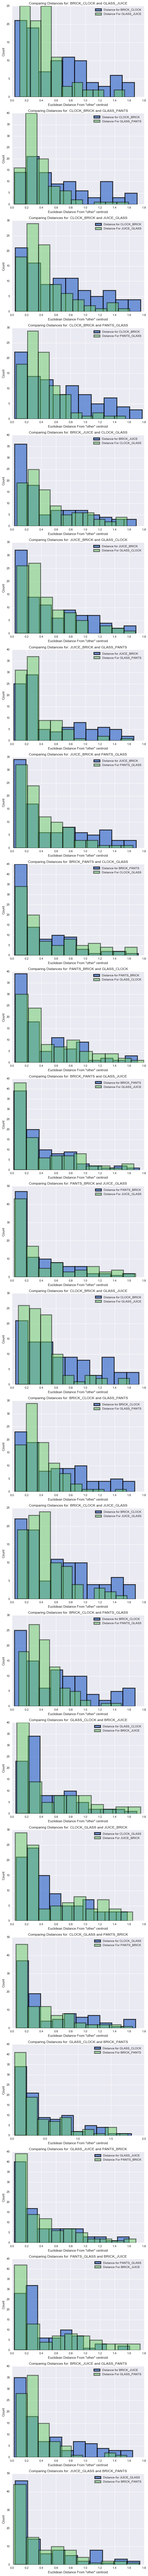

In [7]:
num_groups = len(diff_words_groups)
fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(diff_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

#     chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
    chans_to_analyze = str(np.arange(1,96,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
#     print first_feature.shape
#     print second_feature.shape
    
    # compute freqX1 centroid vector
    first_centroid = np.mean(first_feature,axis=0)
    second_centroid = np.mean(second_feature,axis=0)
     
    # compute list of distances from other centroid
    first_hist = [distances(x, second_centroid) for x in first_feature]
    second_hist = [distances(x, first_centroid) for x in second_feature]
    
    ## log transform
#     first_hist = np.log(first_hist)
#     second_hist = np.log(second_hist)
    
    ### 04: Plot Histogram of Distances
    plt.subplot(num_groups, 1, idx+1)
#     fig = plt.figure()
    first_label = 'Distance for ' + group[0]
    second_label = 'Distance For ' + group[1]
    plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
    plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
    plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
    plt.xlabel('Euclidean Distance From "other" centroid')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    
plt.tight_layout()
#     break  

## Reversed Word Pairs Overlap

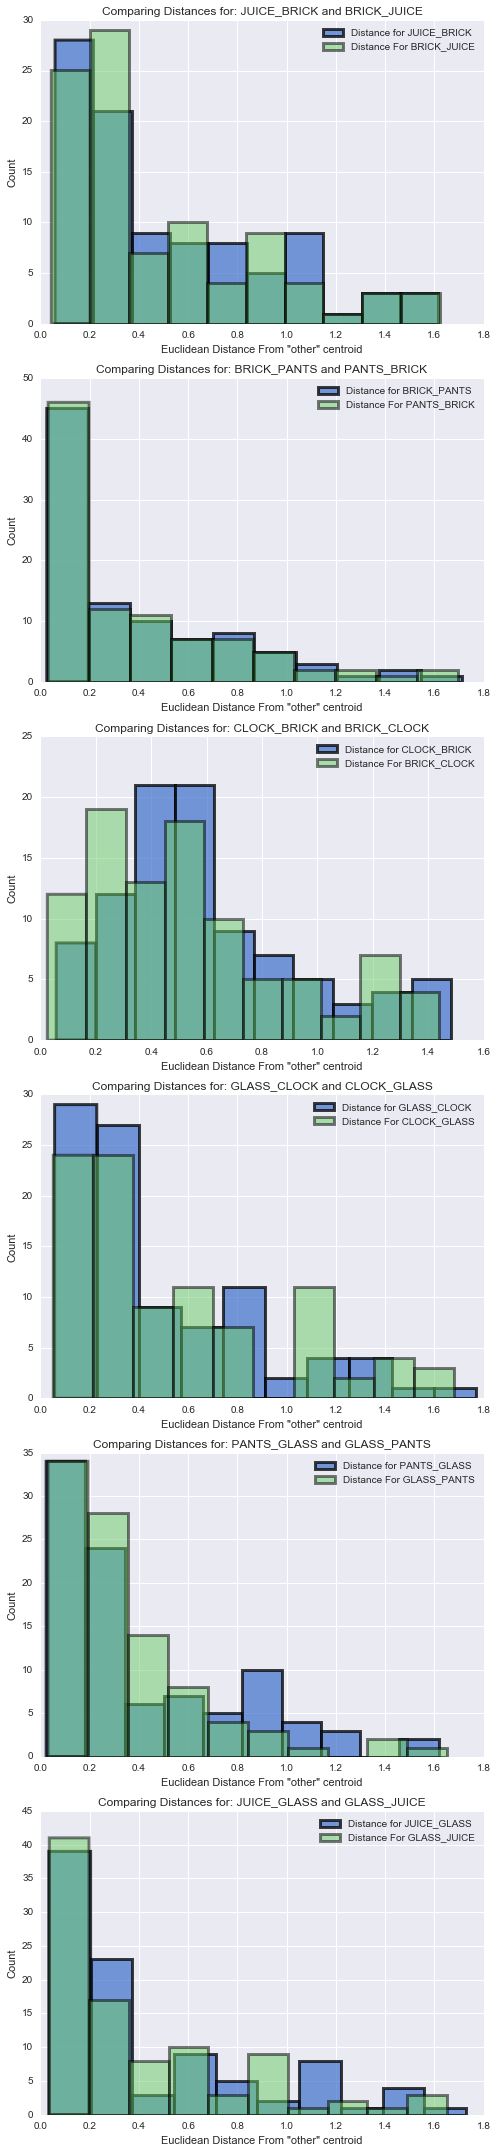

In [8]:
num_groups = len(reverse_words_groups)
fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(reverse_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

#     chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
    chans_to_analyze = str(np.arange(1,96,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
#     print first_feature.shape
#     print second_feature.shape
    
    # compute freqX1 centroid vector
    first_centroid = np.mean(first_feature,axis=0)
    second_centroid = np.mean(second_feature,axis=0)
     
    # compute list of distances from other centroid
    first_hist = [distances(x, second_centroid) for x in first_feature]
    second_hist = [distances(x, first_centroid) for x in second_feature]
    
    ## log transform
#     first_hist = np.log(first_hist)
#     second_hist = np.log(second_hist)
    
    ### 04: Plot Histogram of Distances
    plt.subplot(num_groups, 1, idx+1)
#     fig = plt.figure()
    first_label = 'Distance for ' + group[0]
    second_label = 'Distance For ' + group[1]
    plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
    plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
    plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
    plt.xlabel('Euclidean Distance From "other" centroid')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    
plt.tight_layout()
#     break  

## Probe Words Overlap Analysis

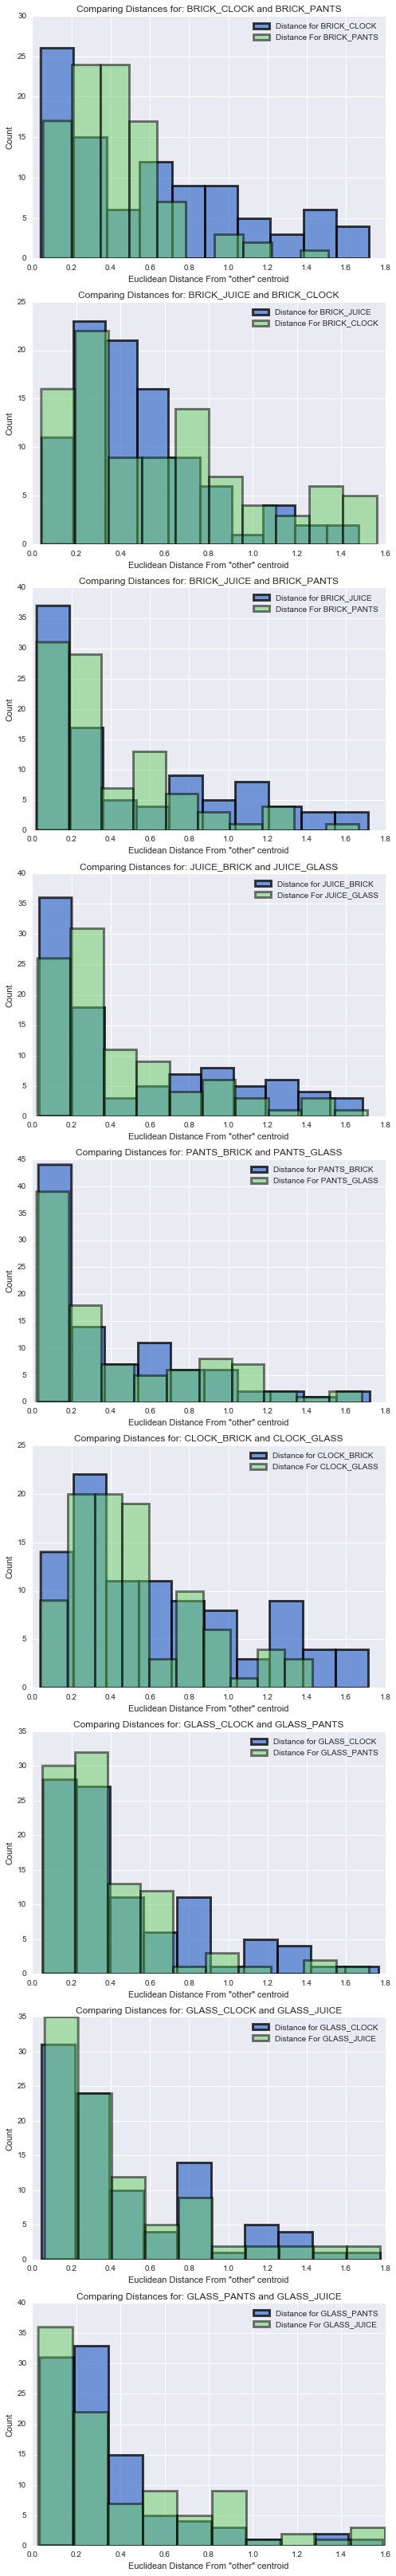

In [9]:
num_groups = len(probe_words_groups)
fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(probe_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

#     chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
    chans_to_analyze = str(np.arange(1,96,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
#     print first_feature.shape
#     print second_feature.shape
    
    # compute freqX1 centroid vector
    first_centroid = np.mean(first_feature,axis=0)
    second_centroid = np.mean(second_feature,axis=0)
     
    # compute list of distances from other centroid
    first_hist = [distances(x, second_centroid) for x in first_feature]
    second_hist = [distances(x, first_centroid) for x in second_feature]
    
    ## log transform
#     first_hist = np.log(first_hist)
#     second_hist = np.log(second_hist)
    
    ### 04: Plot Histogram of Distances
    plt.subplot(num_groups, 1, idx+1)
#     fig = plt.figure()
    first_label = 'Distance for ' + group[0]
    second_label = 'Distance For ' + group[1]
    plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
    plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
    plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
    plt.xlabel('Euclidean Distance From "other" centroid')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    
plt.tight_layout()
#     break  

## Target Words Overlap Analysis

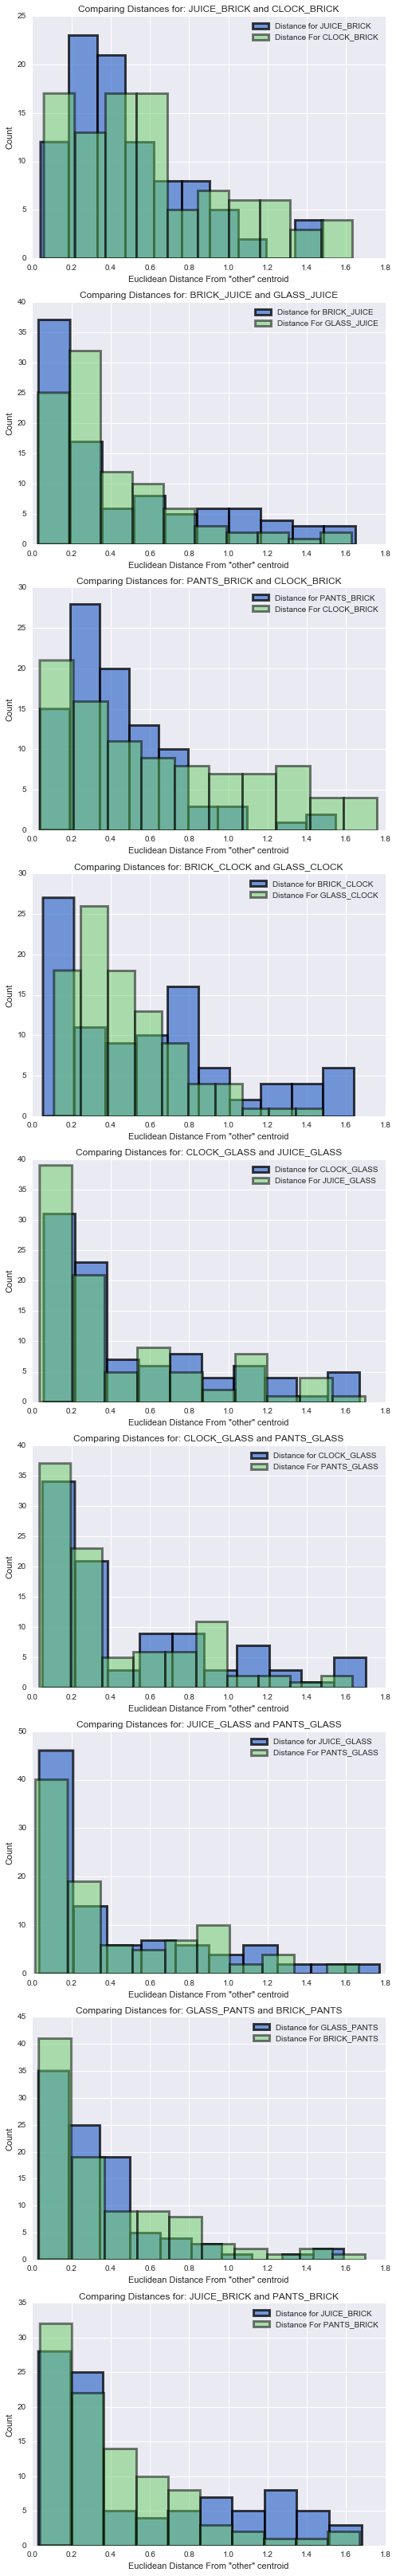

In [10]:
num_groups = len(target_words_groups)
fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(target_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

#     chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
    chans_to_analyze = str(np.arange(1,96,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
#     print first_feature.shape
#     print second_feature.shape
    
    # compute freqX1 centroid vector
    first_centroid = np.mean(first_feature,axis=0)
    second_centroid = np.mean(second_feature,axis=0)
     
    # compute list of distances from other centroid
    first_hist = [distances(x, second_centroid) for x in first_feature]
    second_hist = [distances(x, first_centroid) for x in second_feature]
    
    ## log transform
#     first_hist = np.log(first_hist)
#     second_hist = np.log(second_hist)
    
    ### 04: Plot Histogram of Distances
    plt.subplot(num_groups, 1, idx+1)
#     fig = plt.figure()
    first_label = 'Distance for ' + group[0]
    second_label = 'Distance For ' + group[1]
    plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
    plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
    plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
    plt.xlabel('Euclidean Distance From "other" centroid')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    
plt.tight_layout()
#     break  

# Discussion
I tried using cosine and euclidean distance measures and varying the amount of channels I include by changing the threshold hyperparameter. Many of these functions seem to overlay each other.

What I want to try underneath here is to show the distances for one of the very different words vs. a word pair that should be more similar and plot those two histograms. My worry is that there are so many euclidean distances close to 0.

In [6]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1, 5]
# freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1, 5]
['delta', 'theta', 'high gamma']
The length of the feature vector for each channel will be:  15


## PCA Component Analysis

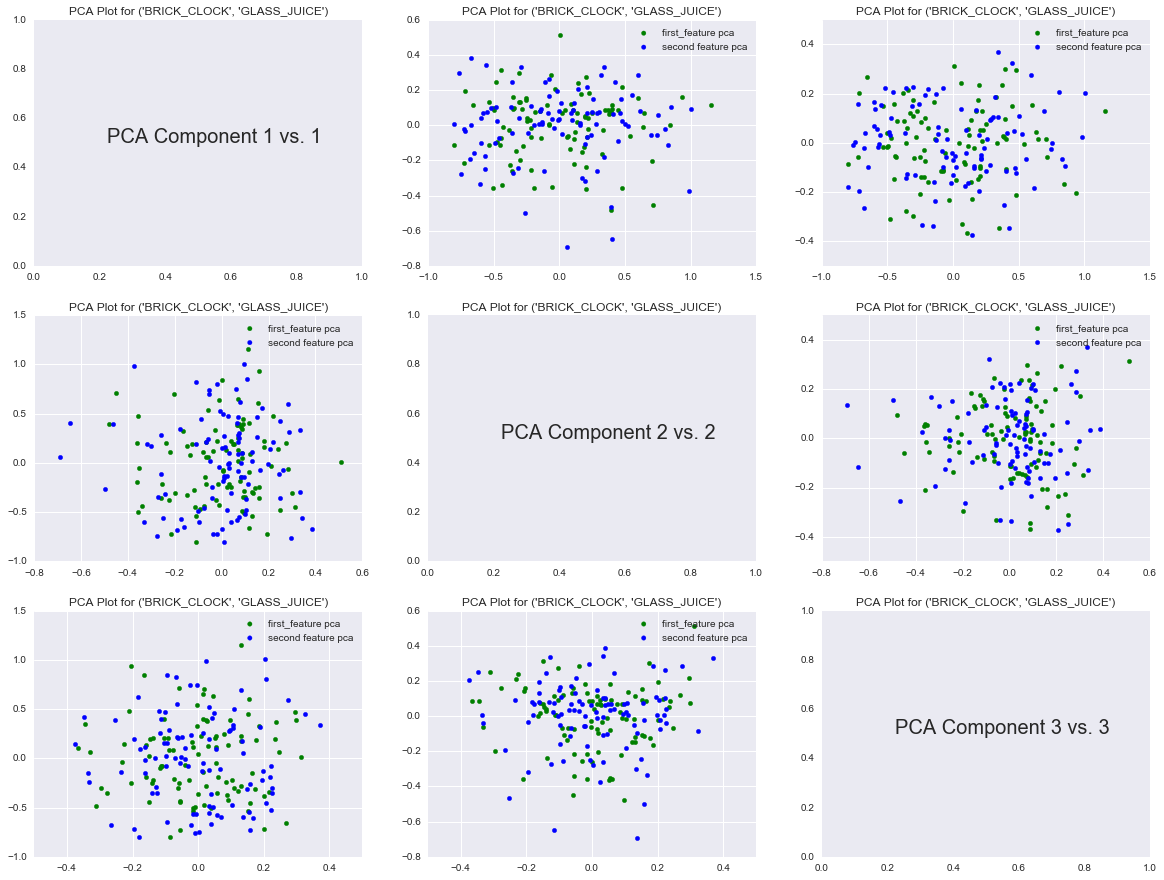

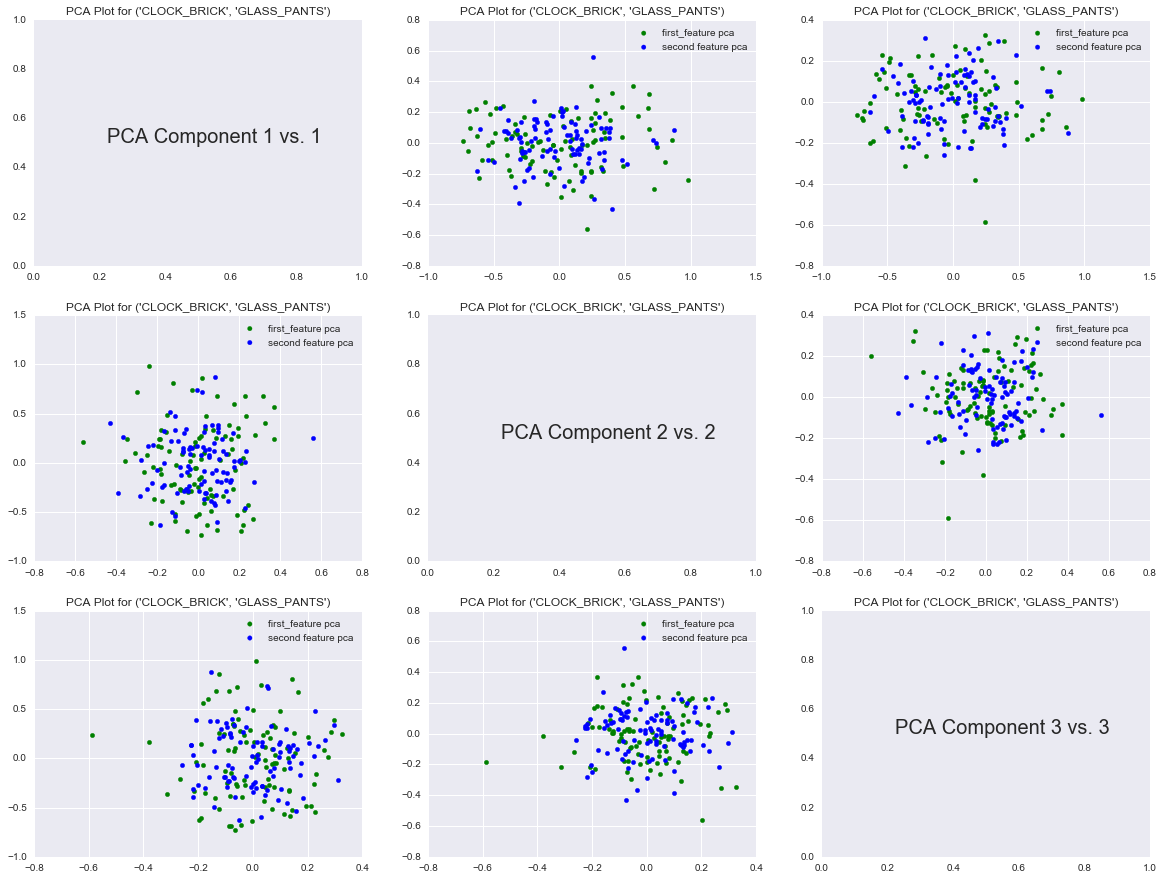

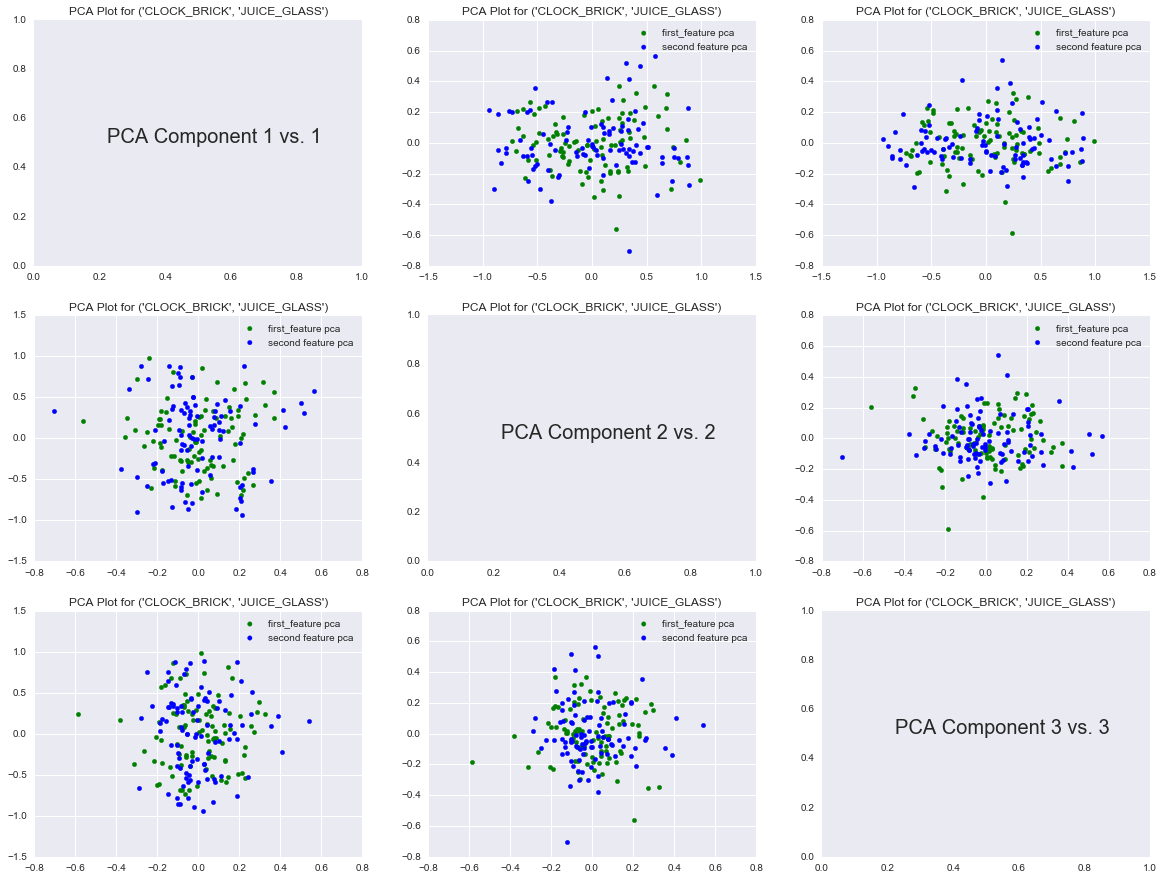

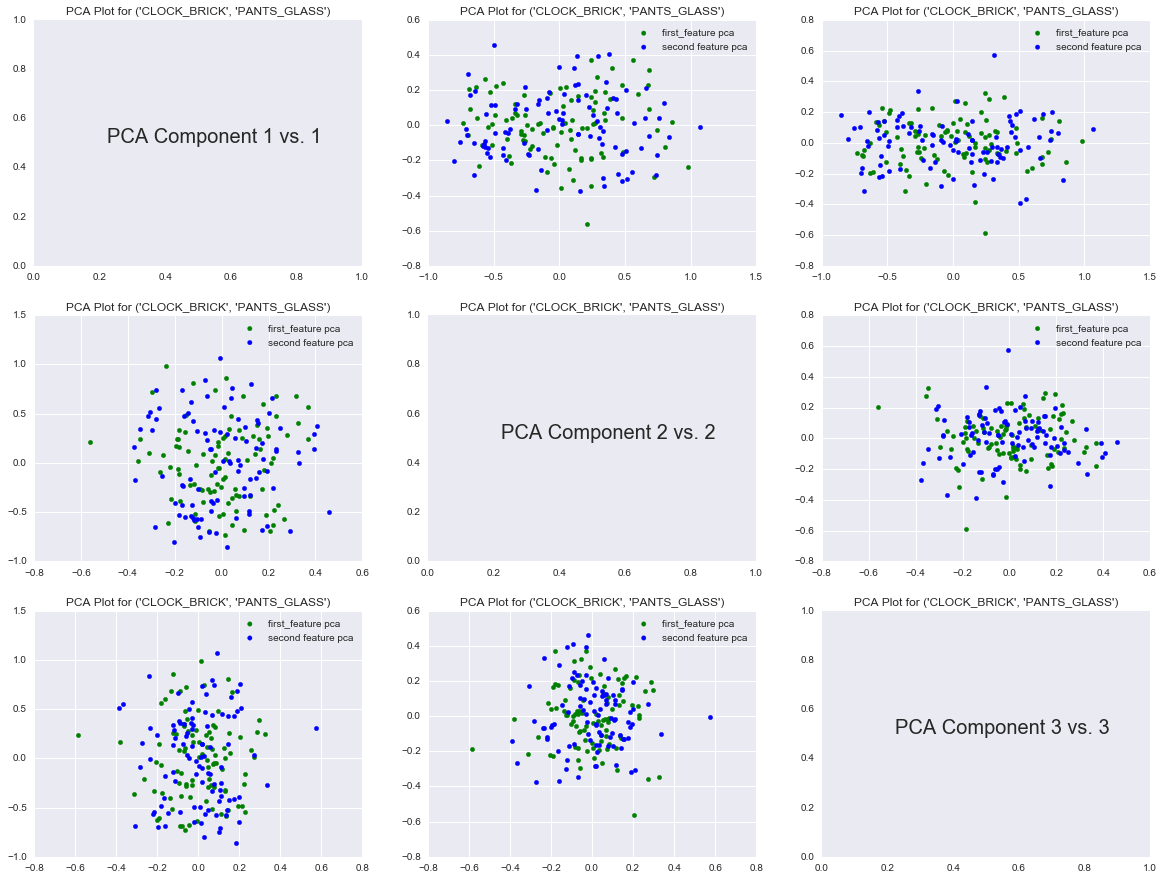

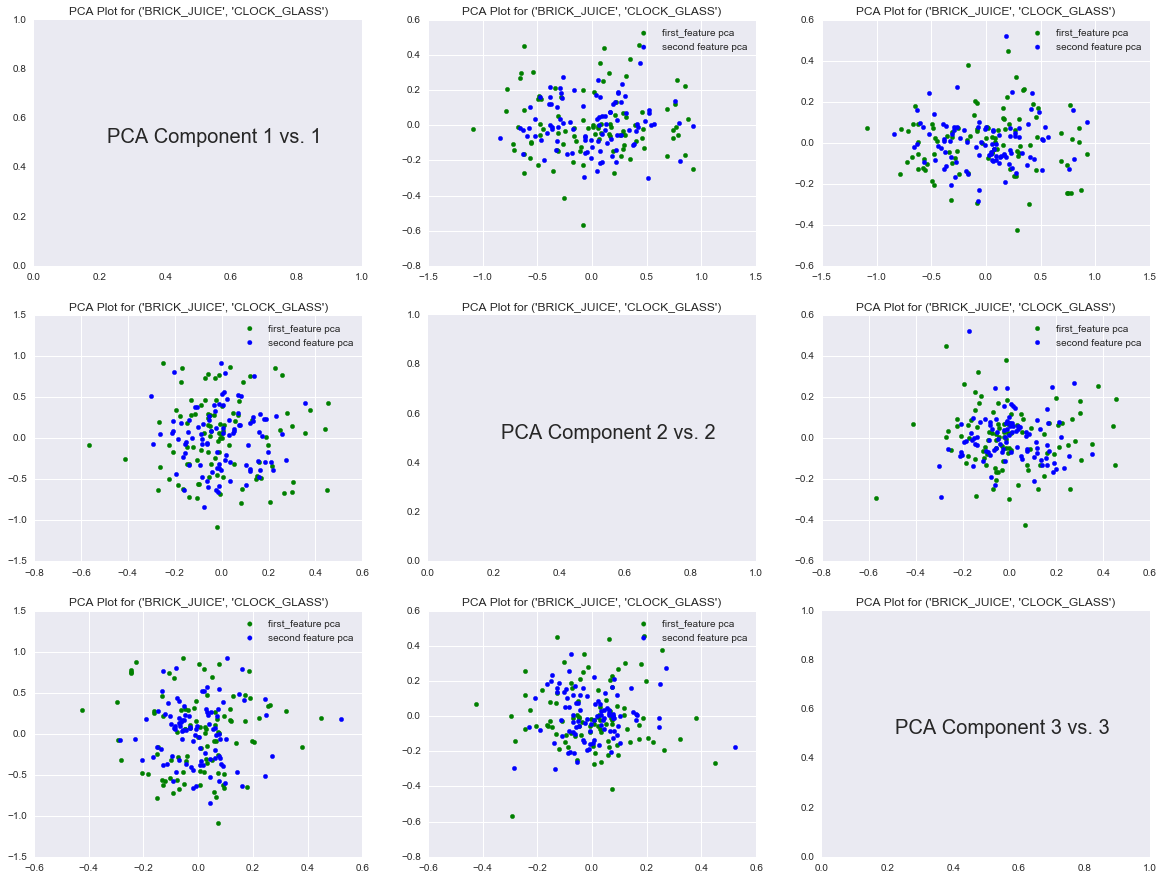

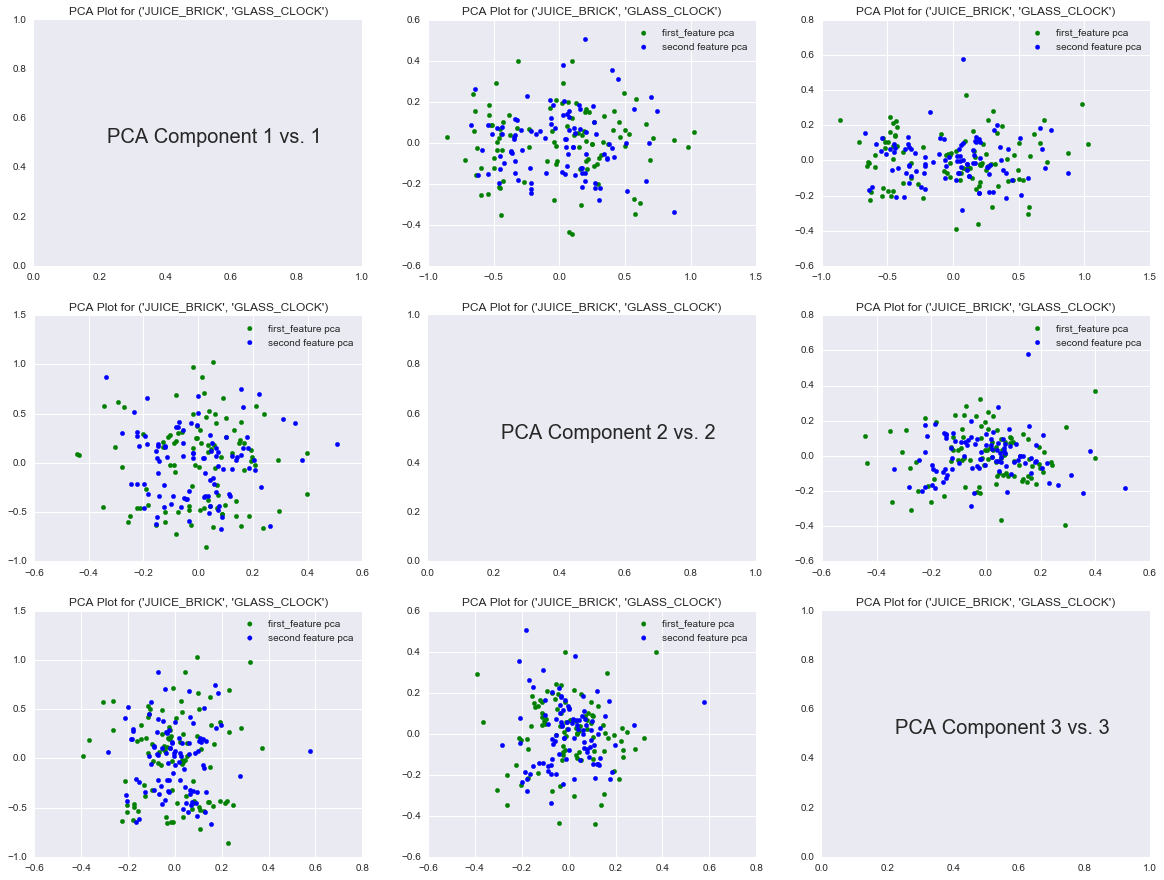

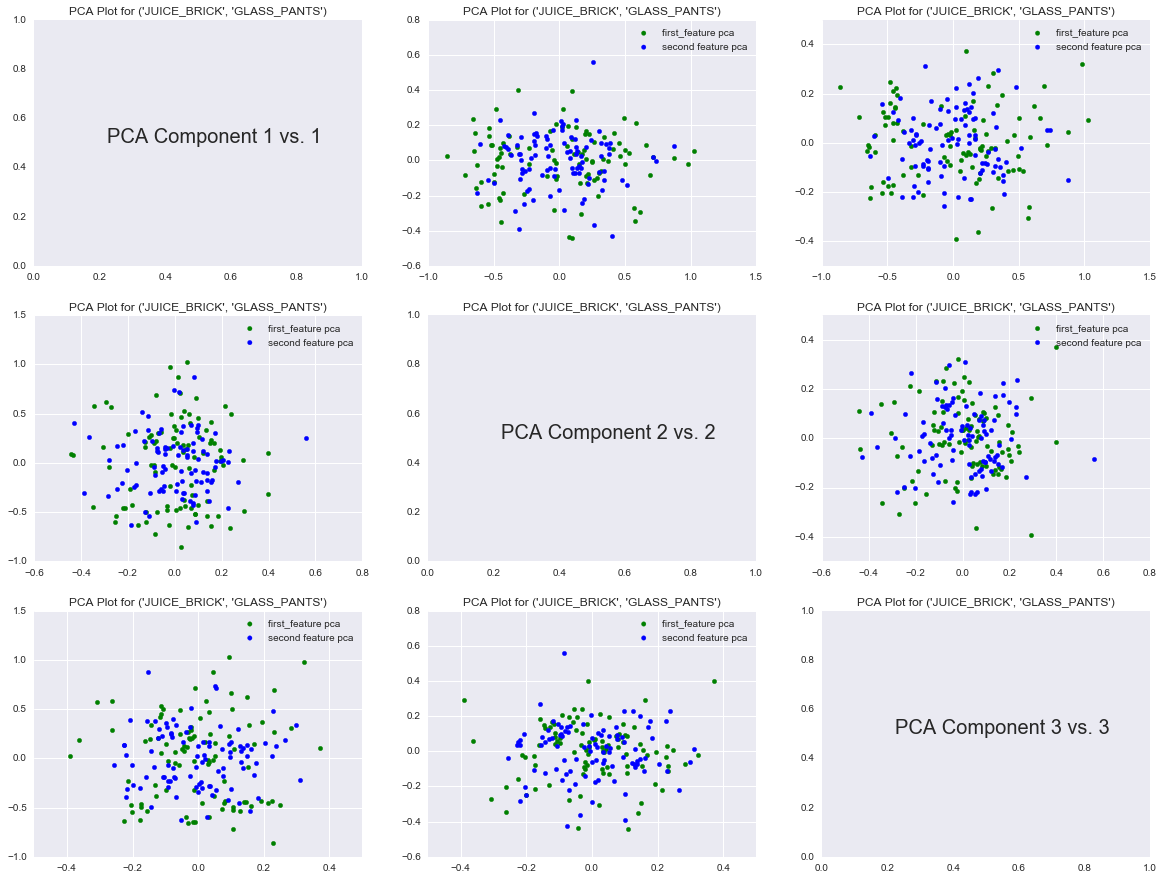

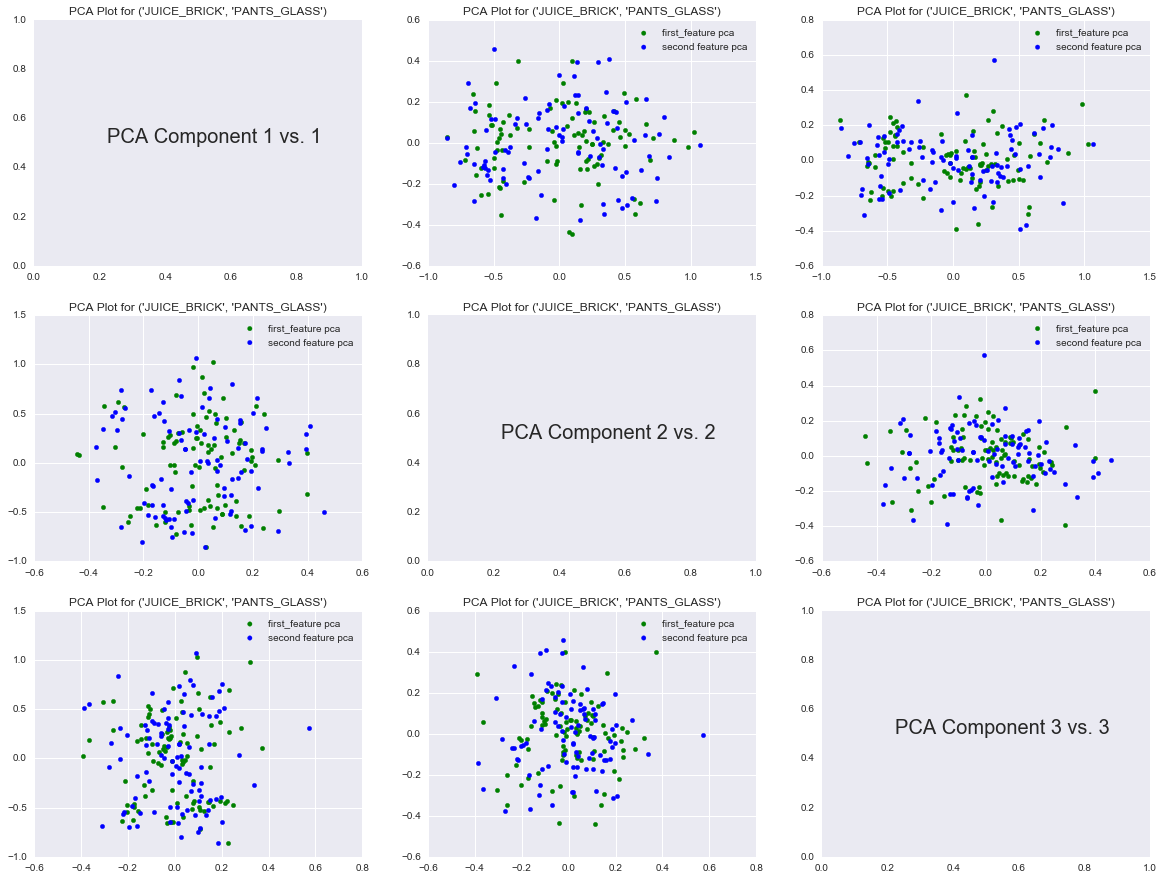

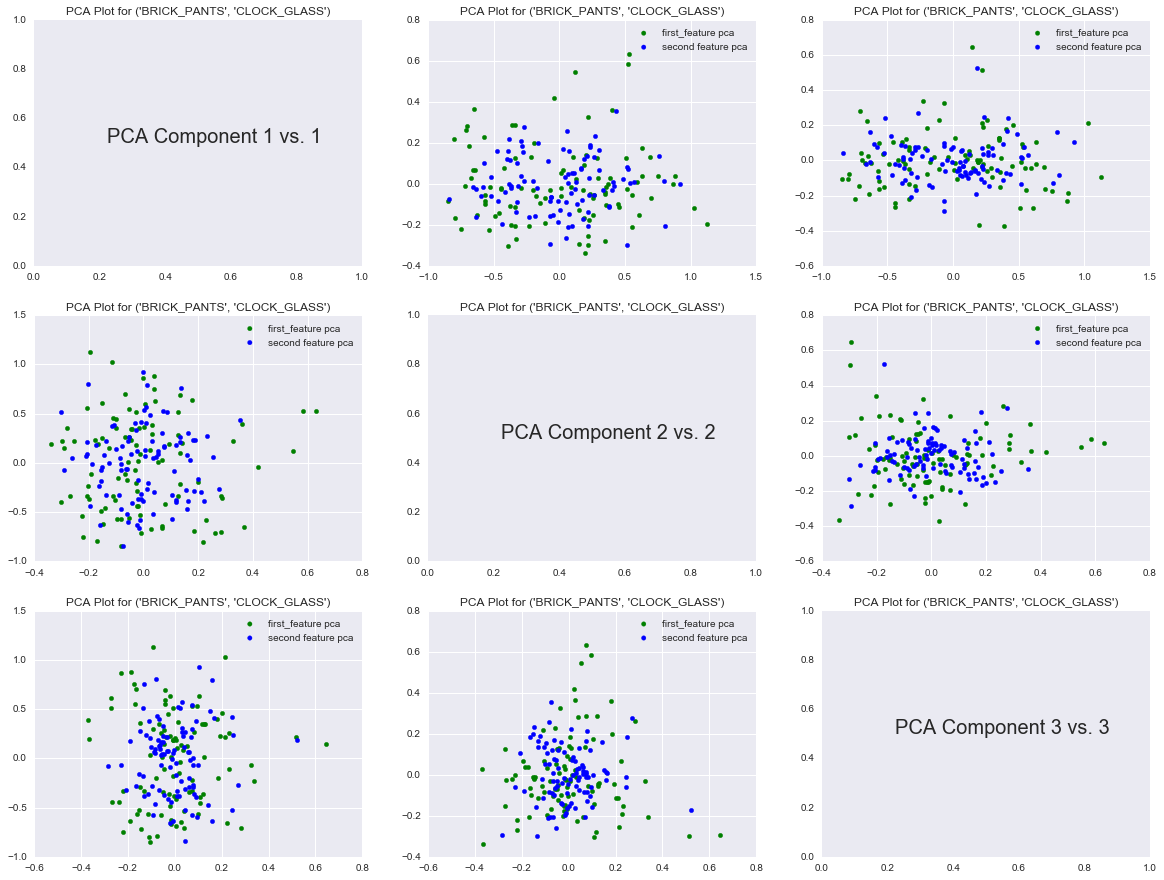

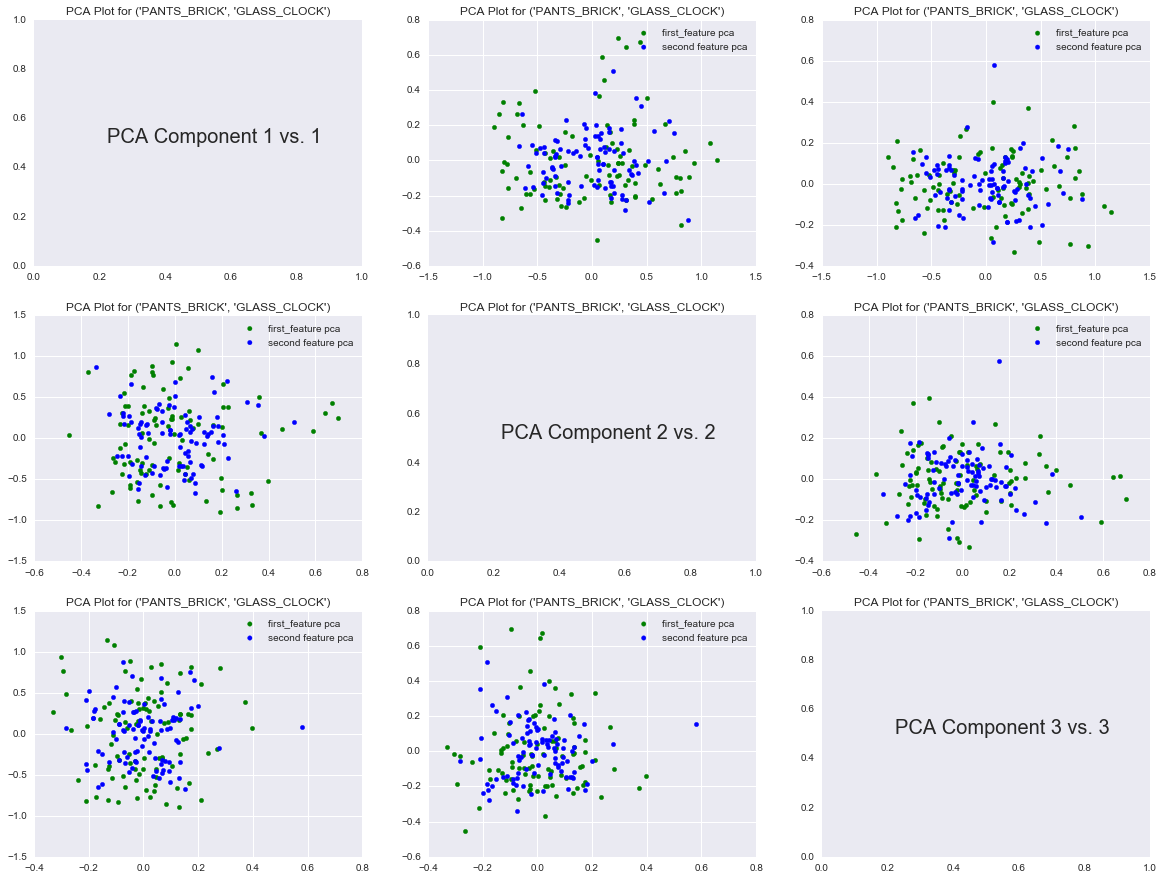

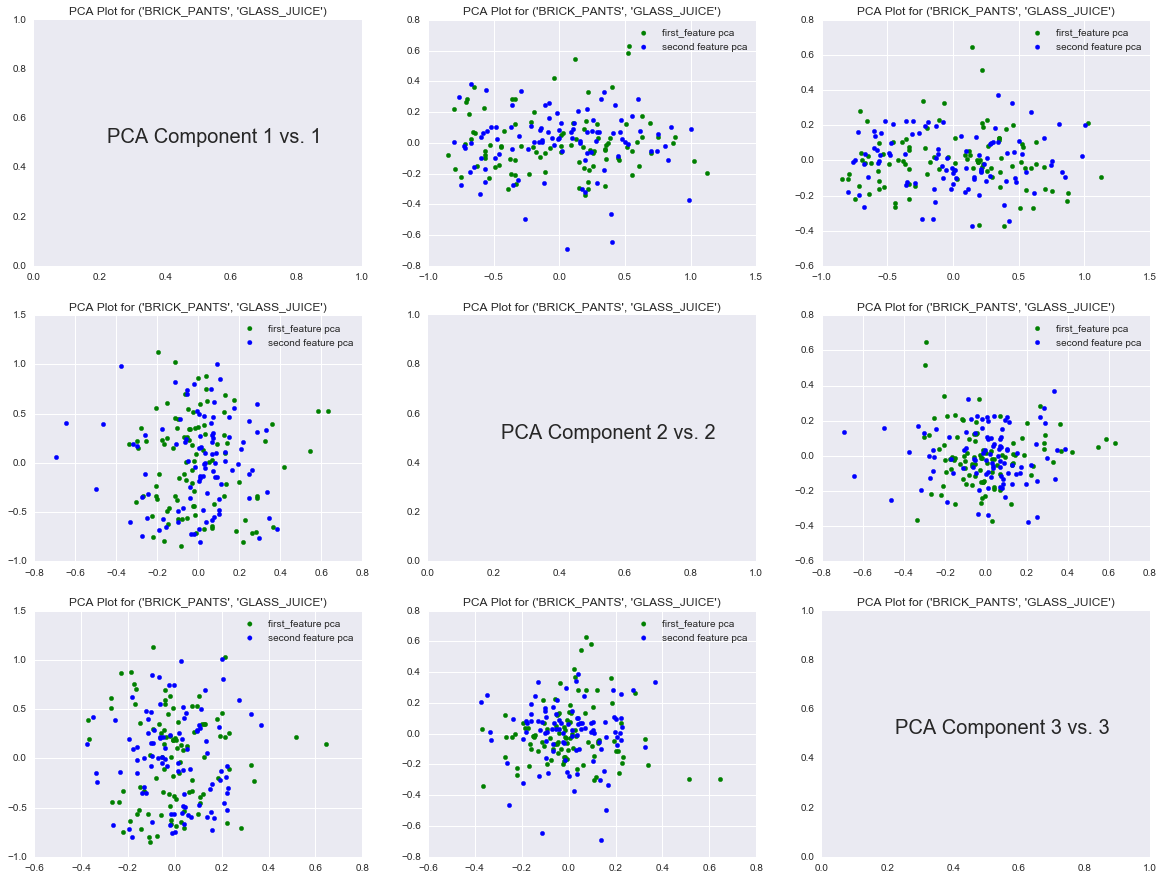

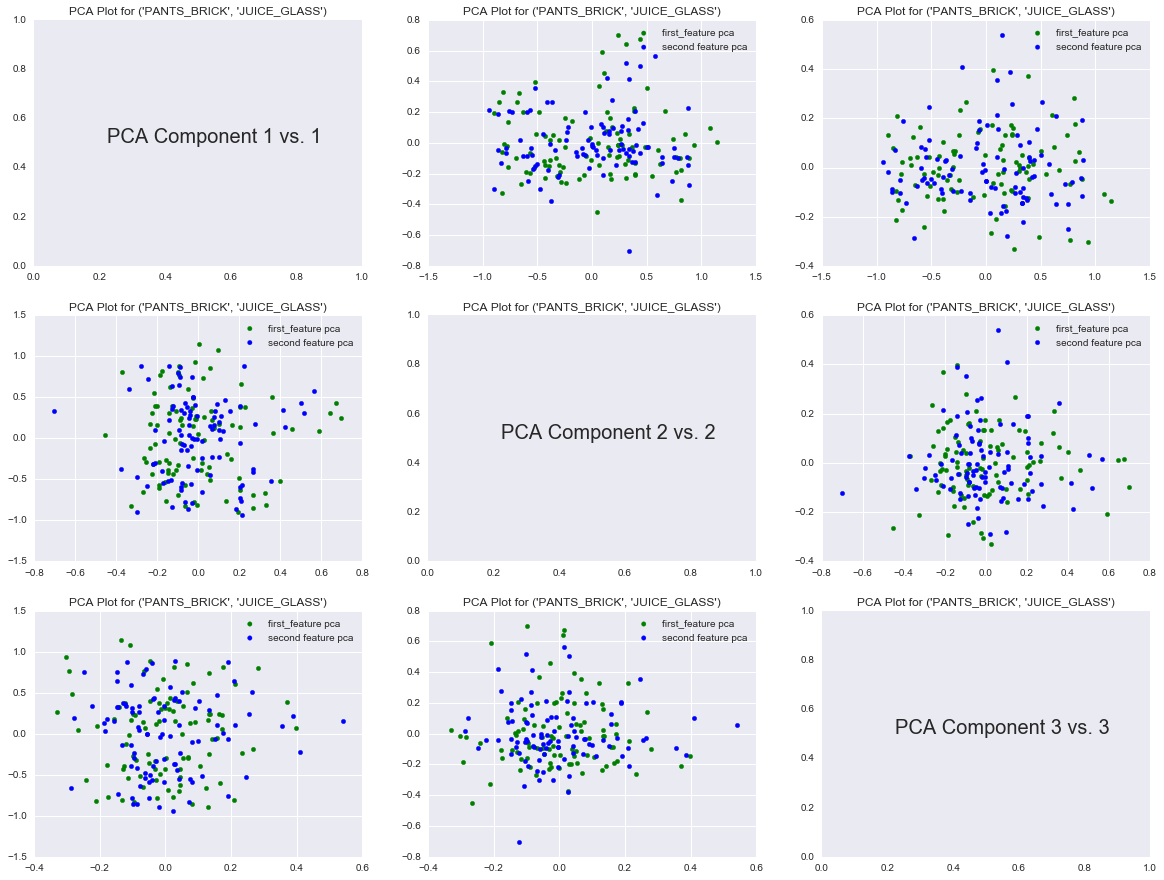

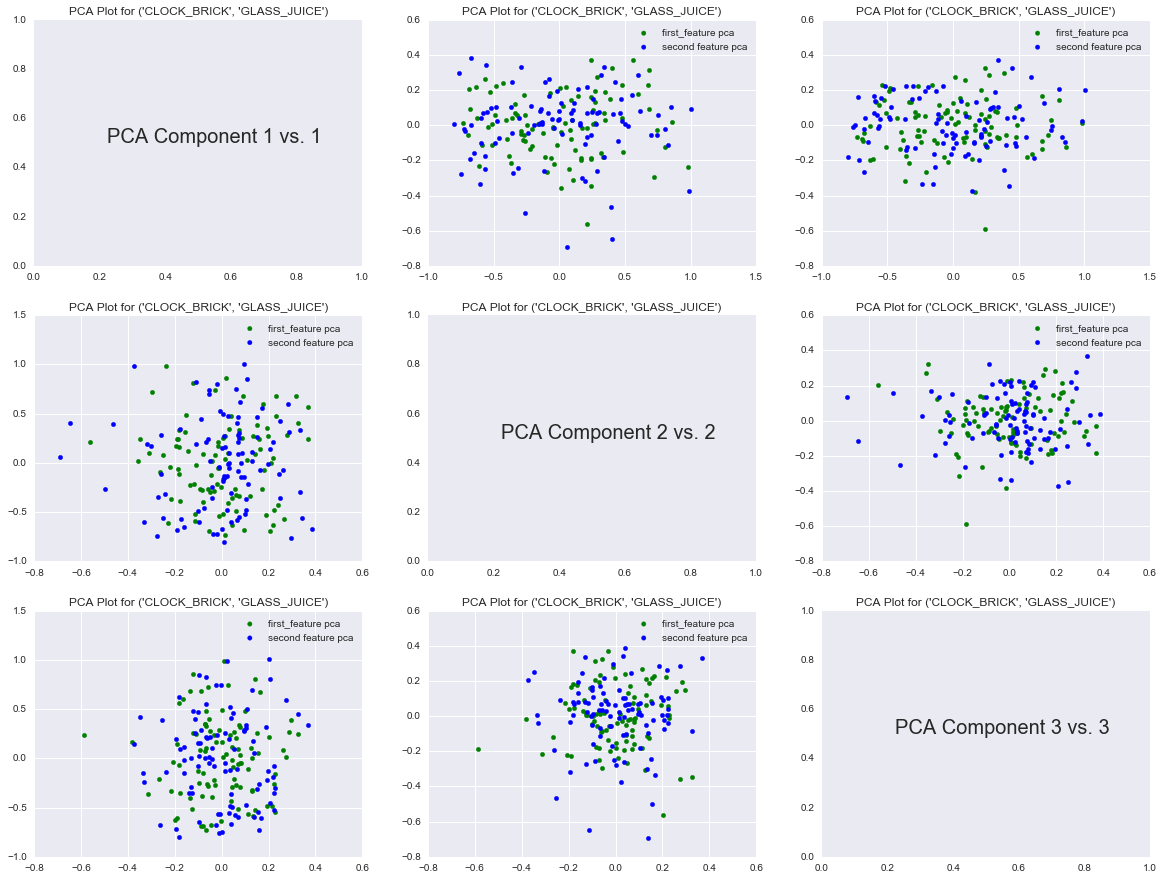

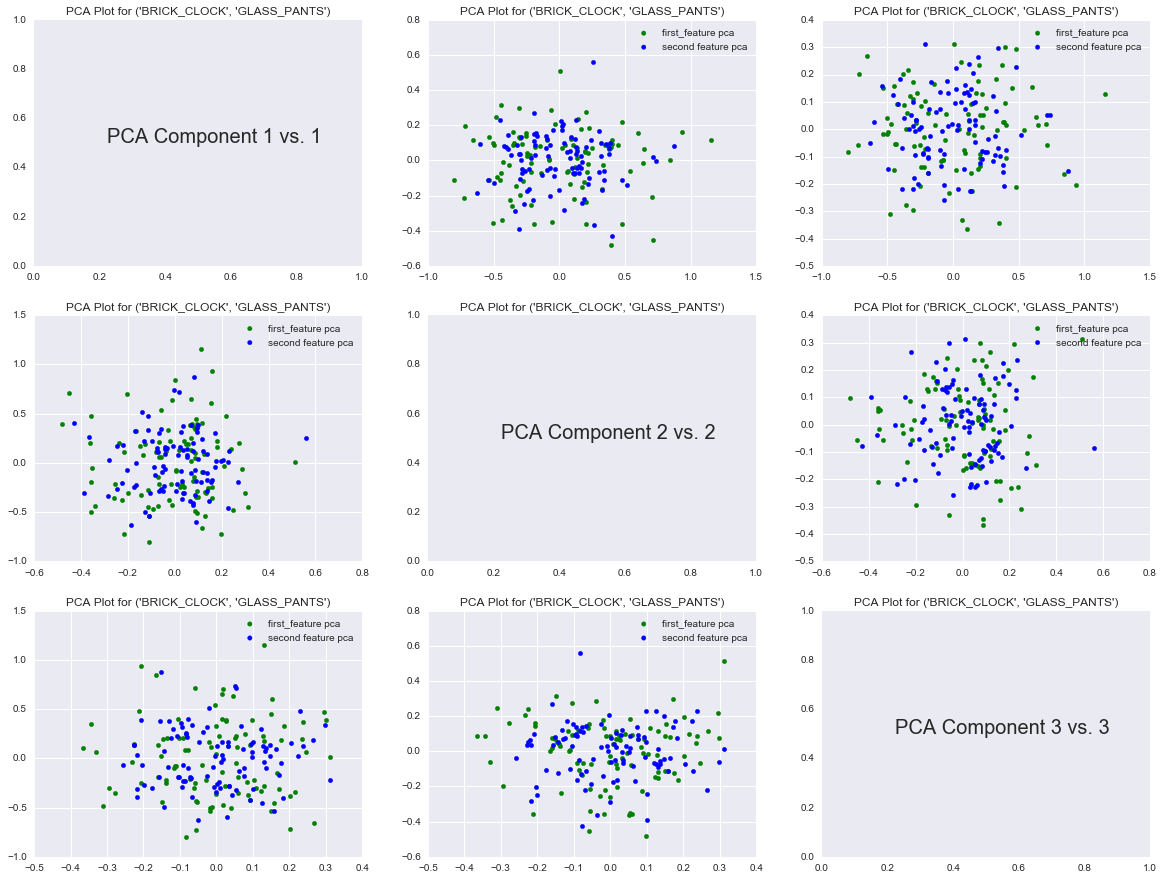

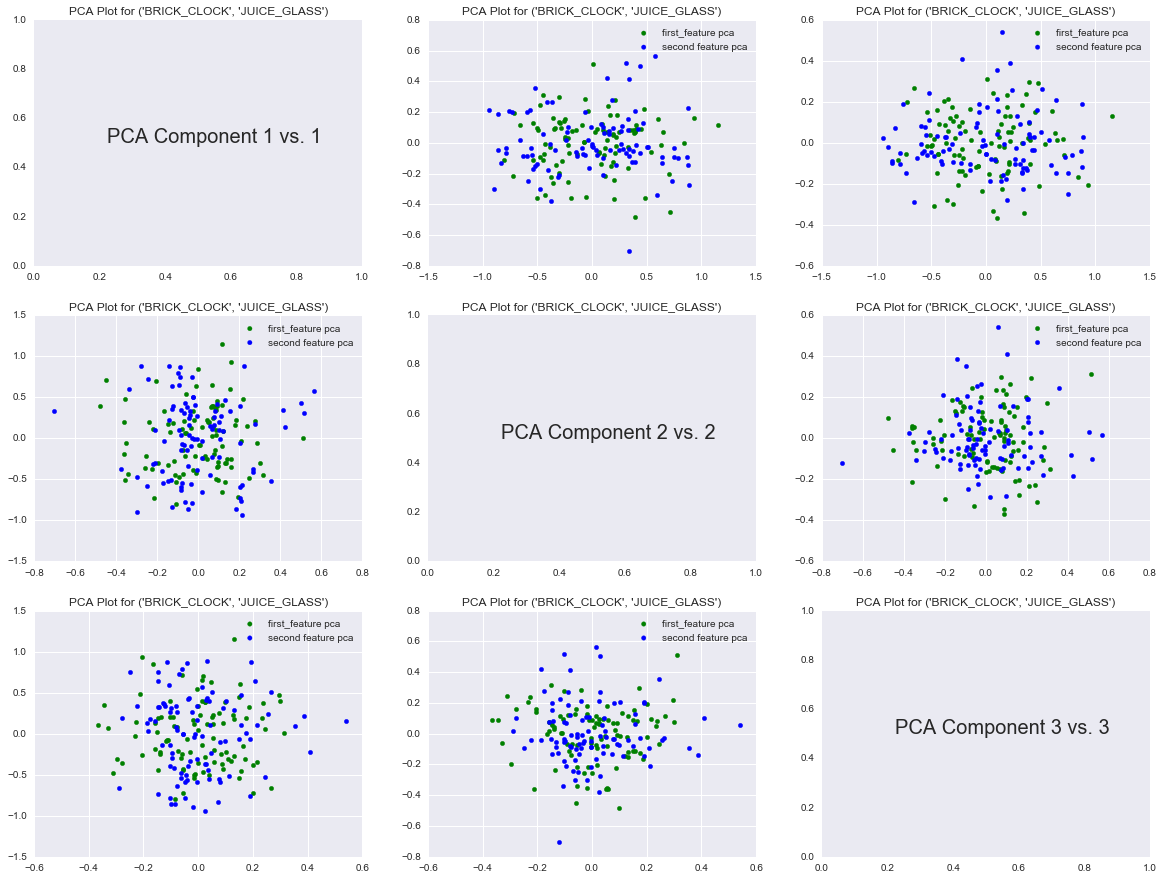

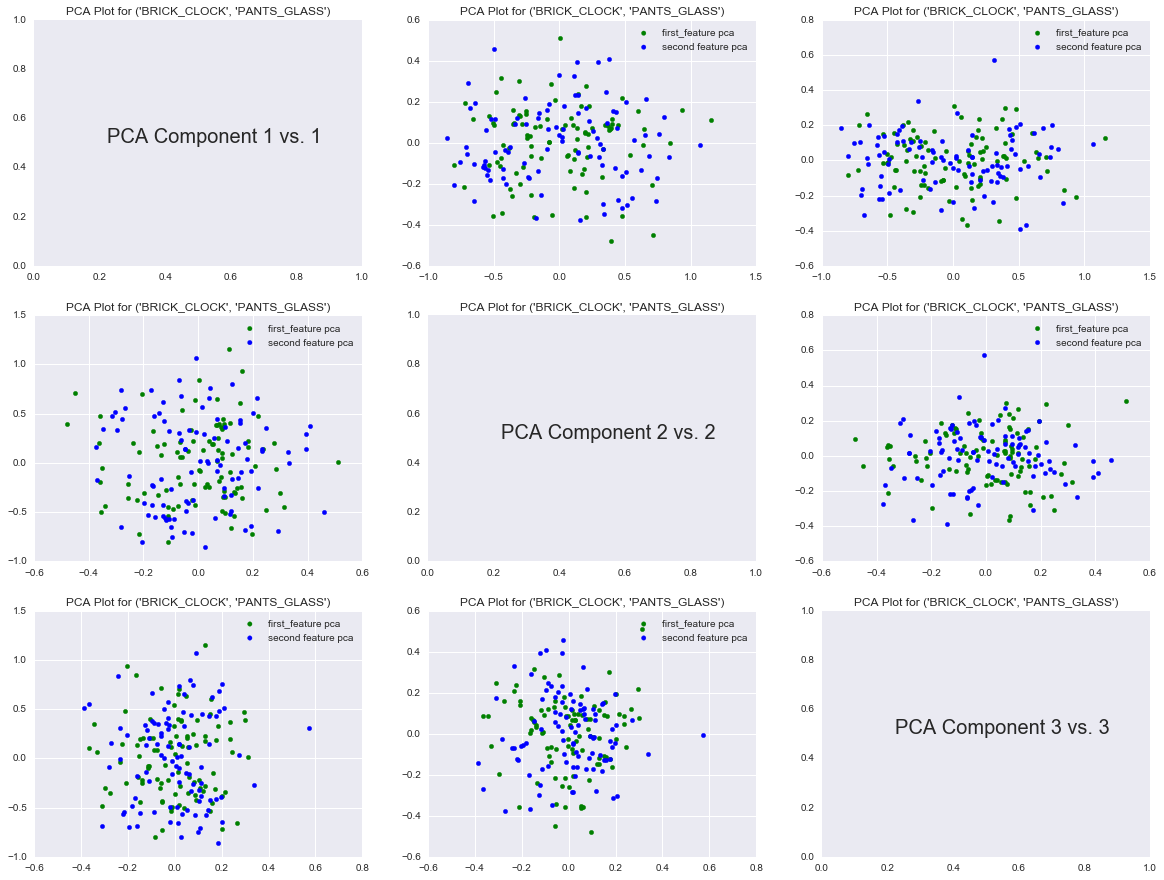

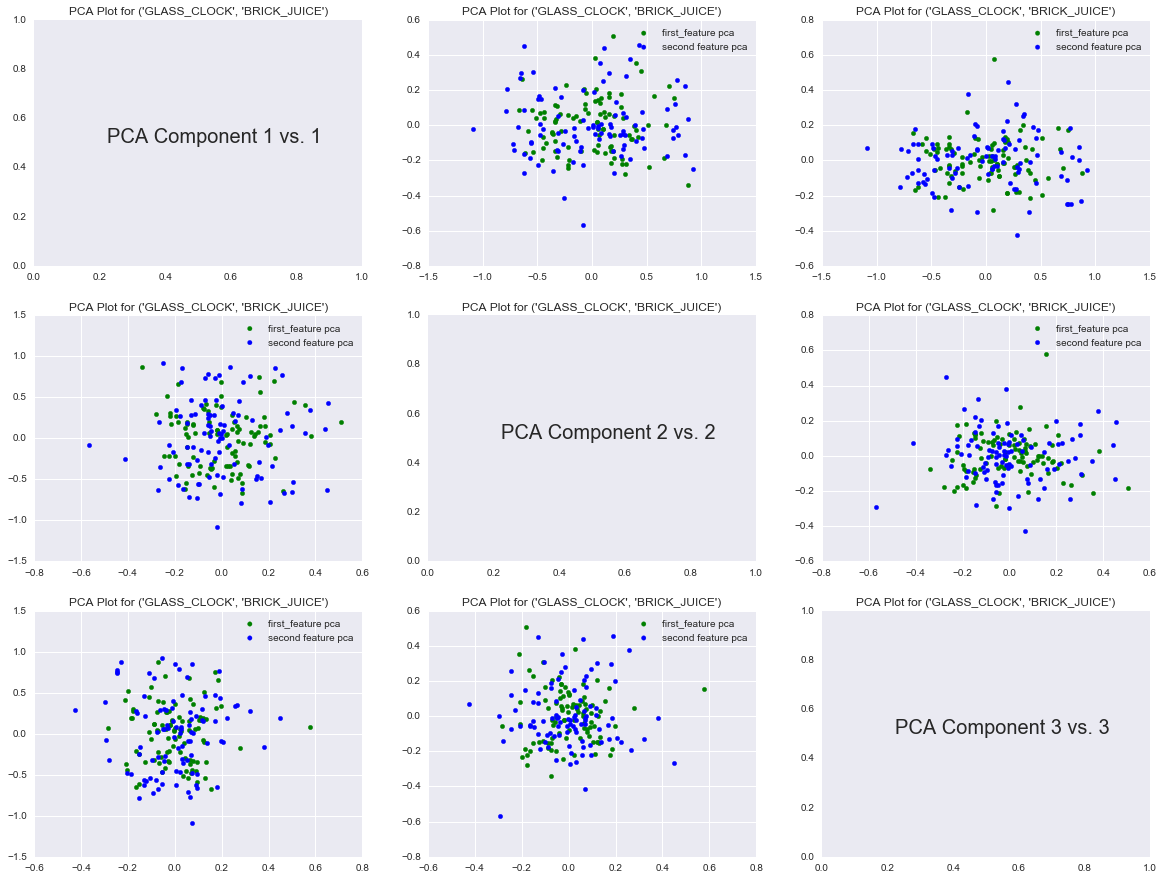

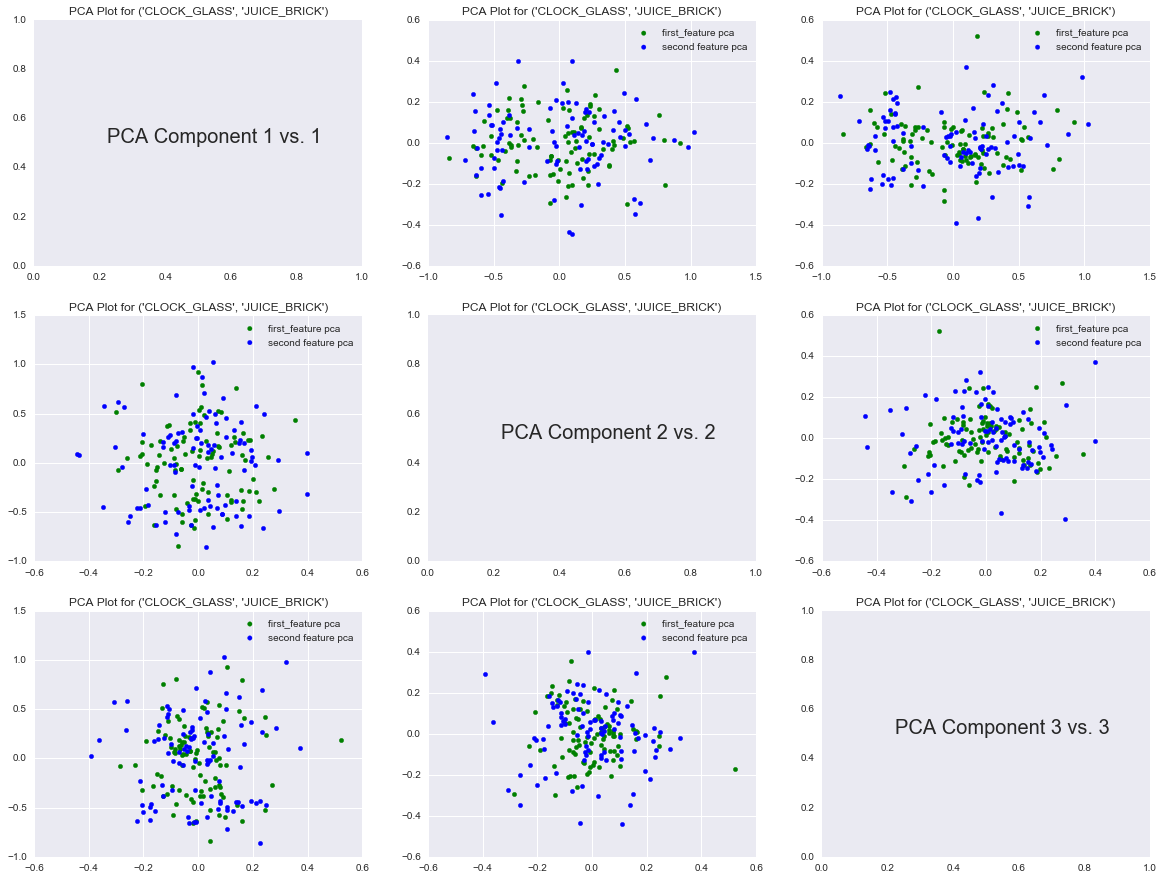

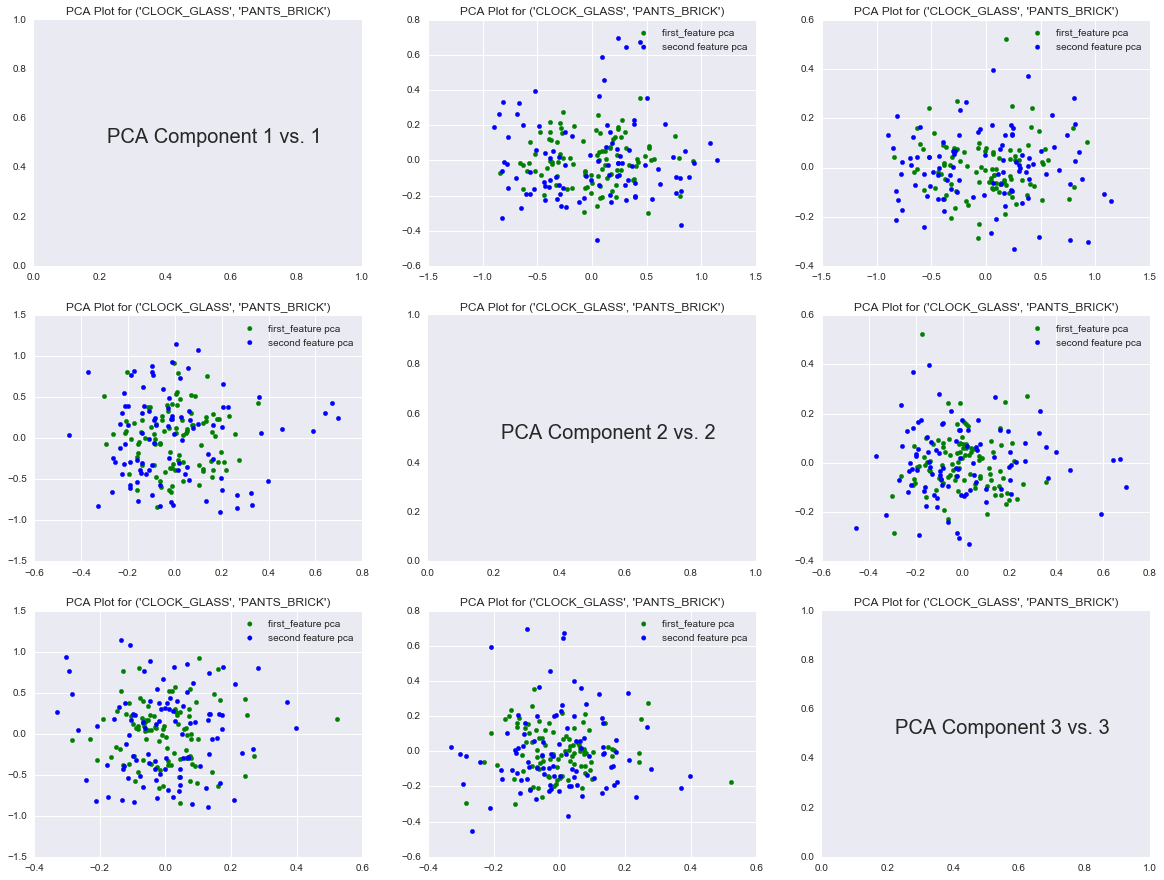

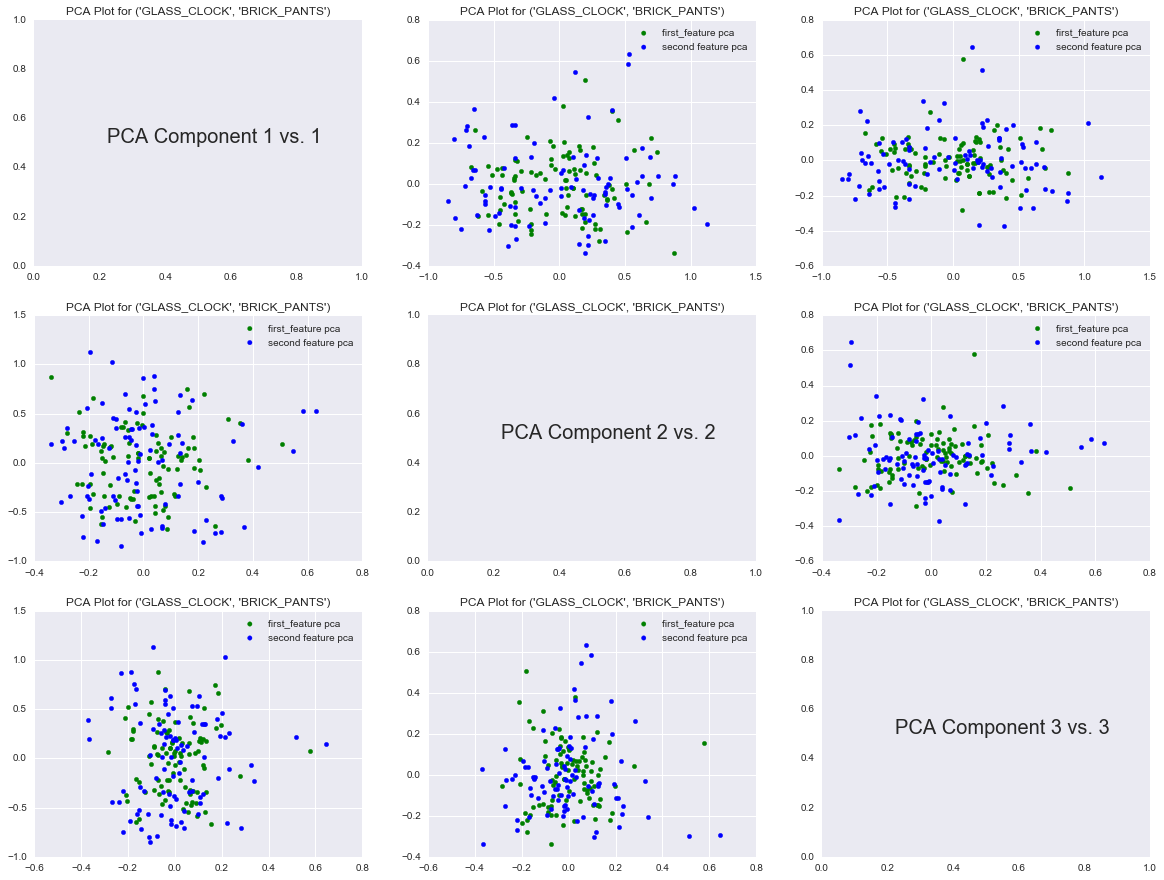

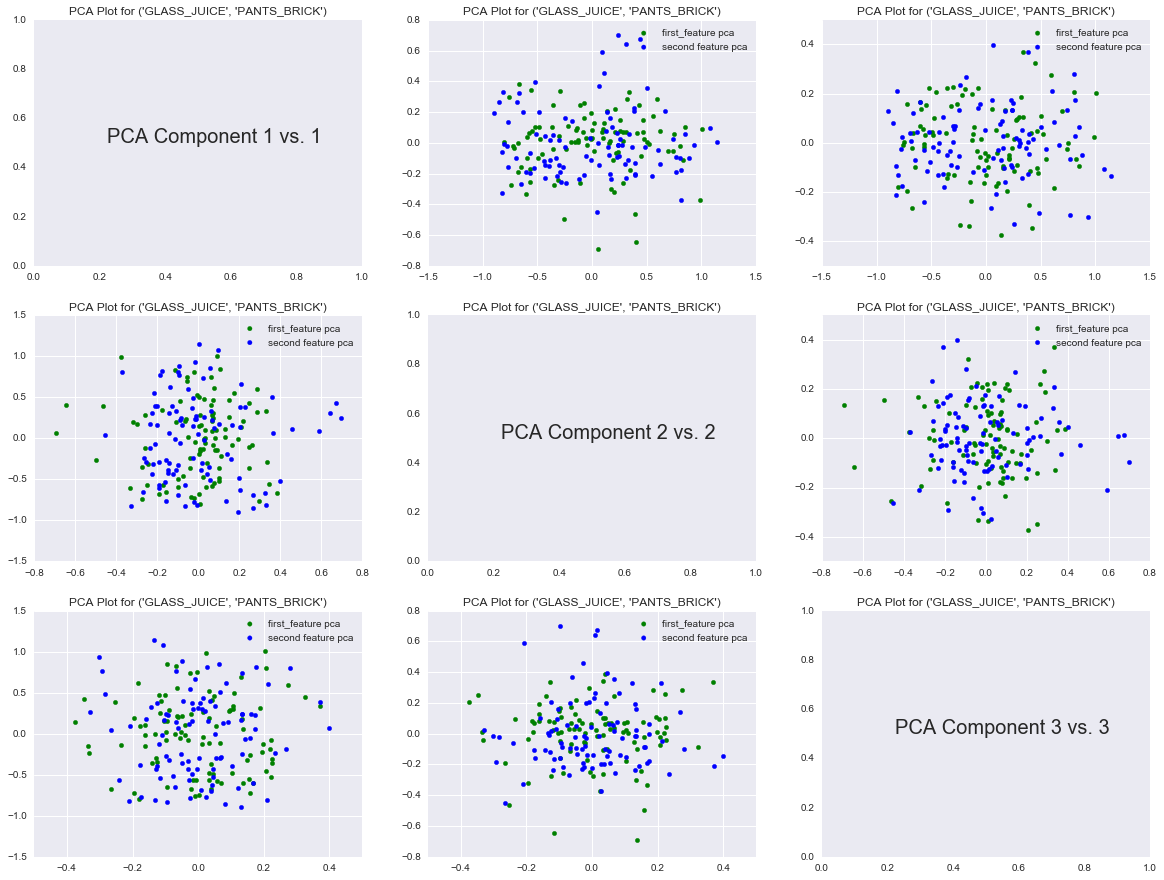

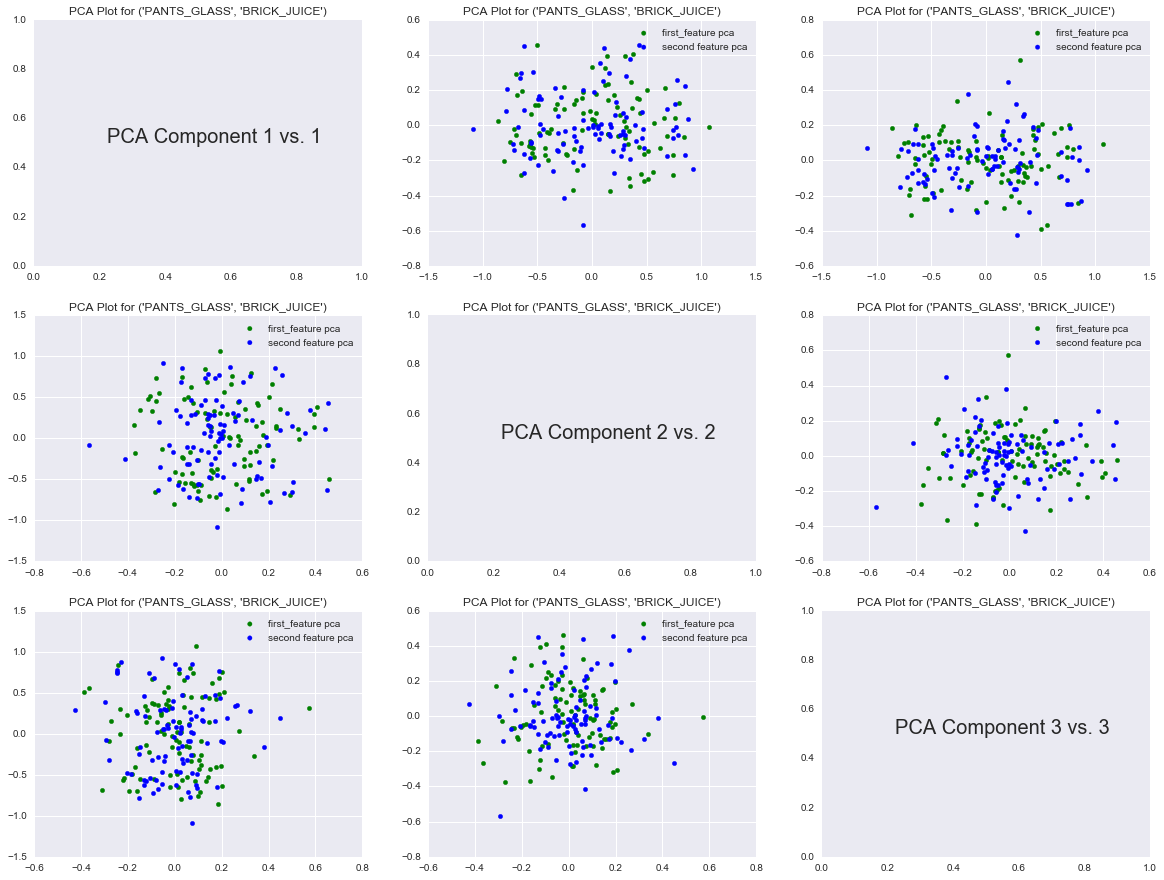

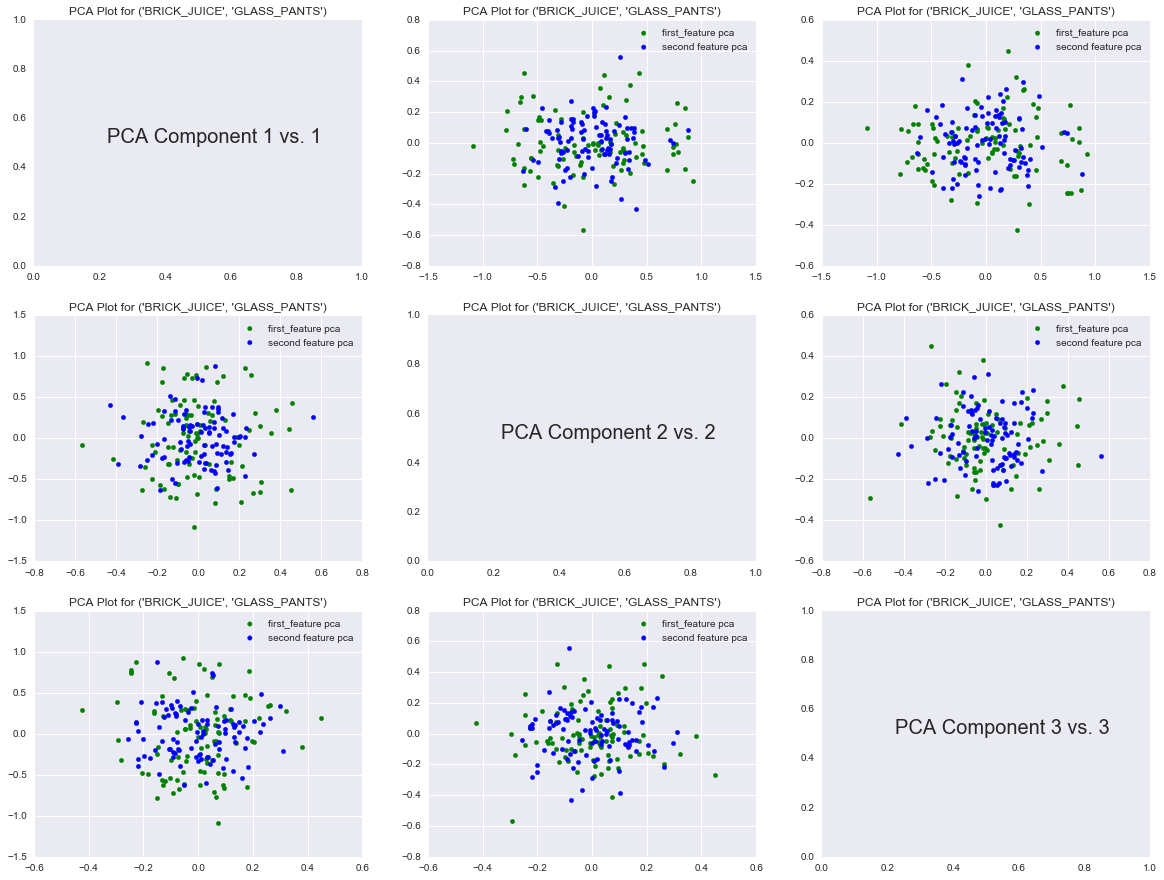

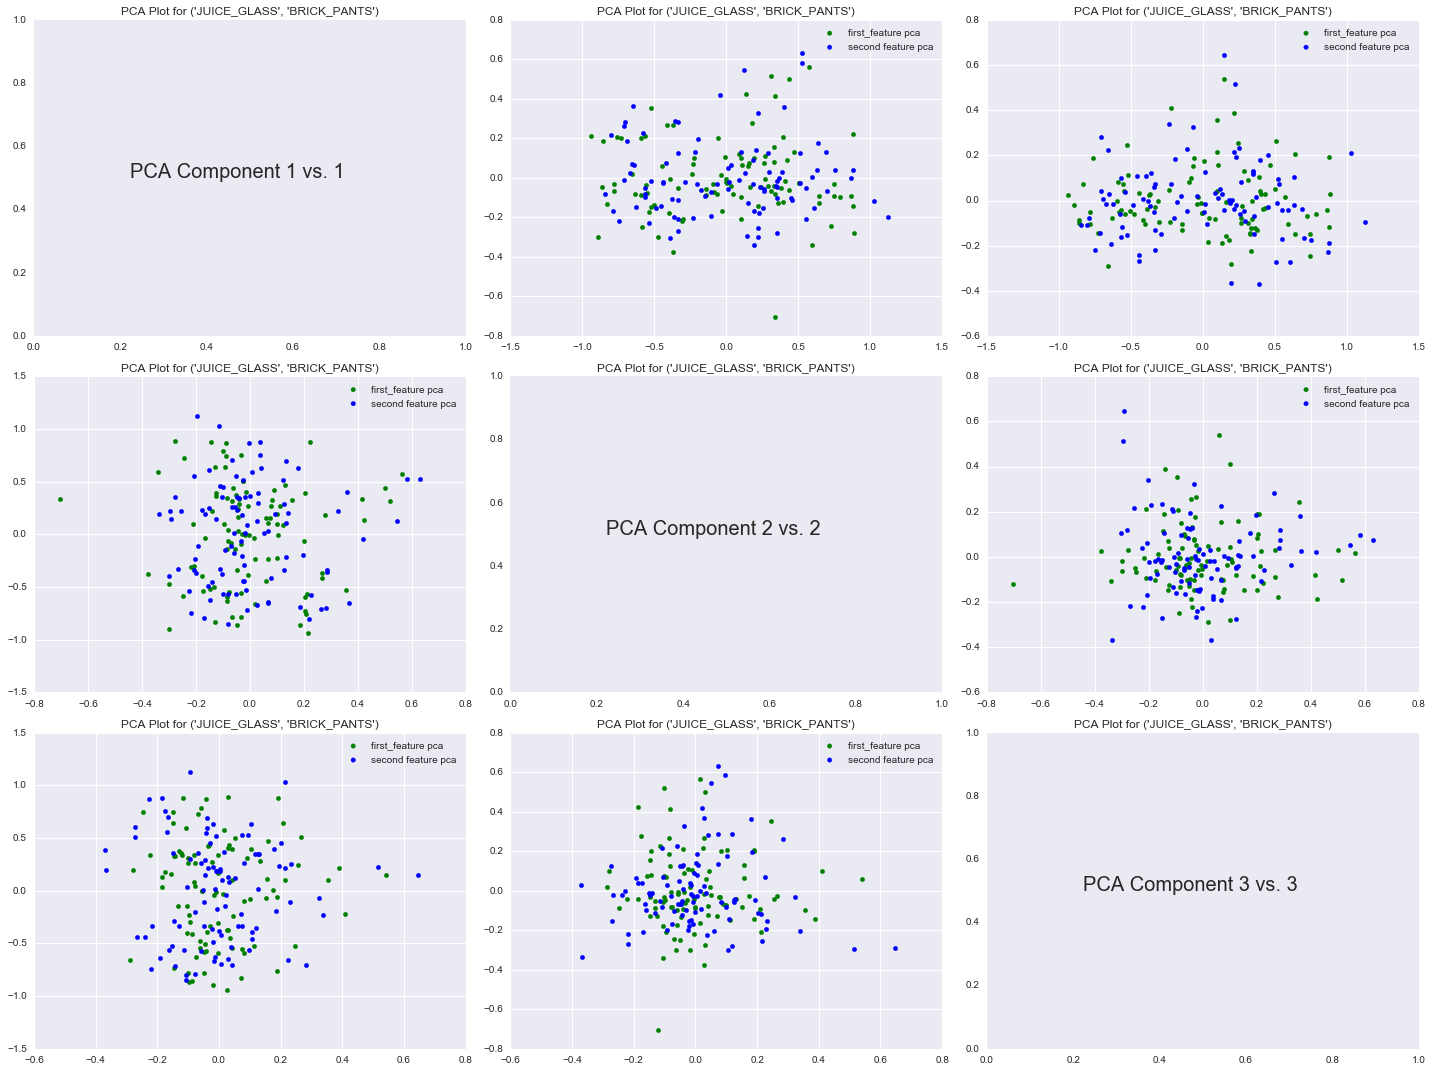

In [37]:
## plot all in pca space vs. another
num_groups = len(diff_words_groups)
# fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(diff_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

#     chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
    chans_to_analyze = str(np.arange(1,97,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
    ### 04: PCA On Features
    pca = PCA(n_components=3)
    first_pca = pca.fit_transform(first_feature)
    second_pca = pca.fit_transform(second_feature)
    
    # compute freqX1 centroid vector
#     first_centroid = np.mean(first_feature,axis=0)
#     second_centroid = np.mean(second_feature,axis=0)
     
#     # compute list of distances from other centroid
#     first_hist = np.array([distances(x, second_centroid) for x in first_pca])
#     second_hist = np.array([distances(x, first_centroid) for x in second_pca])
    
#     print first_feature.shape
#     print second_feature.shape
#     print first_hist.shape
#     print second_hist.shape
#     print first_pca.shape
#     print second_pca.shape
#     break
    
    plt.figure(figsize=(20,15))
    pca_plot_i = 1
    for i in range(0, first_pca.shape[1]):
        for j in range(0, first_pca.shape[1]):
            plt.subplot(first_pca.shape[1], first_pca.shape[1], pca_plot_i)
            if i==j:
                axes = plt.gca()
                ymin, ymax = axes.get_ylim()
                xmin, xmax = axes.get_xlim()
                plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'PCA Component %d vs. %d'%(i+1, i+1), fontsize=20)
                plt.title('PCA Plot for ' + str(group))
                plt.grid(False)
            else:
                plt.scatter(first_pca[:,i], first_pca[:,j], color='g', label='first_feature pca')
                plt.scatter(second_pca[:,i], second_pca[:,j], color='b', label='second feature pca')
                plt.title('PCA Plot for ' + str(group))
                plt.legend()
            
            pca_plot_i += 1 # increment index to plot subplot

plt.tight_layout()

PCA Plot for ('BRICK_CLOCK', 'GLASS_JUICE')
PCA Plot for ('CLOCK_BRICK', 'GLASS_PANTS')
PCA Plot for ('CLOCK_BRICK', 'JUICE_GLASS')
PCA Plot for ('CLOCK_BRICK', 'PANTS_GLASS')
PCA Plot for ('BRICK_JUICE', 'CLOCK_GLASS')
PCA Plot for ('JUICE_BRICK', 'GLASS_CLOCK')
PCA Plot for ('JUICE_BRICK', 'GLASS_PANTS')
PCA Plot for ('JUICE_BRICK', 'PANTS_GLASS')
PCA Plot for ('BRICK_PANTS', 'CLOCK_GLASS')
PCA Plot for ('PANTS_BRICK', 'GLASS_CLOCK')
PCA Plot for ('BRICK_PANTS', 'GLASS_JUICE')
PCA Plot for ('PANTS_BRICK', 'JUICE_GLASS')
PCA Plot for ('CLOCK_BRICK', 'GLASS_JUICE')
PCA Plot for ('BRICK_CLOCK', 'GLASS_PANTS')
PCA Plot for ('BRICK_CLOCK', 'JUICE_GLASS')
PCA Plot for ('BRICK_CLOCK', 'PANTS_GLASS')
PCA Plot for ('GLASS_CLOCK', 'BRICK_JUICE')
PCA Plot for ('CLOCK_GLASS', 'JUICE_BRICK')
PCA Plot for ('CLOCK_GLASS', 'PANTS_BRICK')
PCA Plot for ('GLASS_CLOCK', 'BRICK_PANTS')
PCA Plot for ('GLASS_JUICE', 'PANTS_BRICK')
PCA Plot for ('PANTS_GLASS', 'BRICK_JUICE')
PCA Plot for ('BRICK_JUICE', 'GL

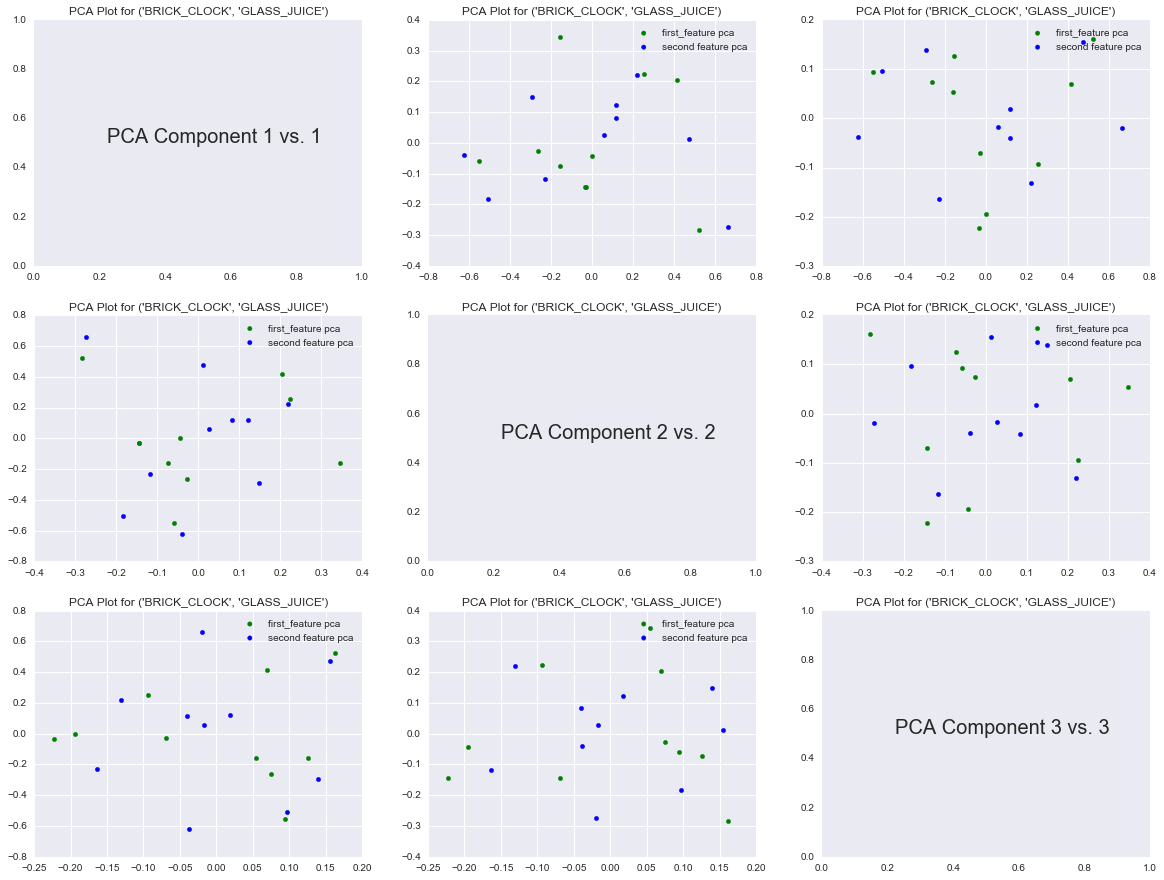

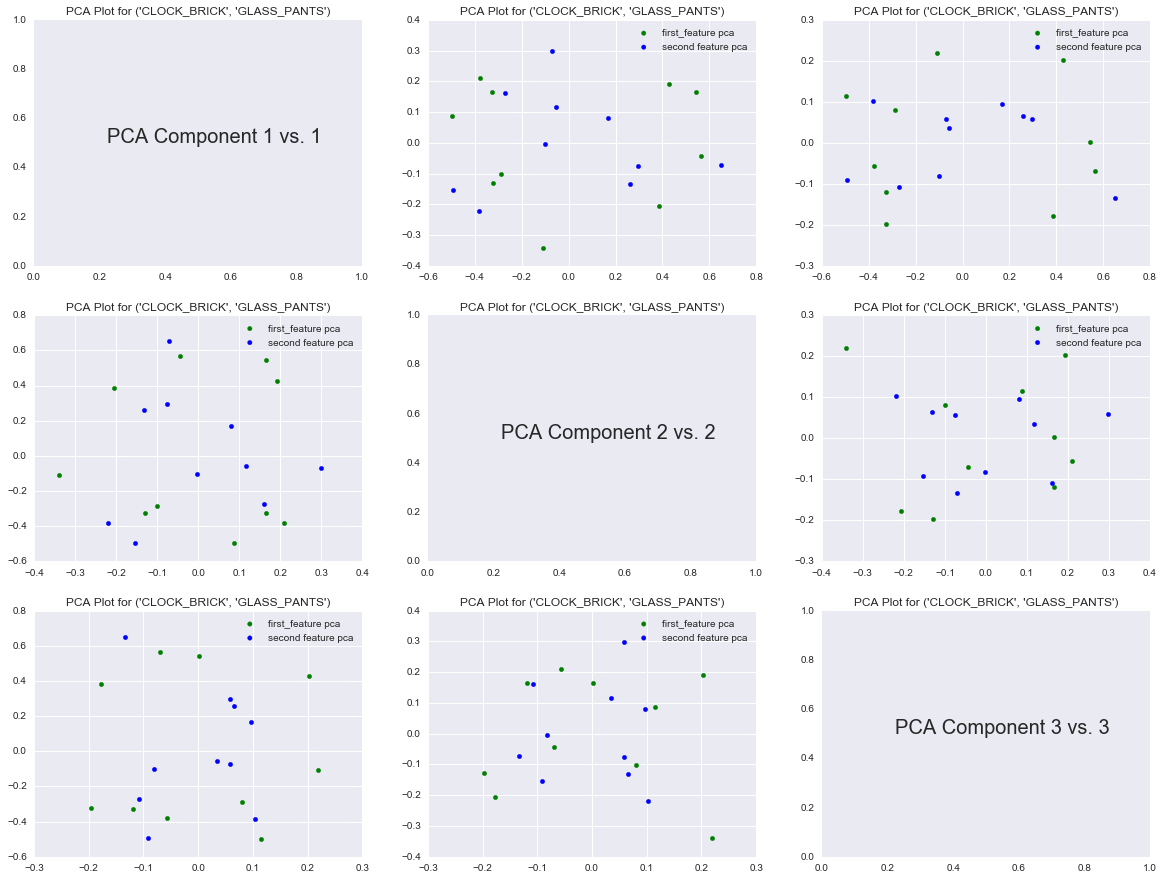

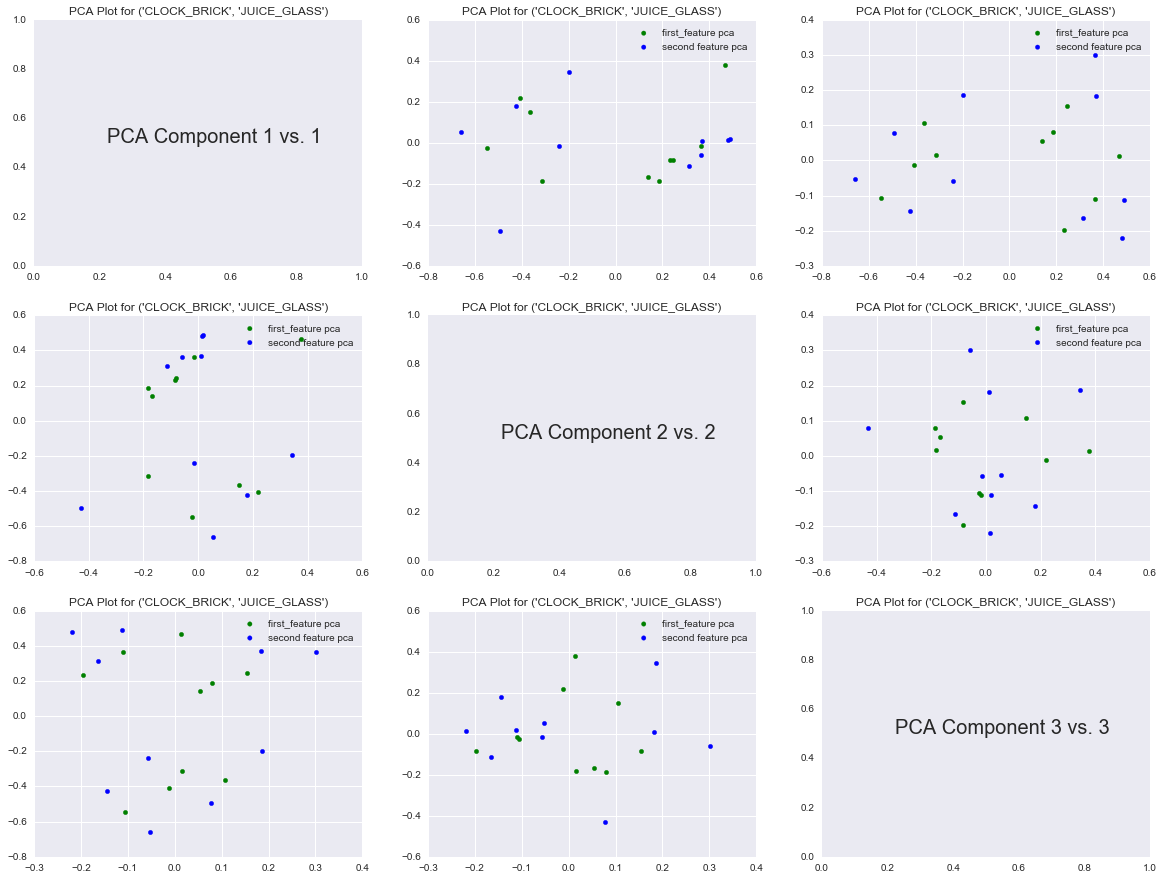

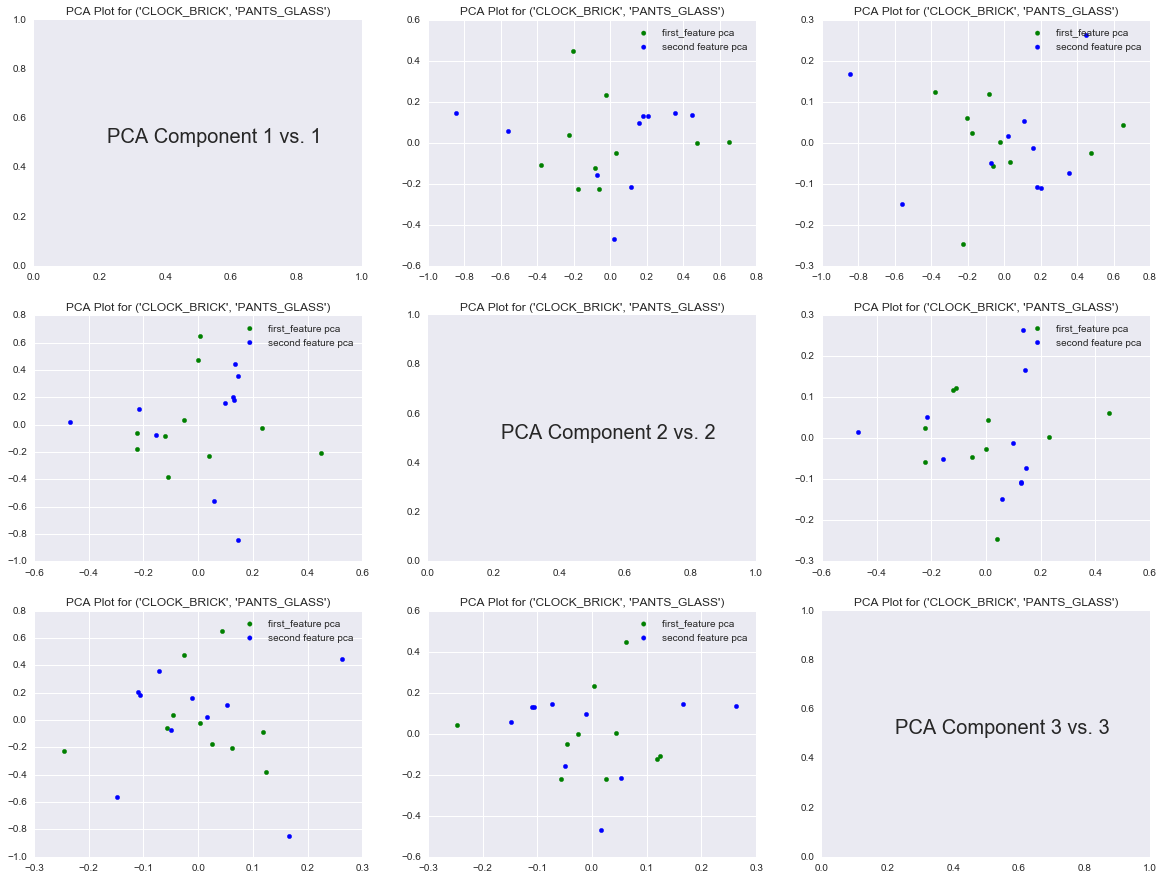

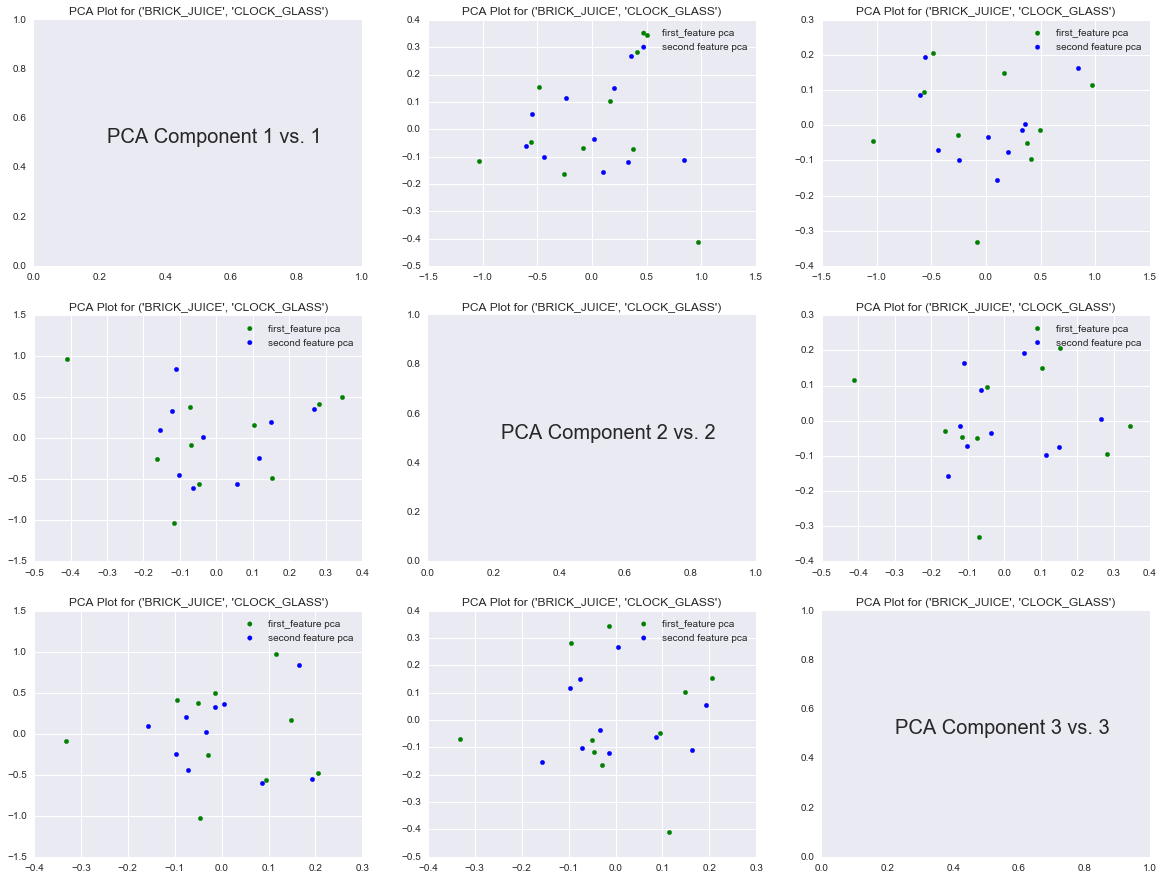

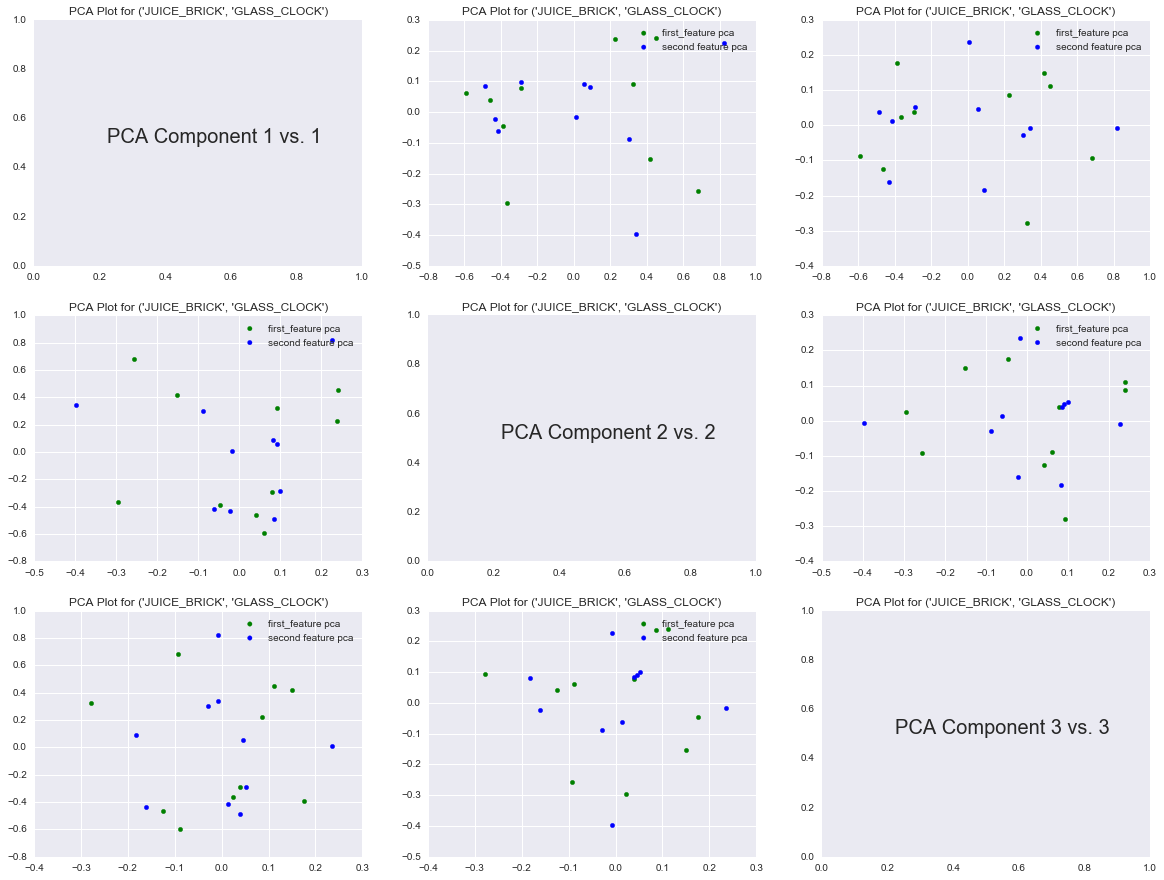

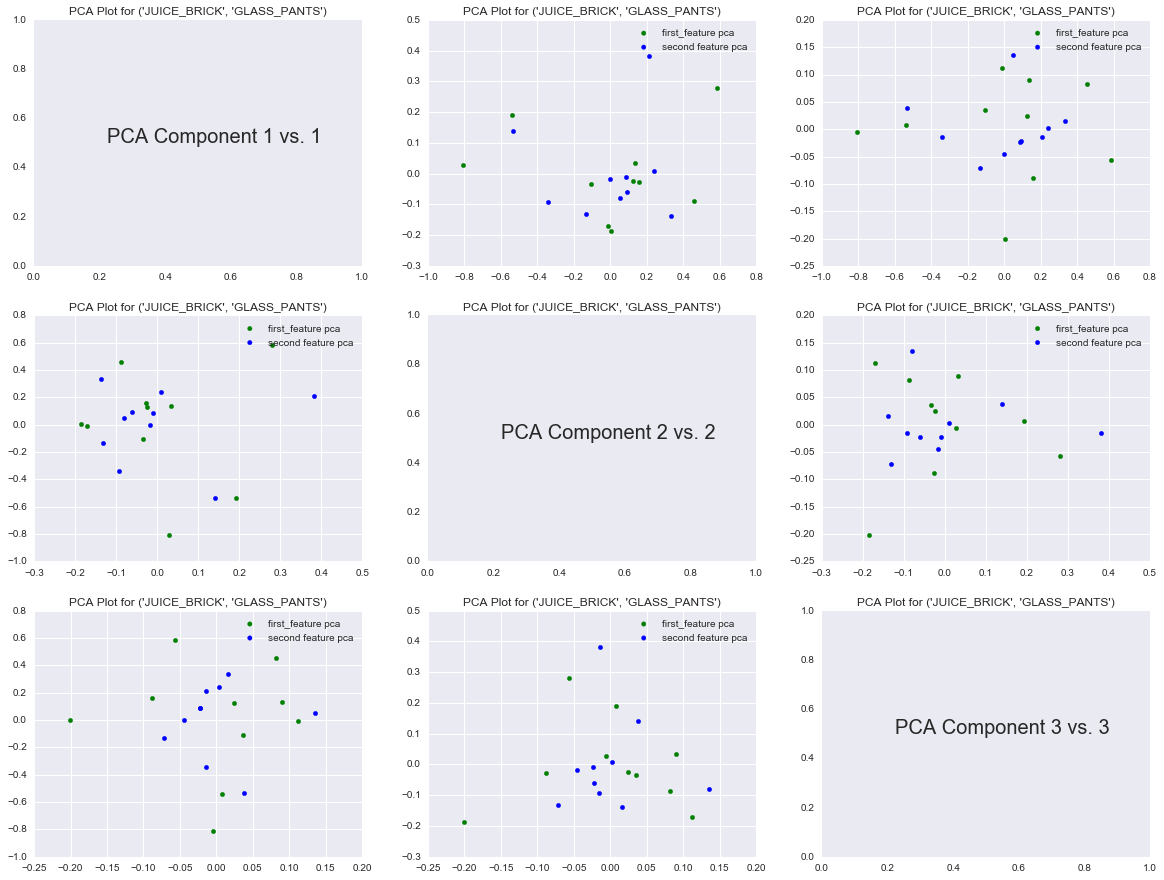

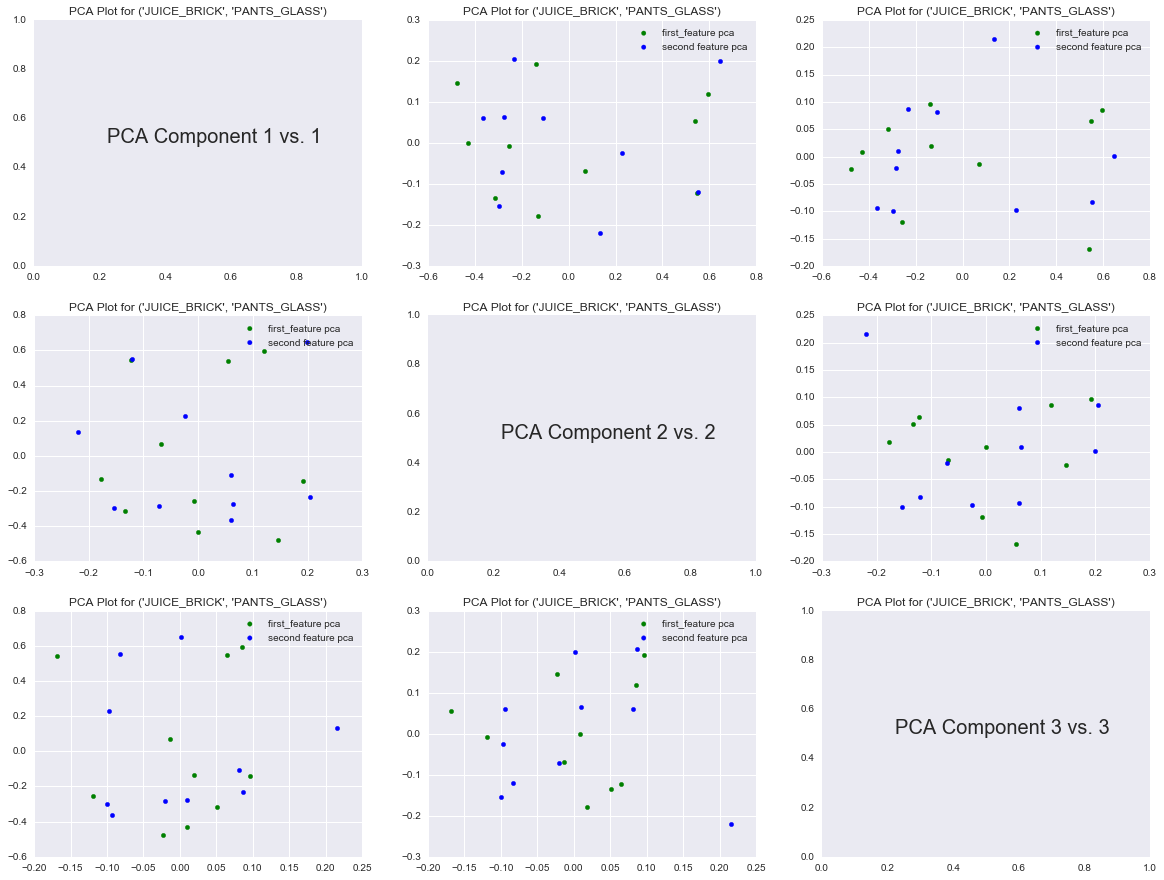

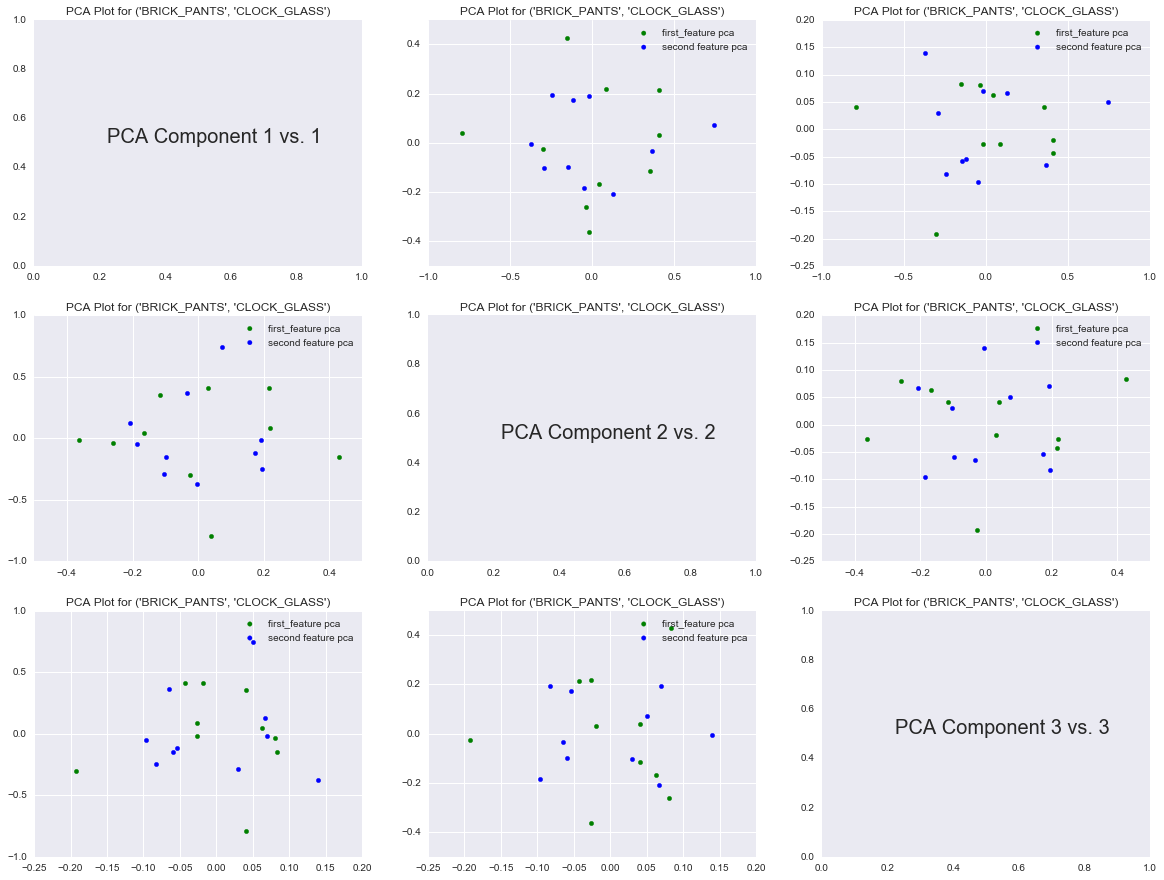

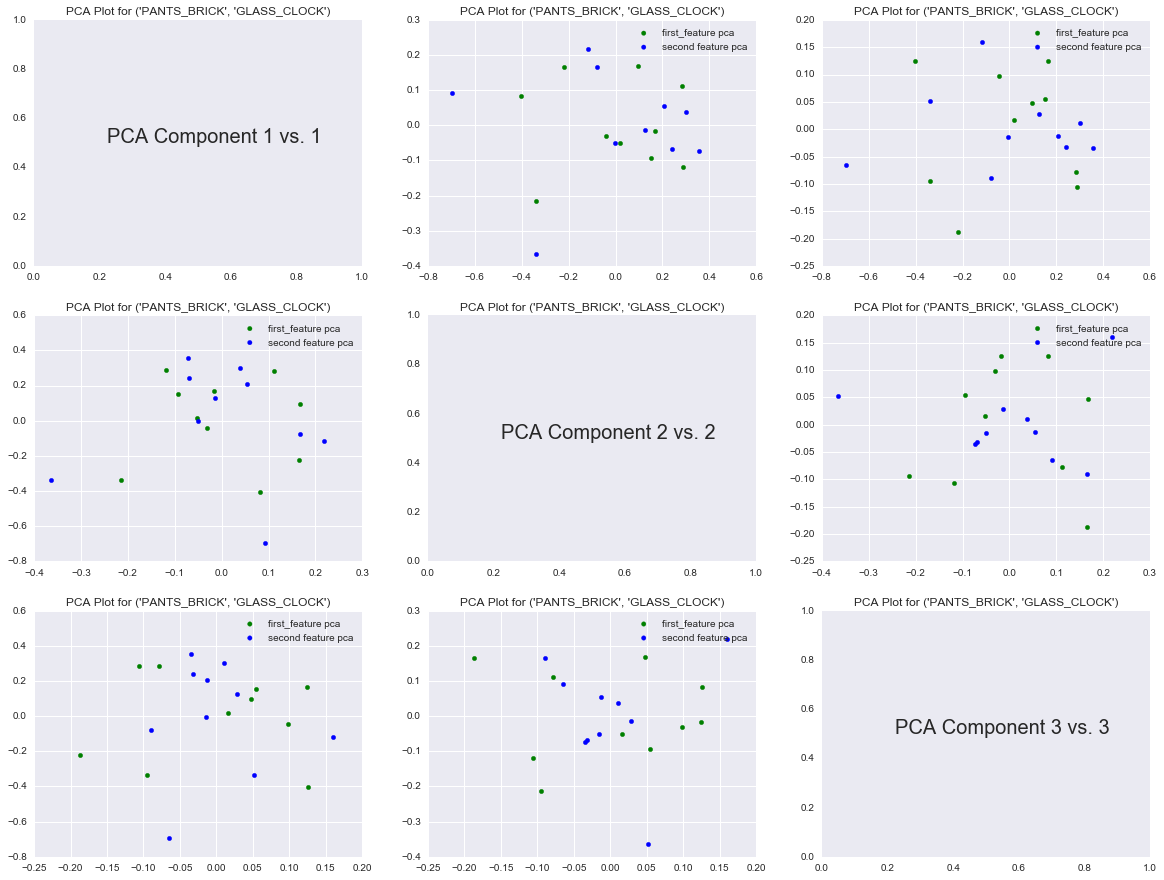

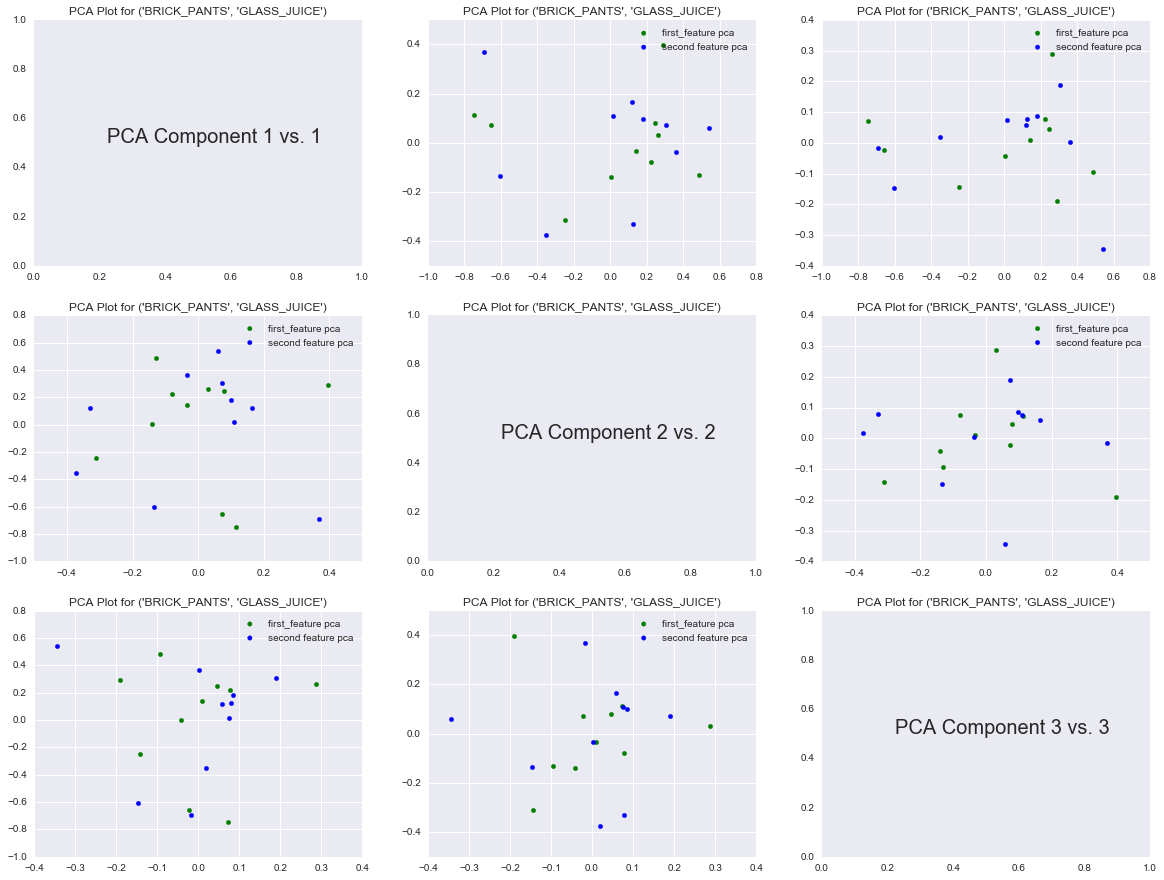

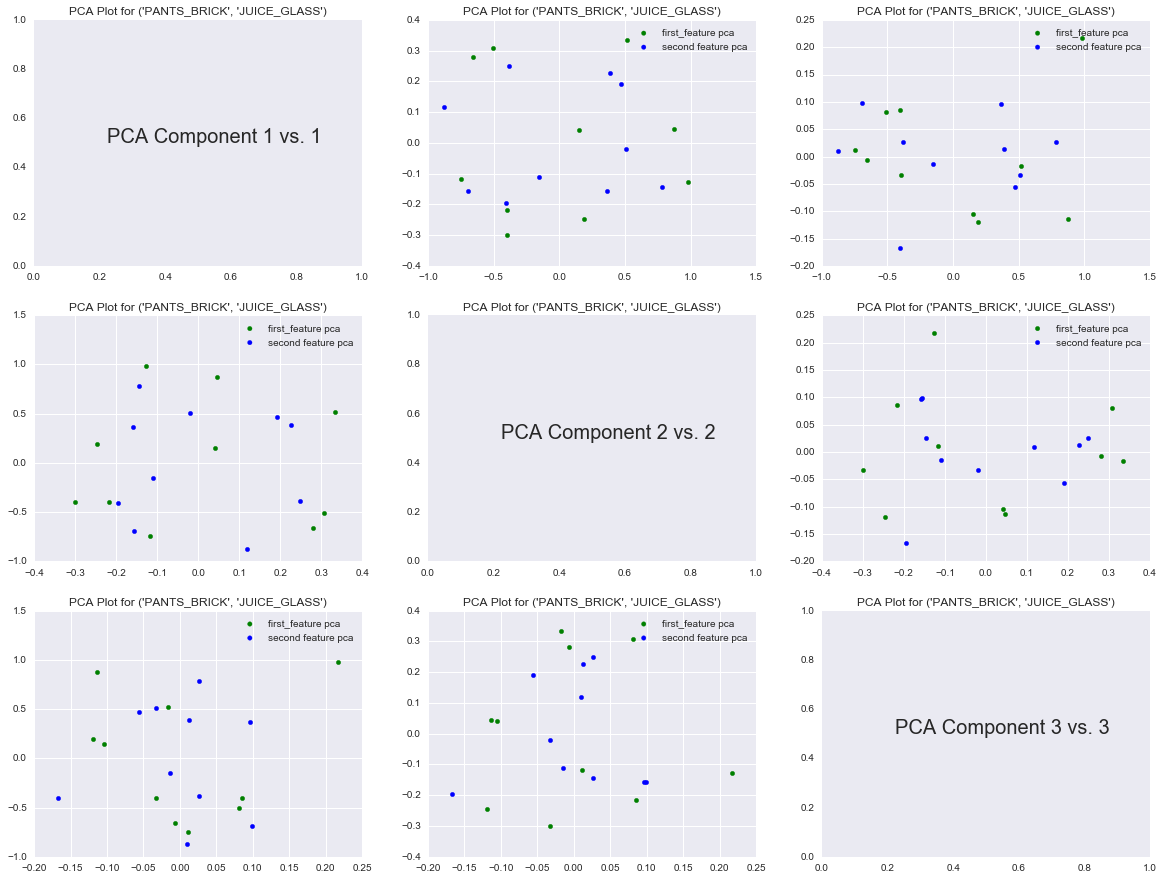

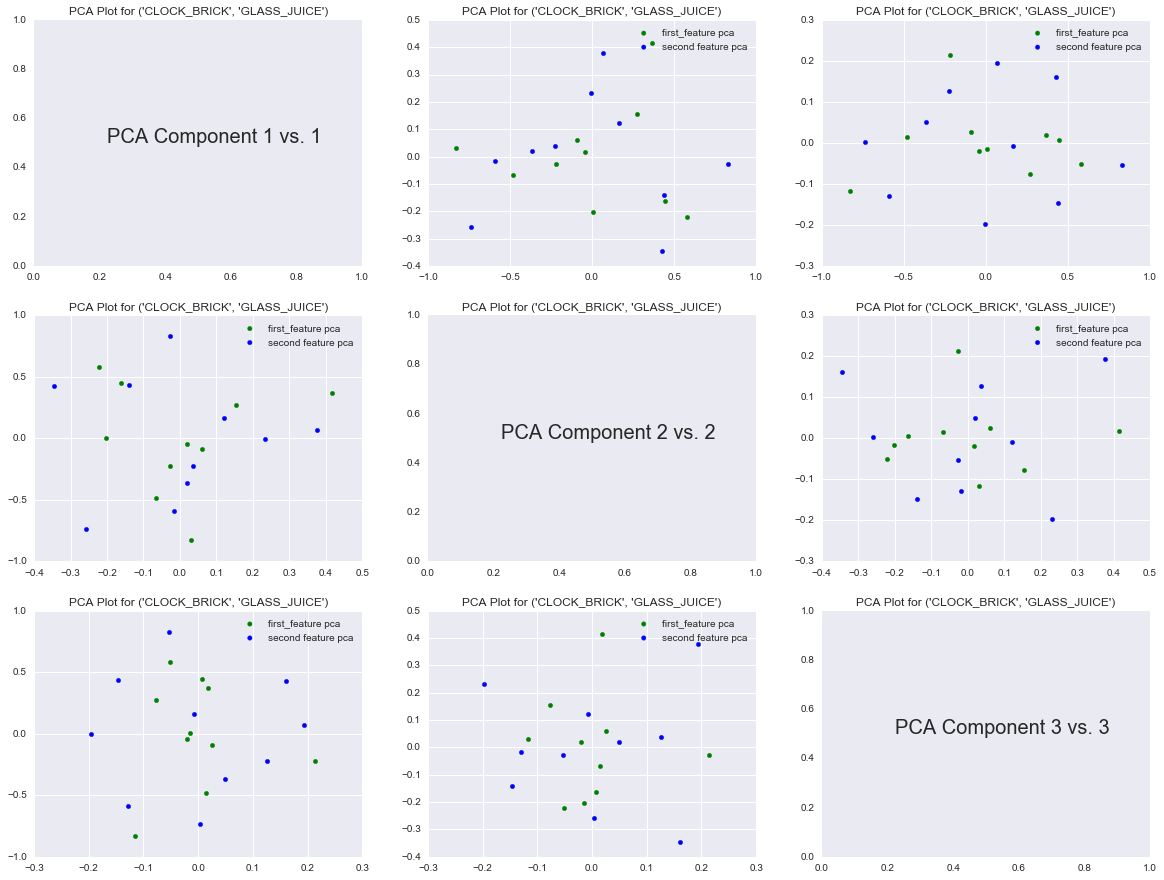

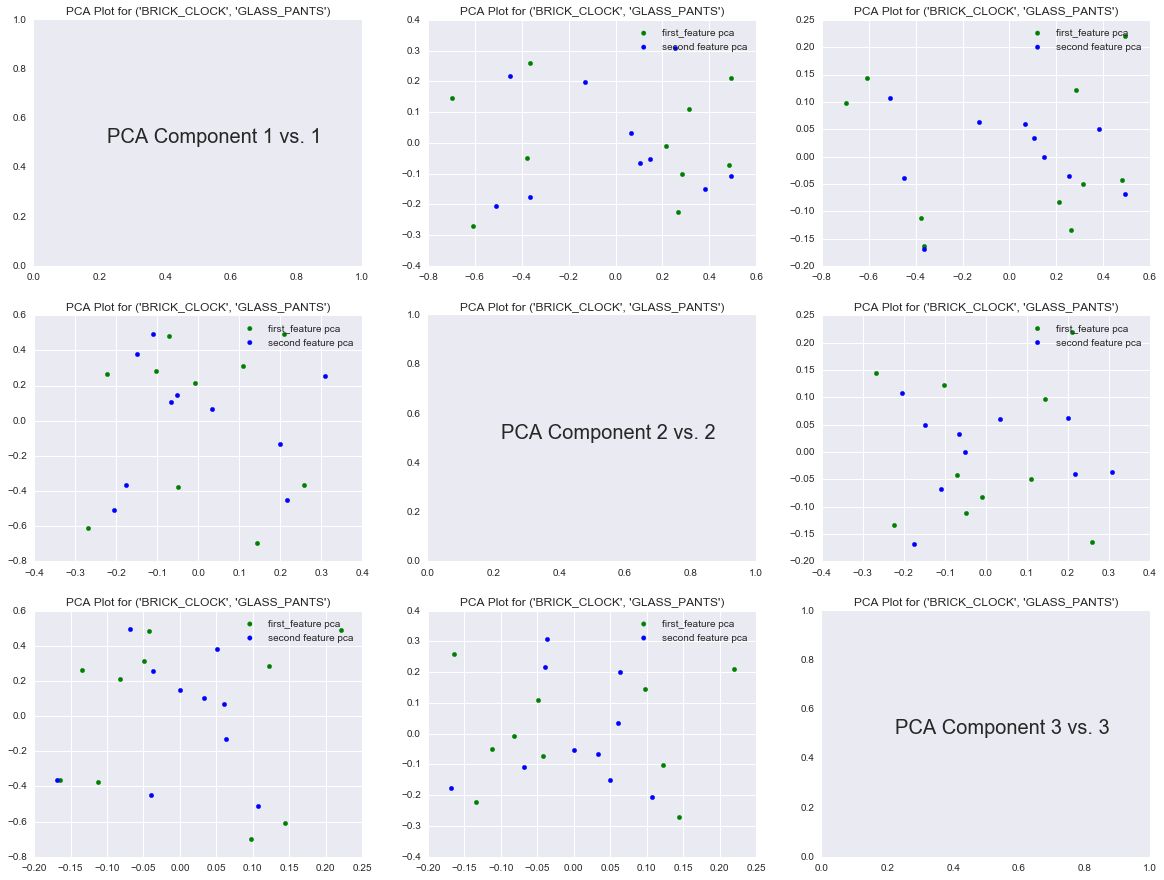

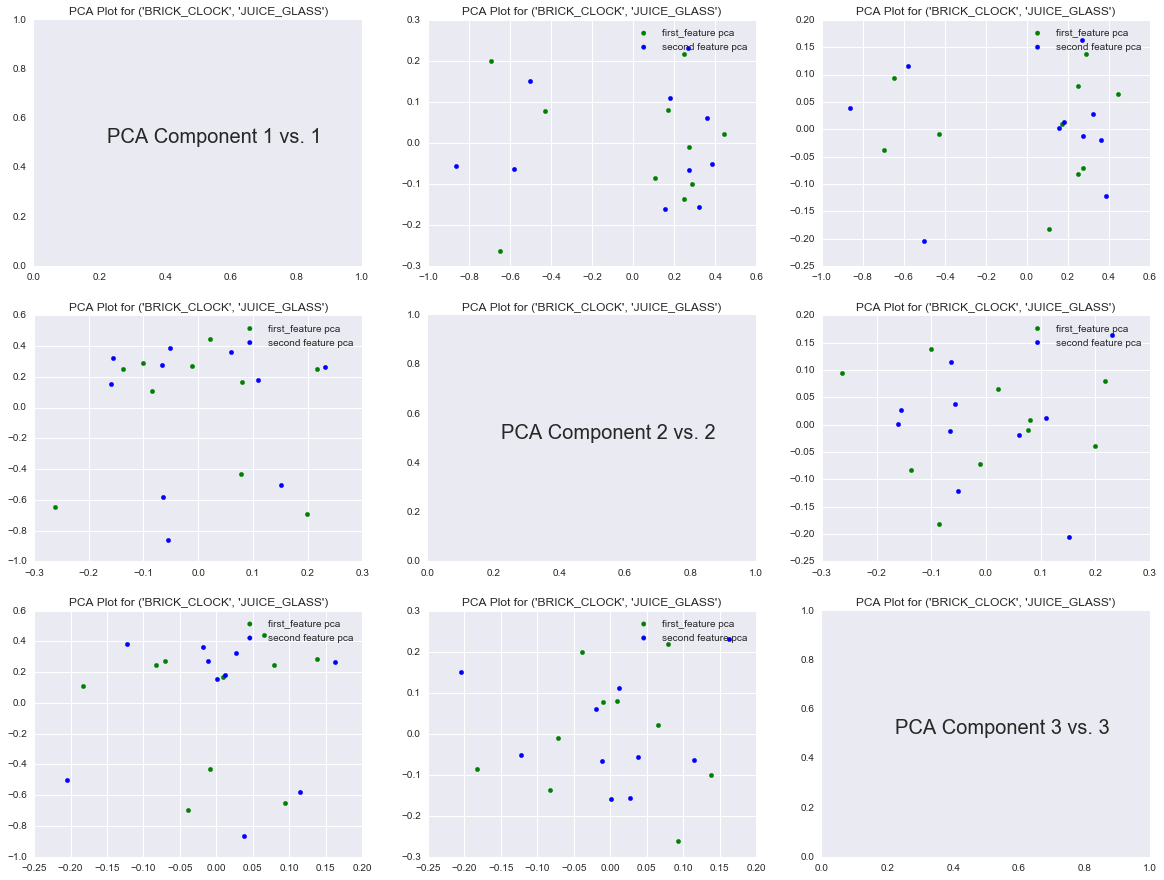

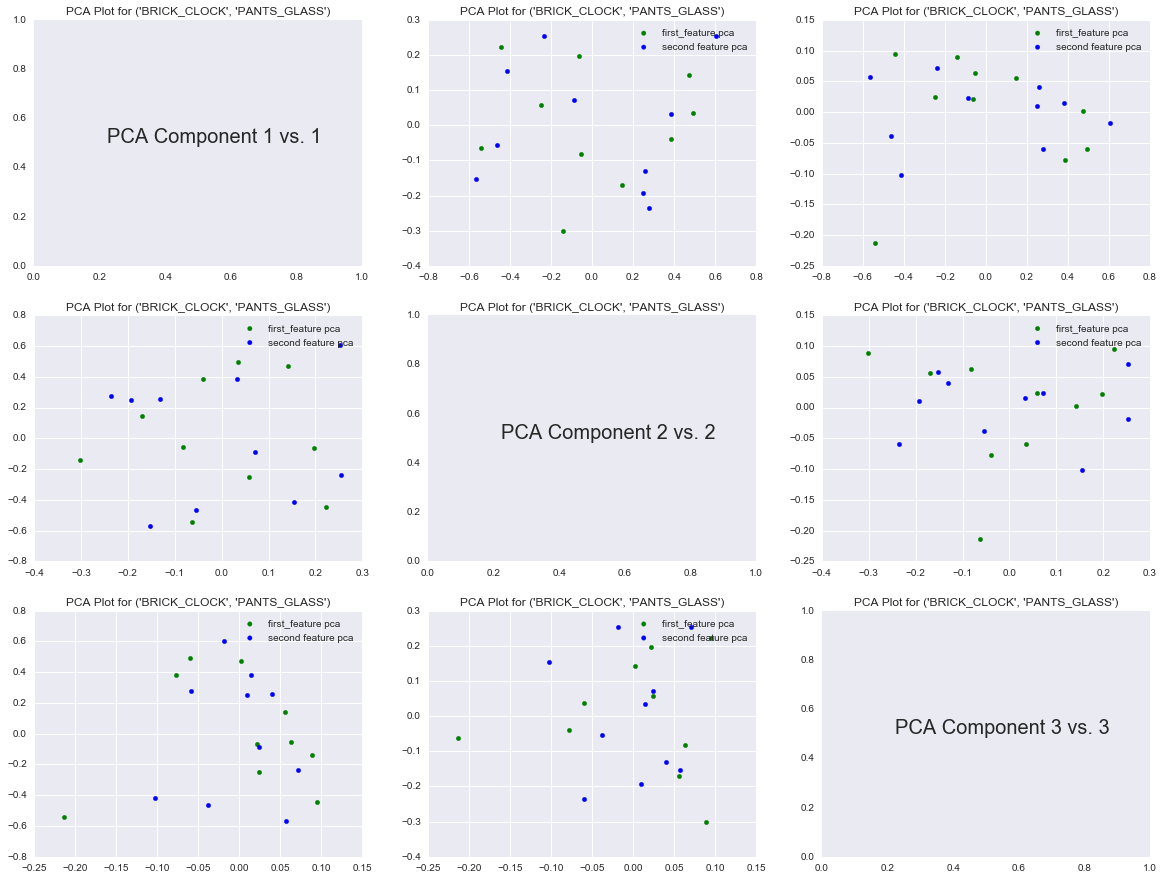

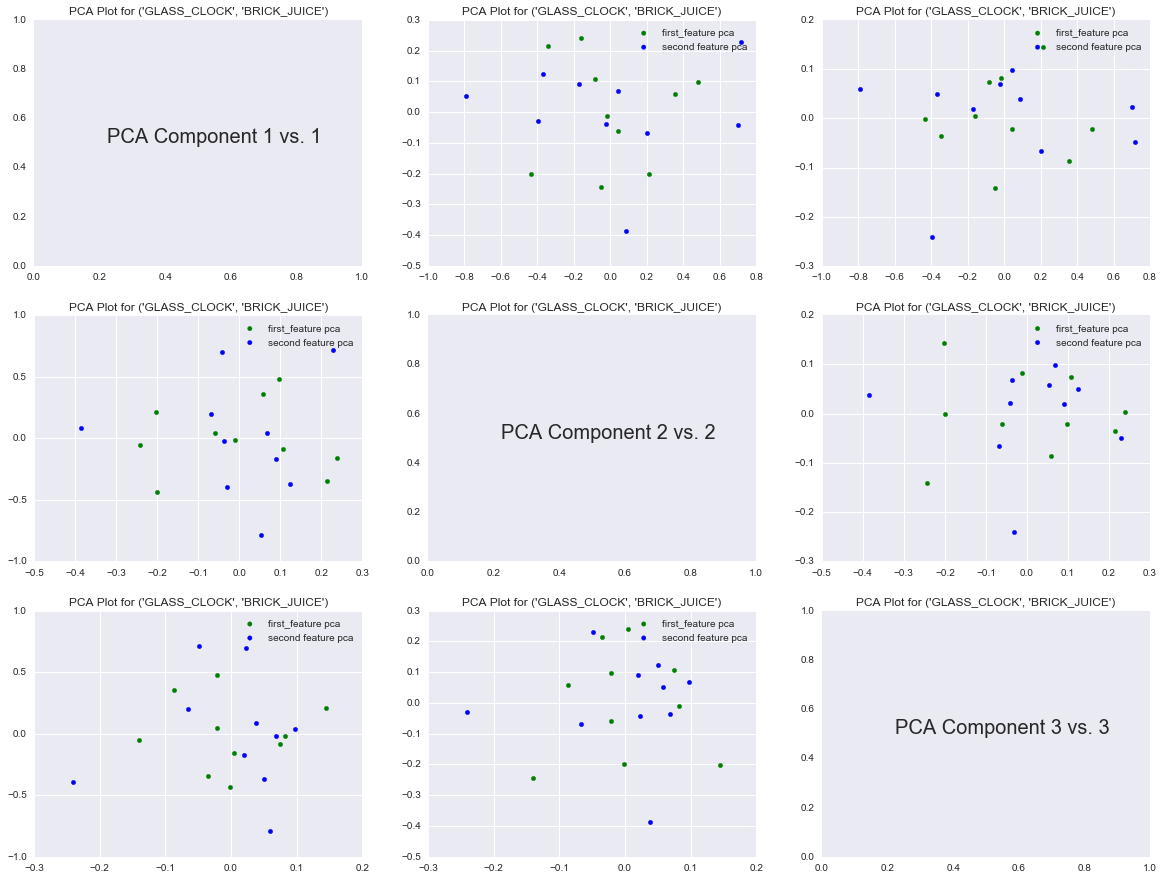

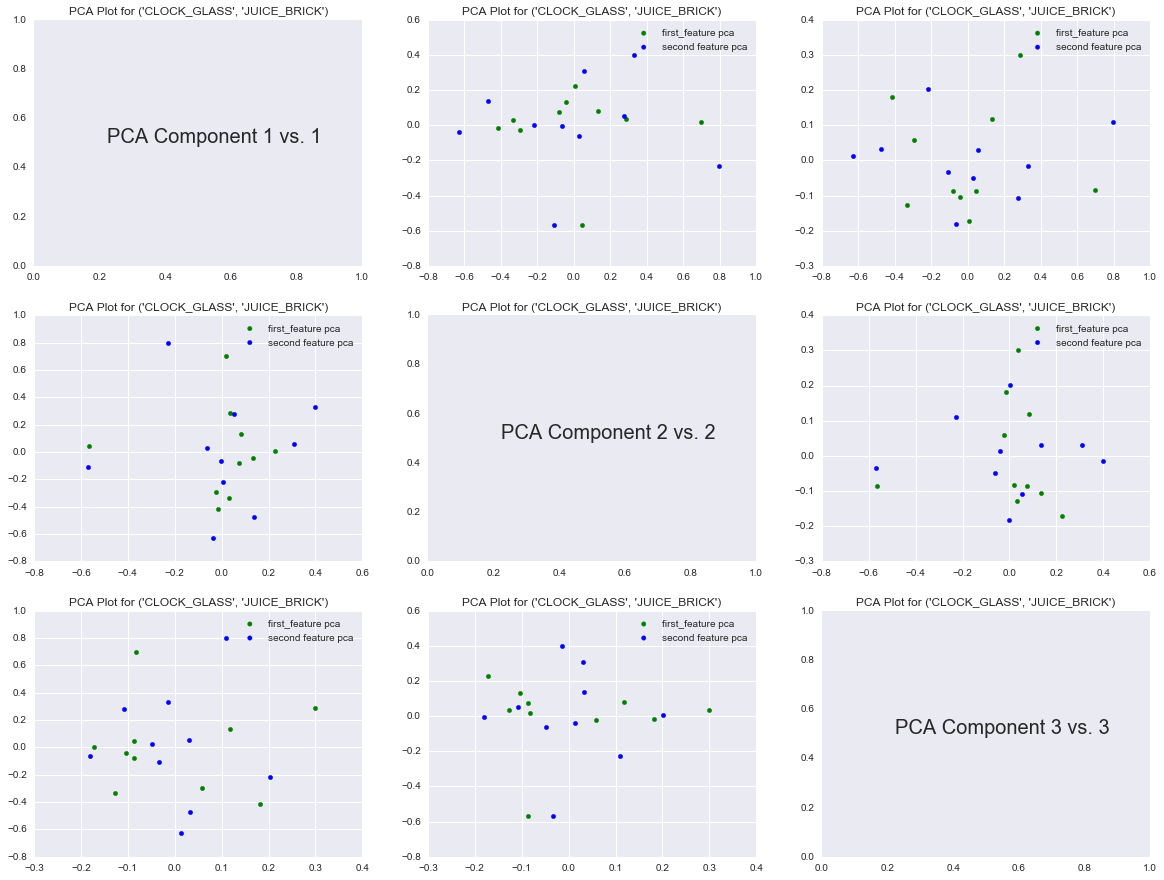

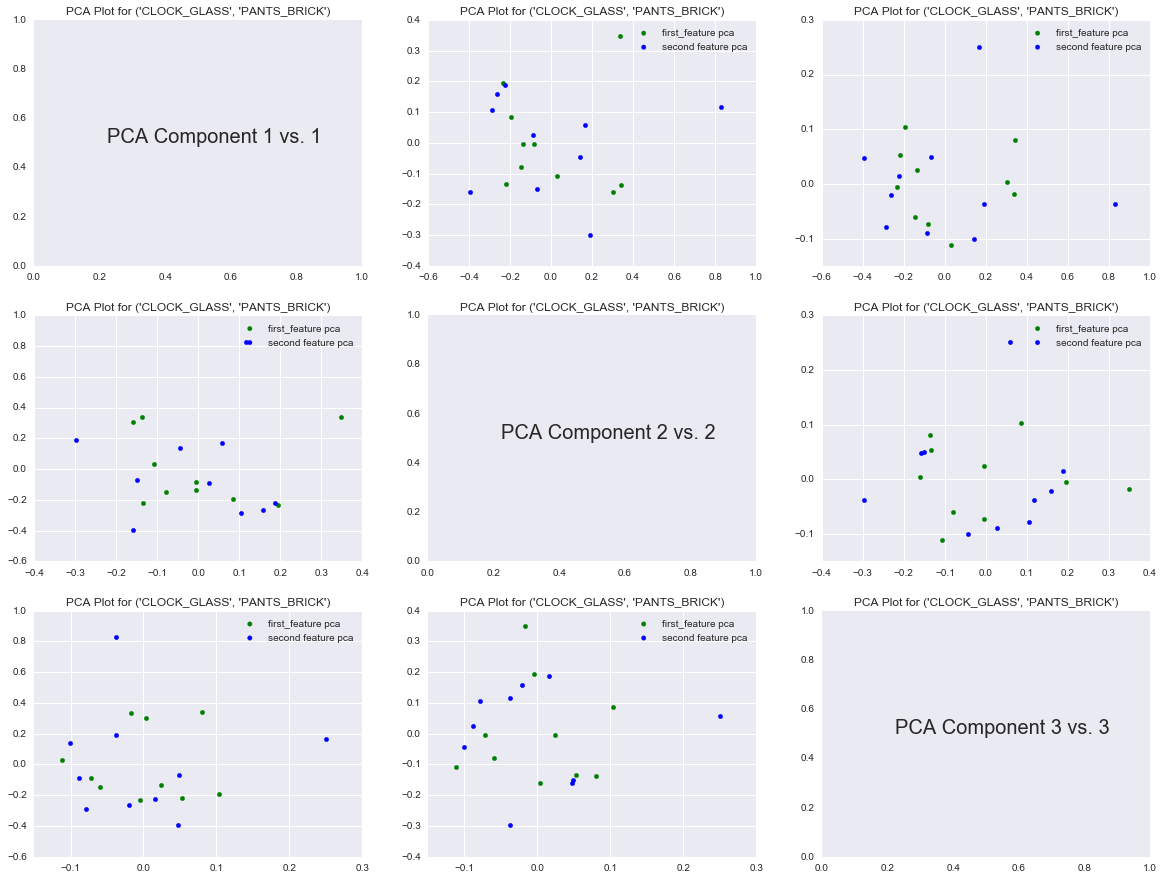

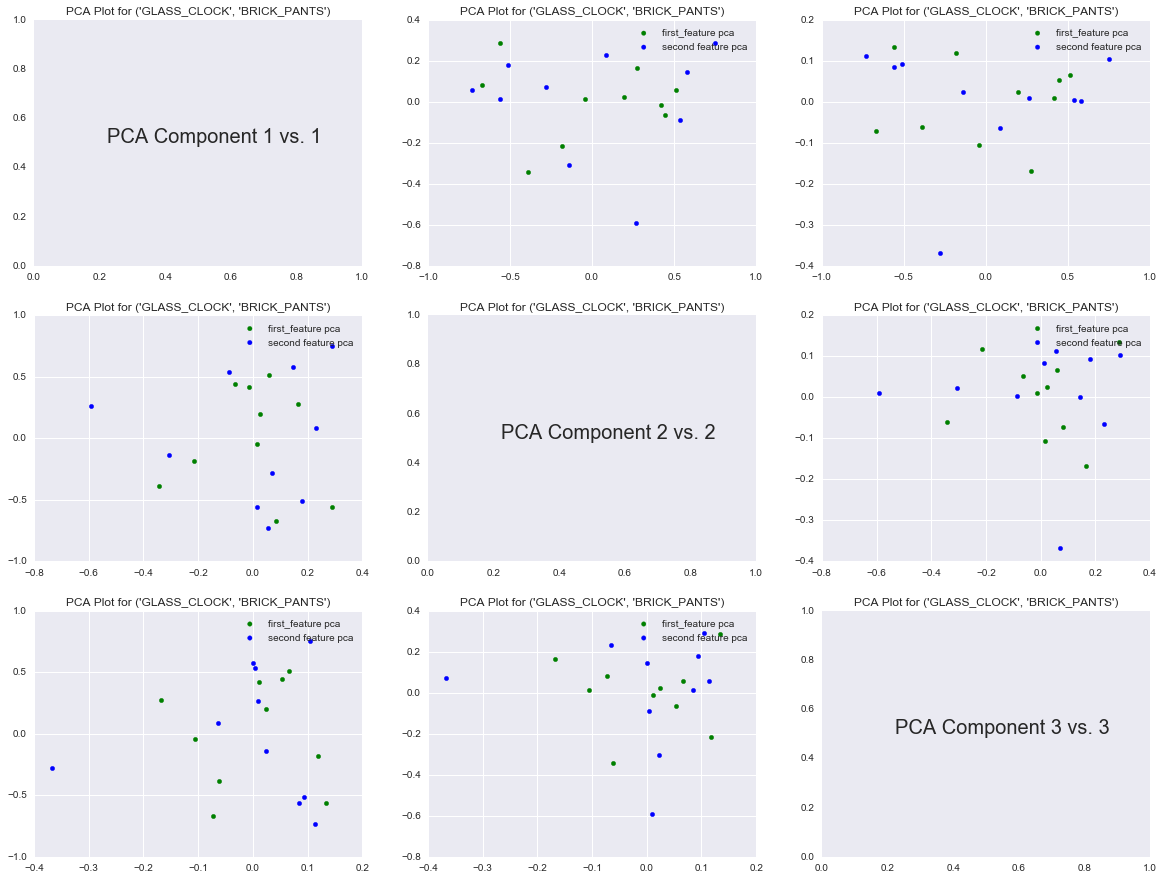

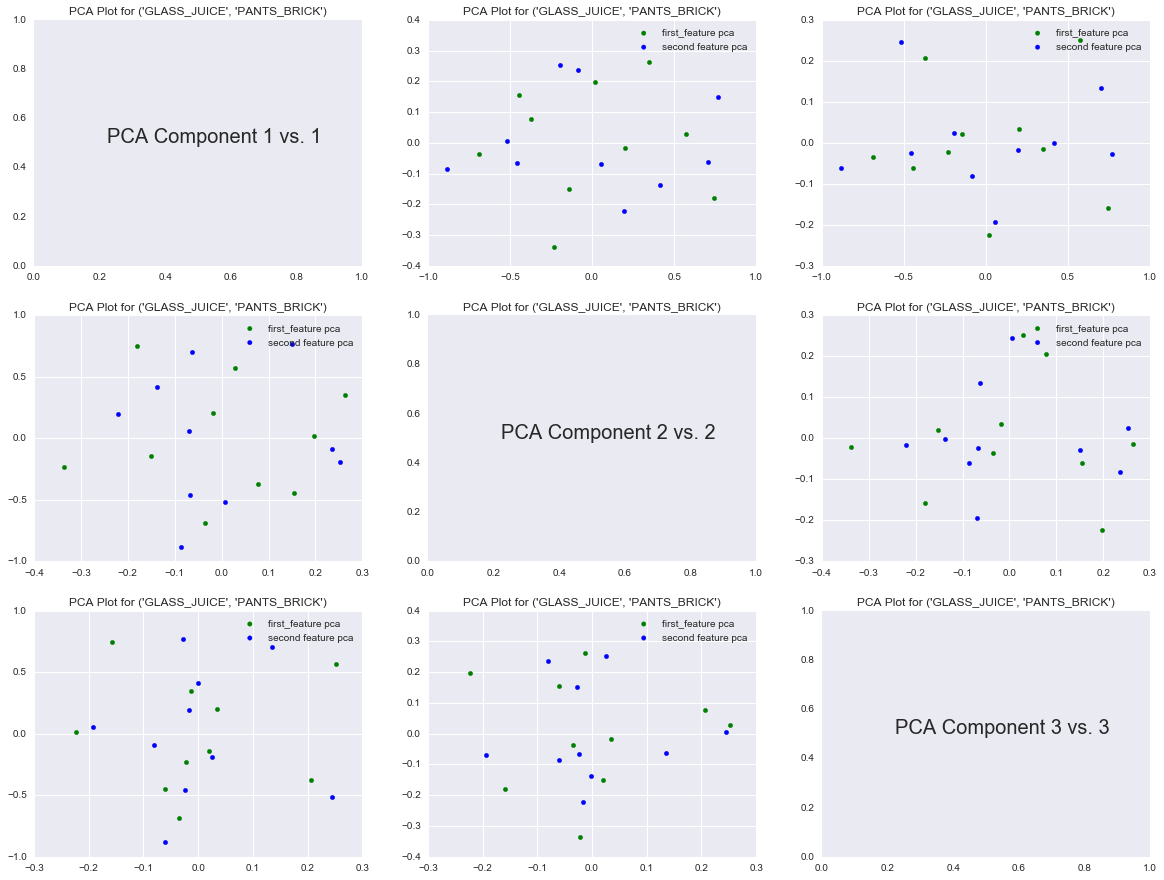

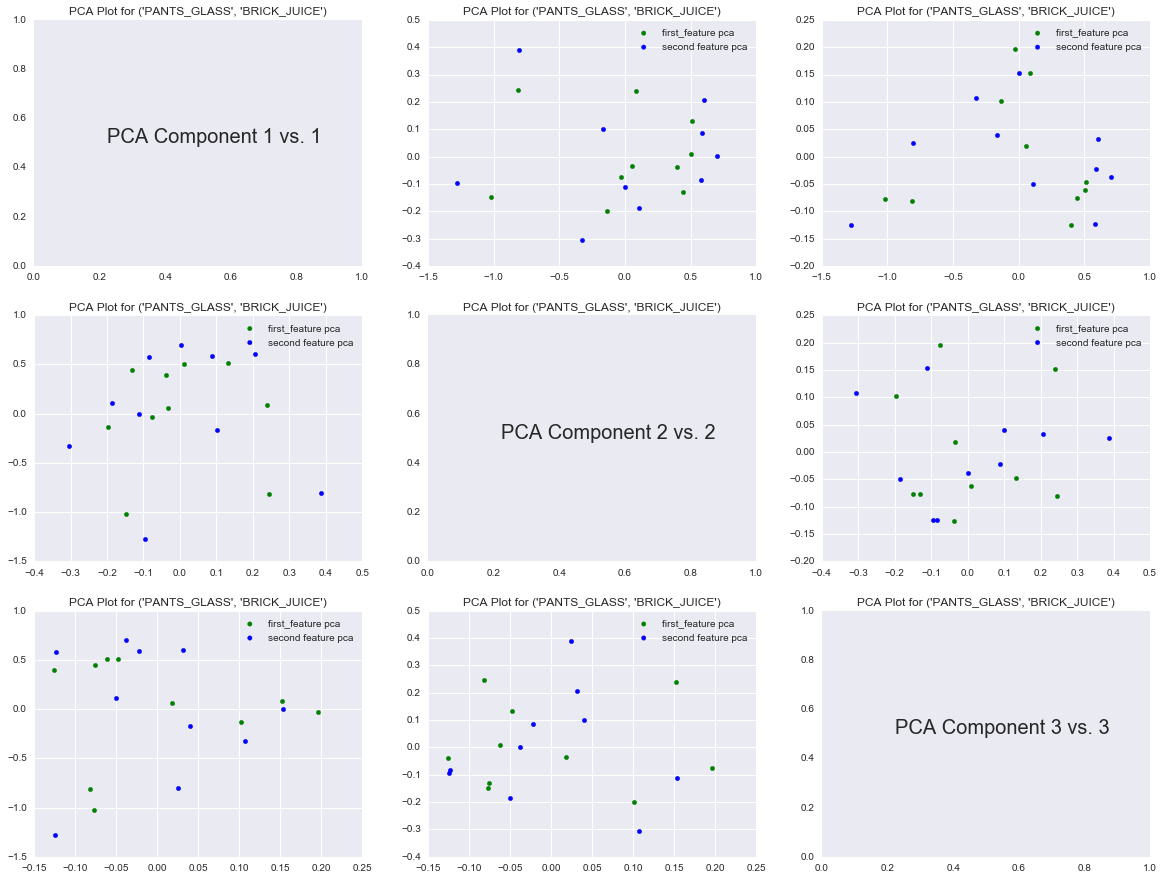

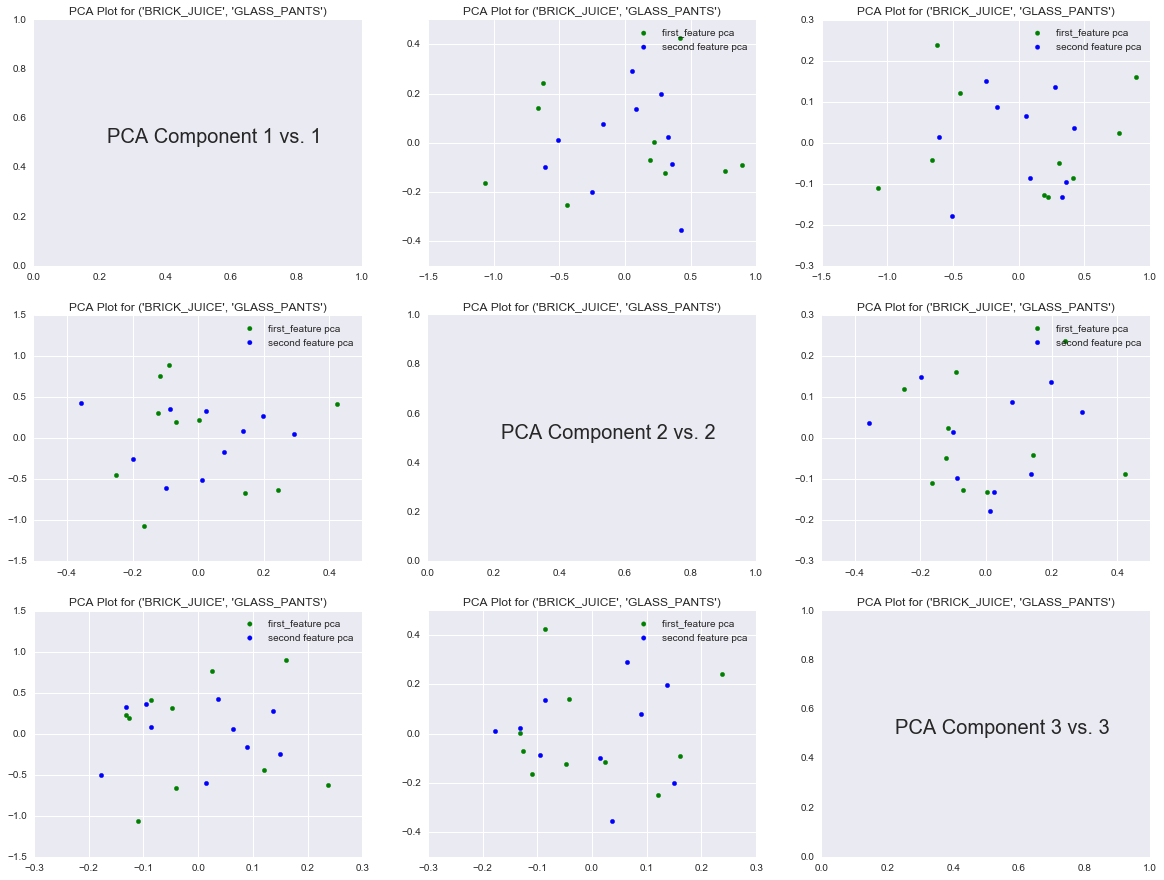

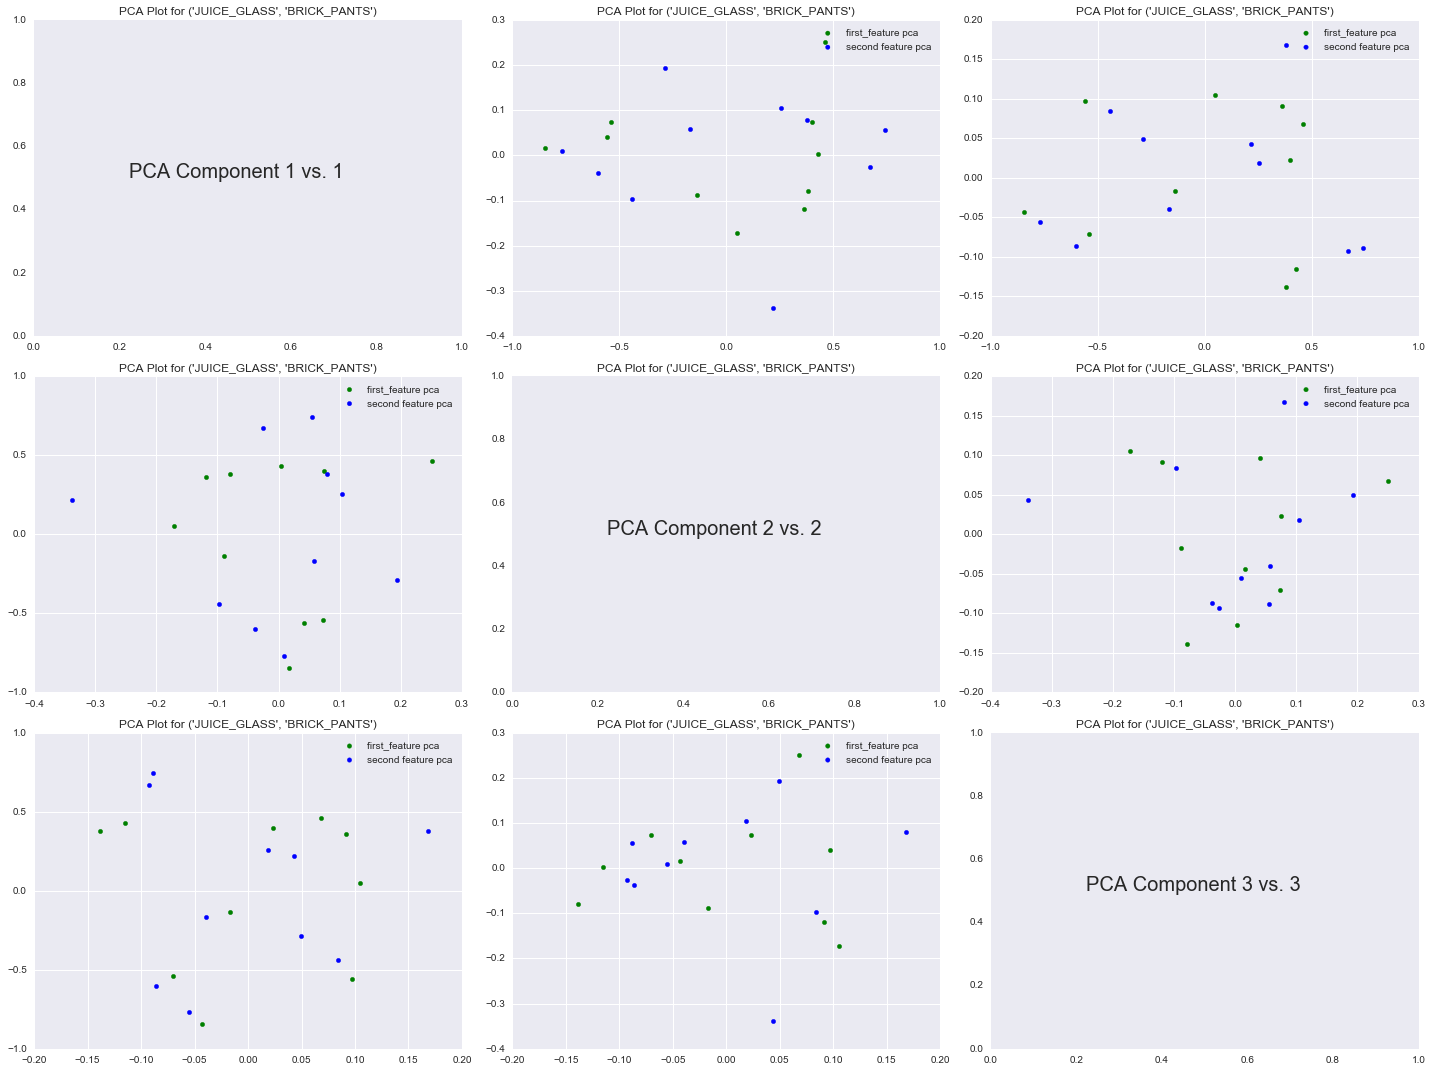

In [38]:
## plot all in pca space vs. another
num_groups = len(diff_words_groups)
# fig = plt.figure(figsize=(7, 5*num_groups))

for idx, group in enumerate(diff_words_groups):
    
    ######## Get list of files (.mat) we want to work with ########
    first_filedir = '../condensed_data/groups/' + group[0] + '/'
    second_filedir = '../condensed_data/groups/' + group[1] + '/'

    # get list of files for both word pairs
    first_files = []
    second_files = []
    
    files01 = os.listdir(first_filedir)
    files02 = os.listdir(second_filedir)
    for i in range(0, len(files01)):
        if files01[i].endswith('.mat'):
            first_files.append(files01[i])
        if files02[i].endswith('.mat'):
            second_files.append(files02[i])

    chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
#     chans_to_analyze = str(np.arange(1,97,1))
    
    ################## LOOPING THROUGH EACH CHANNEL ##################
    first_feature = []
    second_feature = []
    for f in range(0, len(first_files)):
        # make sure this is a channel we want
        chan_num = first_files[f].split('_')[0]
        
        if chan_num in chans_to_analyze:
            #################### Set up data from the channel's mat file ####################
            # Go through each .mat file
            first_mat_file = first_filedir + first_files[f]
            second_mat_file = second_filedir + second_files[f]

            data_first = scipy.io.loadmat(first_mat_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_mat_file)
            data_second = data_second['data']

            ## 01: Grab probewords for each struct
            first_probeWord = data_first['probeWord'][0][0][0]
            second_probeWord = data_second['probeWord'][0][0][0]

            ## 02: Grab targetwords for each struct
            first_targetWord = data_first['targetWord'][0][0][0]
            second_targetWord = data_second['targetWord'][0][0][0]

            ## 03: get channel number
            first_chanNum = data_first['chanNum'][0][0][0][0]
            second_chanNum = data_second['chanNum'][0][0][0][0]

            ## 04: get channel string
            first_chanStr = data_first['chanStr'][0][0][0]
            second_chanStr = data_second['chanStr'][0][0][0]

            ## 05: get power matrix Z is a #events X #freq. bands X #time bins
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]

            ## 06: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 07: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]
        
            ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
            ### 01: create power matrix with only delta, theta and high gamma
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]
        
            ### 02: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
#                 first_mean.append(np.mean(first_matrix[i,:,first_vocalization[i]-10:first_vocalization[i]], axis=1))
                
                first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.mean(second_matrix[i,:,second_vocalization[i]-10:second_vocalization[i]], axis=1))
                
                second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))
               
            # append the averaged time and event vector = frequency band feature
            first_feature.append(np.mean(first_mean,axis=0))
            second_feature.append(np.mean(second_mean,axis=0))
                
        #### end of if/else
    #### end of for loop
    
    ### 03: after looping through all significant channels, create list of feature vectors from each channel
    first_feature = np.array(first_feature)
    second_feature = np.array(second_feature)
    
    ### 04: PCA On Features
    pca = PCA(n_components=3)
    first_pca = pca.fit_transform(first_feature)
    second_pca = pca.fit_transform(second_feature)
    
    # compute freqX1 centroid vector
#     first_centroid = np.mean(first_feature,axis=0)
#     second_centroid = np.mean(second_feature,axis=0)
     
#     # compute list of distances from other centroid
#     first_hist = np.array([distances(x, second_centroid) for x in first_pca])
#     second_hist = np.array([distances(x, first_centroid) for x in second_pca])
    
#     print first_feature.shape
#     print second_feature.shape
#     print first_hist.shape
#     print second_hist.shape
#     print first_pca.shape
#     print second_pca.shape
#     break
    
    plt.figure(figsize=(20,15))
    print 'PCA Plot for ' + str(group)
    pca_plot_i = 1
    for i in range(0, first_pca.shape[1]):
        for j in range(0, first_pca.shape[1]):
            plt.subplot(first_pca.shape[1], first_pca.shape[1], pca_plot_i)
            if i==j:
                axes = plt.gca()
                ymin, ymax = axes.get_ylim()
                xmin, xmax = axes.get_xlim()
                plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'PCA Component %d vs. %d'%(i+1, i+1), fontsize=20)
                plt.title('PCA Plot for ' + str(group))
                plt.grid(False)
            else:
                plt.scatter(first_pca[:,i], first_pca[:,j], color='g', label='first_feature pca')
                plt.scatter(second_pca[:,i], second_pca[:,j], color='b', label='second feature pca')
                plt.title('PCA Plot for ' + str(group))
                plt.legend()
            
            pca_plot_i += 1 # increment index to plot subplot

    
plt.tight_layout()

## Comparing Distances Relatively
Since there is no clear separation among these "different" word groups, I want to look at distances relative to others.

For example, completely different word groups vs. reversed word pair vs. probe word vs. target word vs. same word overlap.

Algorithm:
1. Get all 5 groups into one dictionary
2. loop through that dictionary to get feature vectors
3. concatenate into one feature matrix
4. perform pairwise distance computation
5. plot distance matrix
6. Draw horizontal and vertical lines at the mark for each group

In [22]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 10
freq_bands = [0, 1, 5]
# freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1, 5]
['delta', 'theta', 'high gamma']
The length of the feature vector for each channel will be:  30


12
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)
(10, 30)


/Users/adam2392/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


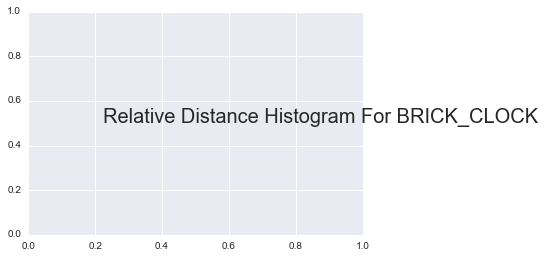

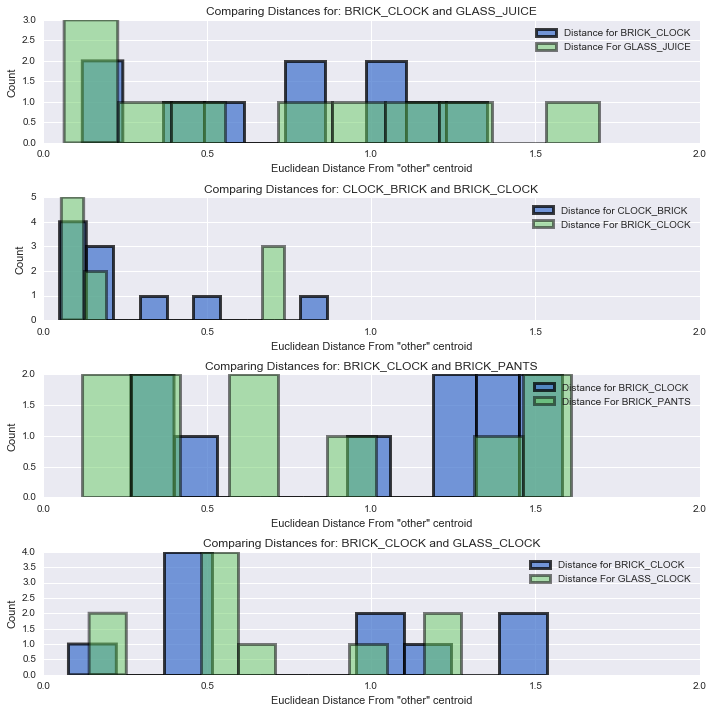

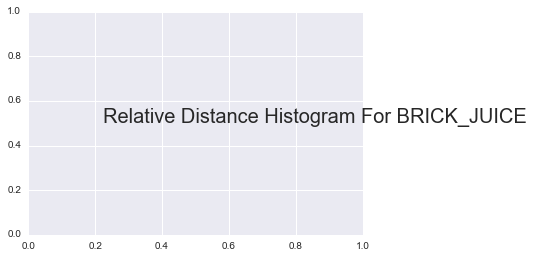

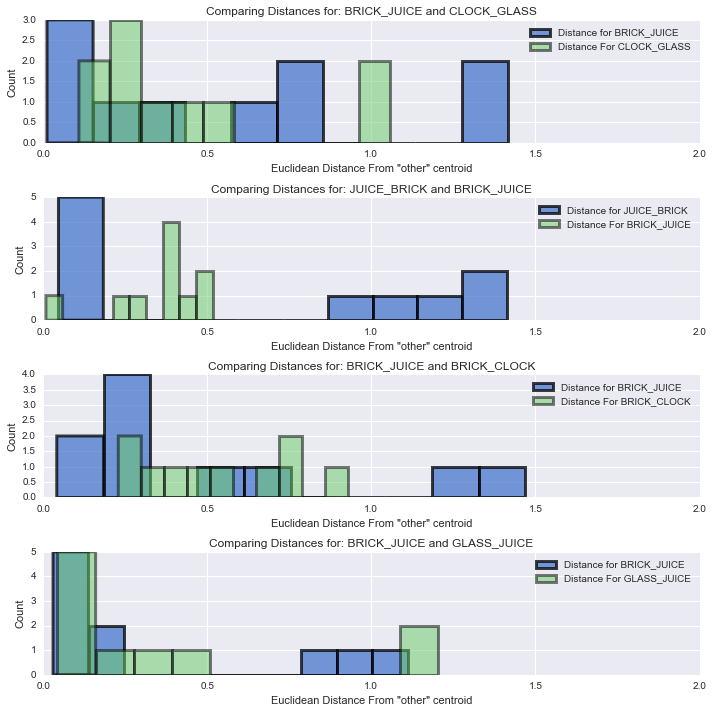

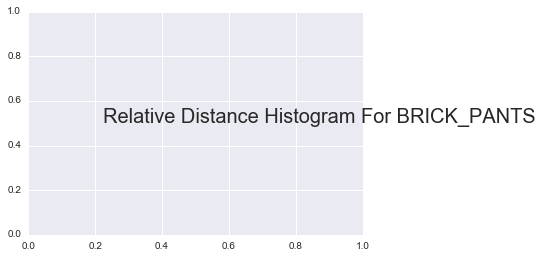

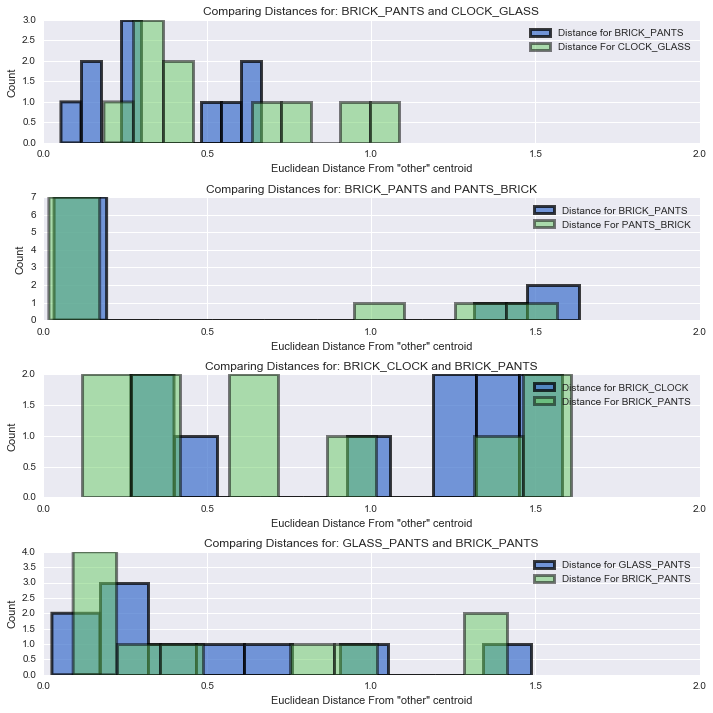

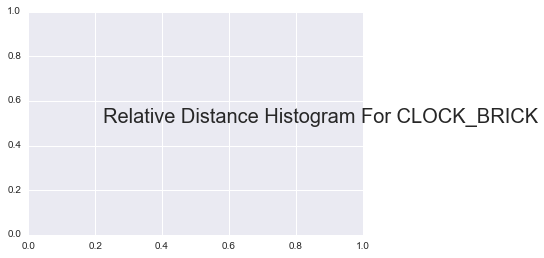

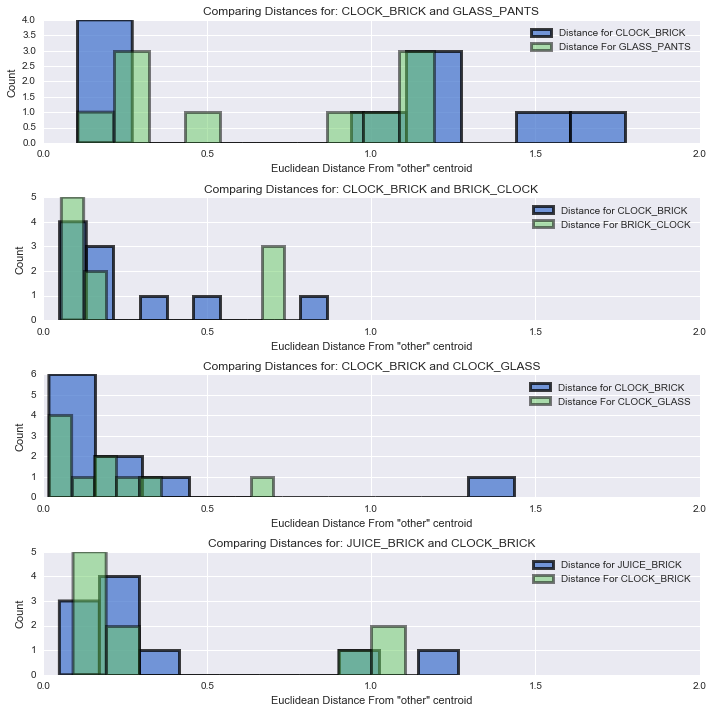

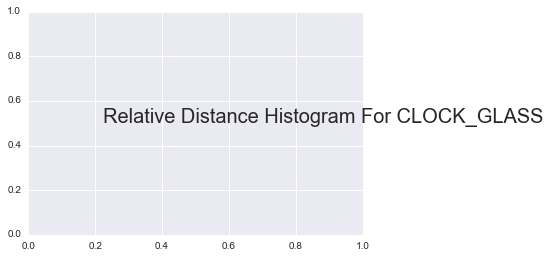

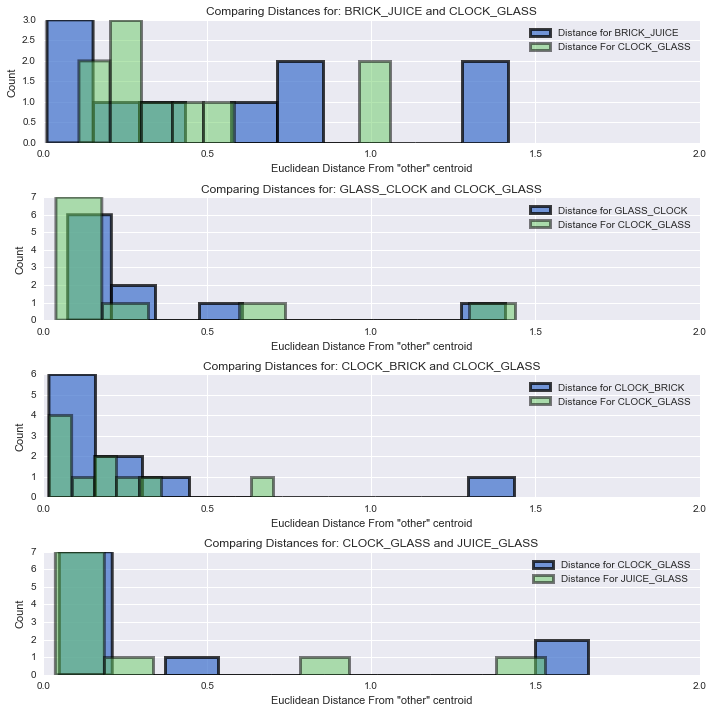

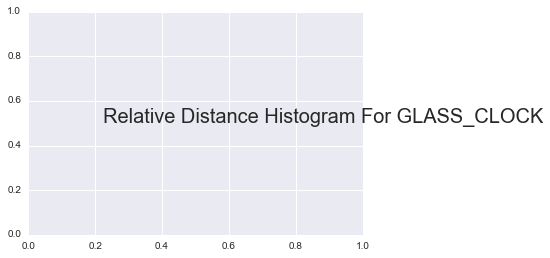

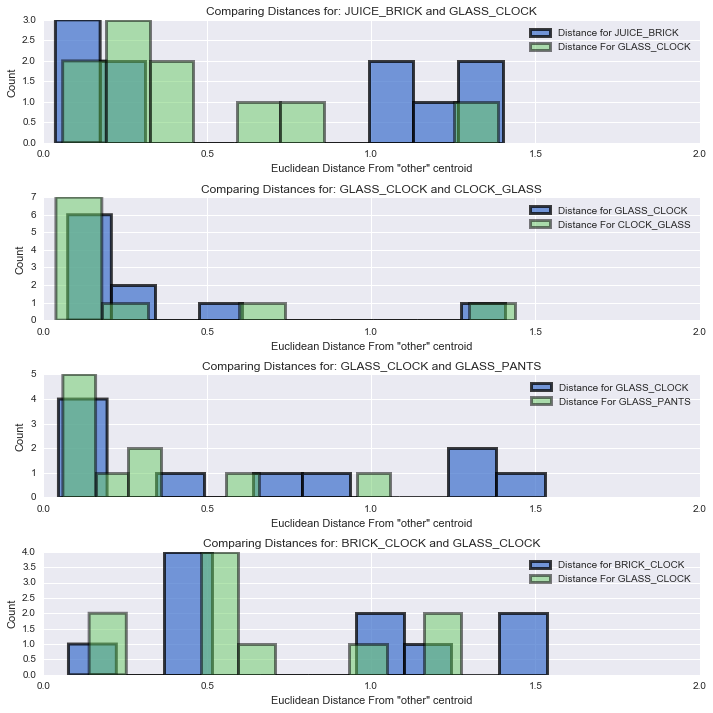

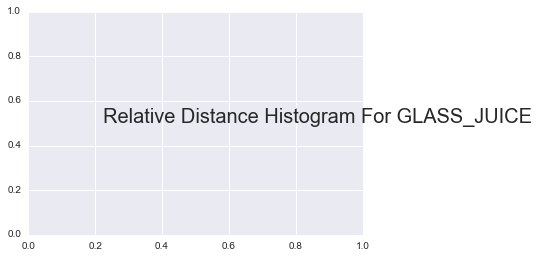

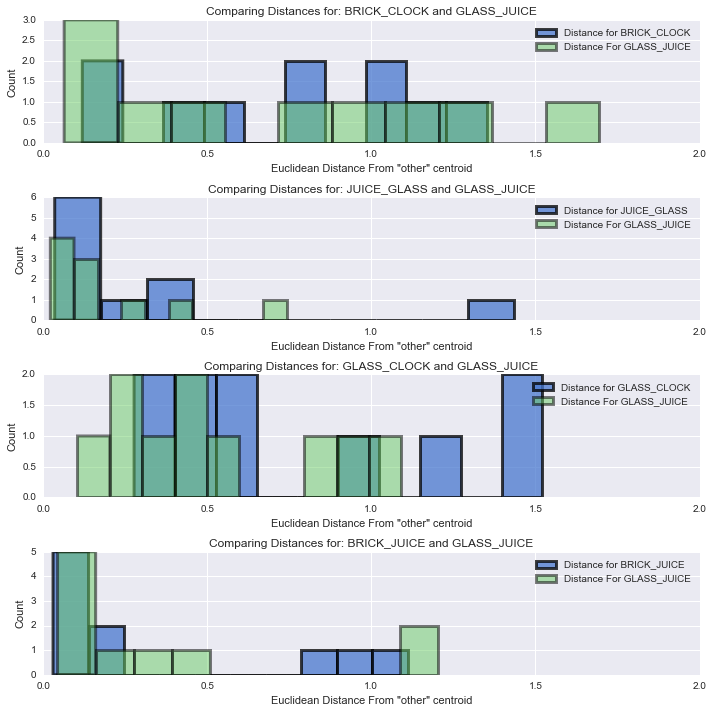

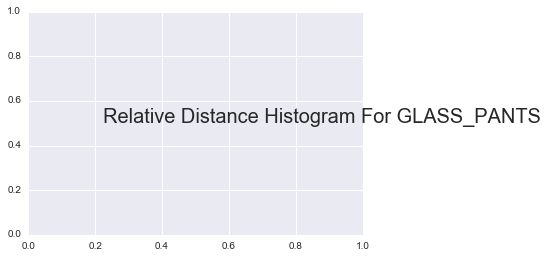

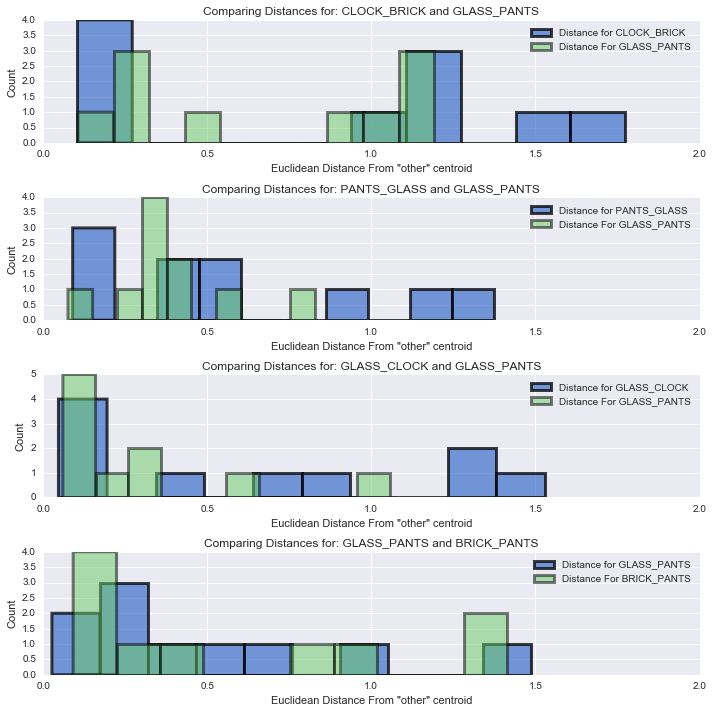

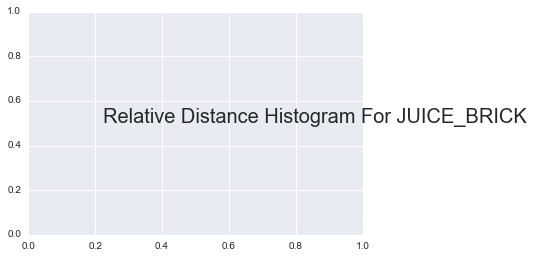

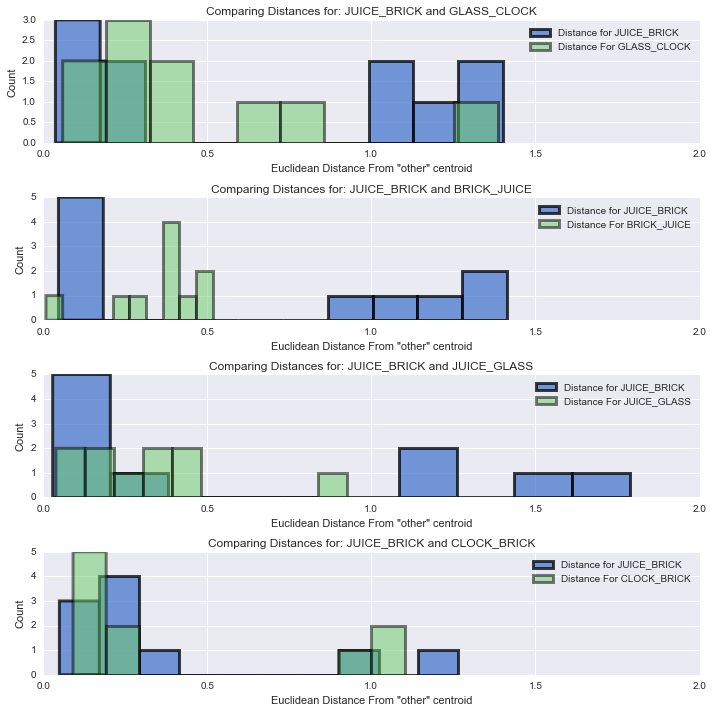

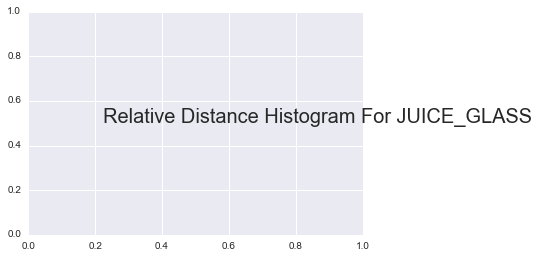

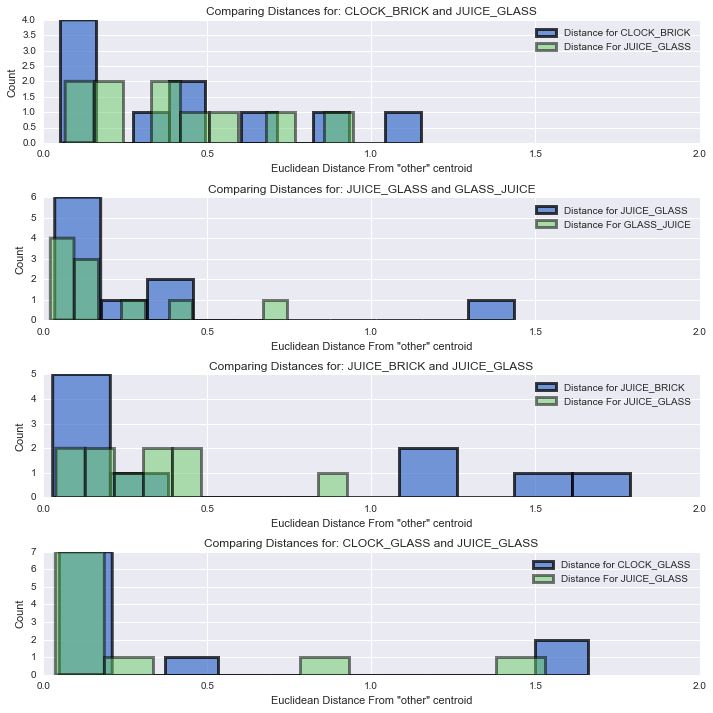

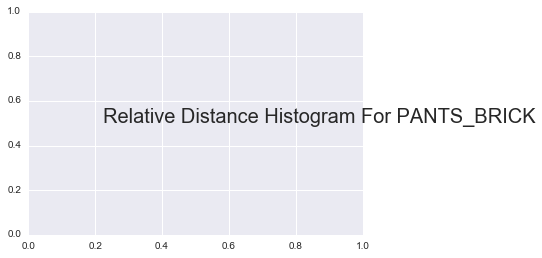

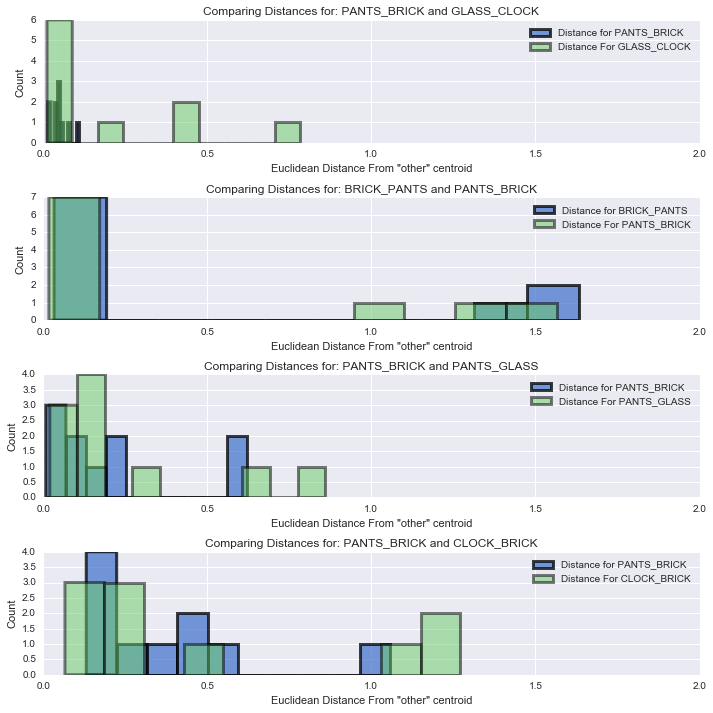

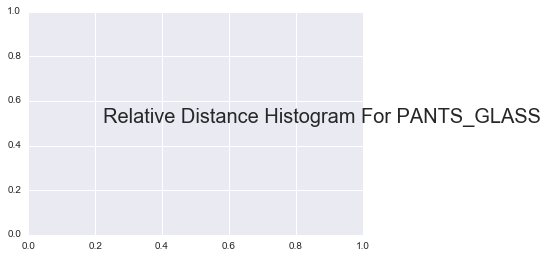

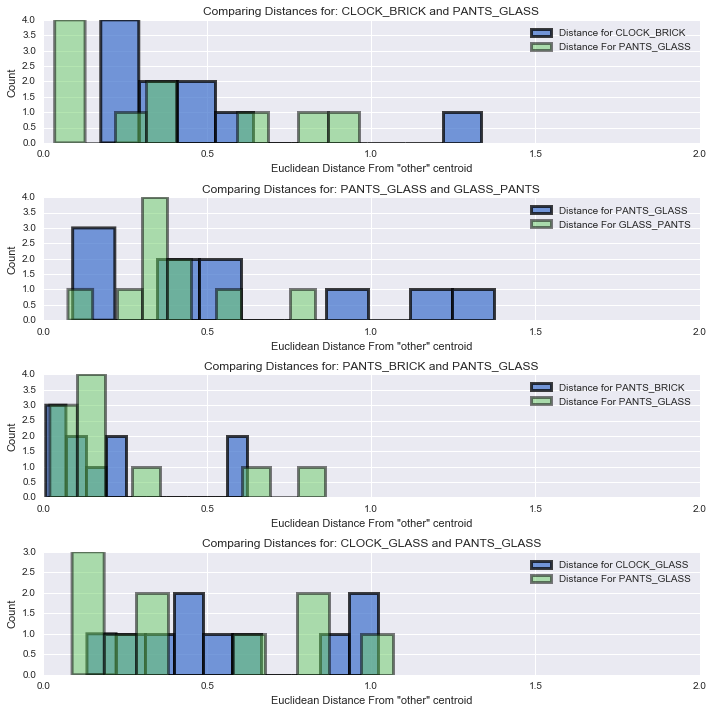

In [31]:
print len(groups)
i = 1
# loop through each unique word pairing
for word_pair in groups:
    group_pairings = []
    
    check_diff = [item for item in diff_words_groups if word_pair in item]
    check_reverse = [item for item in reverse_words_groups if word_pair in item]
    check_probe = [item for item in probe_words_groups if word_pair in item]
    check_target = [item for item in target_words_groups if word_pair in item]
    
    # check if there is a match in diff_words_groups, reverse_words, probe_words and target_words
    if len(check_diff) > 0:
        if len(check_reverse) > 0:
            if len(check_probe) > 0:
                if len(check_target) > 0:
                    # add group pairing for all 4 groups
                    group_pairings.append(check_diff[0])
                    group_pairings.append(check_reverse[0])
                    group_pairings.append(check_probe[0])
                    group_pairings.append(check_target[0])
    
    # initialize dictionary to hold histogram data for each word pairing
    group_pair_hist = {}
    
    
    fig=plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Relative Distance Histogram For %s'%(word_pair), fontsize=20)
    
    
    fig = plt.figure(figsize=(10,10))
    num_groups = len(group_pairings)
    ## Gotten the file names needed to analyze data
    for idx, group in enumerate(group_pairings):
        ######## Get list of files (.mat) we want to work with ########
        first_filedir = '../condensed_data/groups/' + group[0] + '/'
        second_filedir = '../condensed_data/groups/' + group[1] + '/'

        # get list of files for both word pairs
        first_files = []
        second_files = []

        files01 = os.listdir(first_filedir)
        files02 = os.listdir(second_filedir)
        for i in range(0, len(files01)):
            if files01[i].endswith('.mat'):
                first_files.append(files01[i])
            if files02[i].endswith('.mat'):
                second_files.append(files02[i])

        chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
#         chans_to_analyze = str(np.arange(1,96,1))
    
        # 3. LOOP THROUGH EACH CHANNEL FOR A CERTAIN GROUP (e.g. brick_clock)
        ################## LOOPING THROUGH EACH CHANNEL ##################
        first_feature = []
        second_feature = []
        for f in range(0, len(first_files)):
            # make sure this is a channel we want
            chan_num = first_files[f].split('_')[0]

            if chan_num in chans_to_analyze:
                #################### Set up data from the channel's mat file ####################
                # Go through each .mat file
                first_mat_file = first_filedir + first_files[f]
                second_mat_file = second_filedir + second_files[f]

                data_first = scipy.io.loadmat(first_mat_file)
                data_first = data_first['data']
                data_second = scipy.io.loadmat(second_mat_file)
                data_second = data_second['data']

                ## 01: Grab probewords for each struct
                first_probeWord = data_first['probeWord'][0][0][0]
                second_probeWord = data_second['probeWord'][0][0][0]

                ## 02: Grab targetwords for each struct
                first_targetWord = data_first['targetWord'][0][0][0]
                second_targetWord = data_second['targetWord'][0][0][0]

                ## 03: get channel number
                first_chanNum = data_first['chanNum'][0][0][0][0]
                second_chanNum = data_second['chanNum'][0][0][0][0]

                ## 04: get channel string
                first_chanStr = data_first['chanStr'][0][0][0]
                second_chanStr = data_second['chanStr'][0][0][0]

                ## 05: get power matrix Z is a #events X #freq. bands X #time bins
                first_matrix = data_first['powerMatZ'][0][0]
                second_matrix = data_second['powerMatZ'][0][0]

                ## 06: get the time point for probeword on
                first_timeZero = data_first['timeZero'][0][0][0]
                second_timeZero = data_second['timeZero'][0][0][0]

                ## 07: get the time point of vocalization
                first_vocalization = data_first['vocalization'][0][0][0]
                second_vocalization = data_second['vocalization'][0][0][0]

                ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
                ### 01: create power matrix with only delta, theta and high gamma
                first_matrix = first_matrix[:, freq_bands,:]
                second_matrix = second_matrix[:, freq_bands,:]

                ### 02: get only the time point before vocalization
                first_mean = [] # initialize average across time vector
                second_mean = [] # initialize average across time vector
                # append the time points
                for i in range(0, len(first_vocalization)):
                    first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
                for i in range(0, len(second_vocalization)):
                    second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

                # append the averaged time and event vector = frequency band feature
                first_feature.append(np.mean(first_mean,axis=0))
                second_feature.append(np.mean(second_mean,axis=0))
        
        ### 03: after looping through all significant channels, create list of feature vectors from each channel
        first_feature = np.array(first_feature)
        second_feature = np.array(second_feature)

        print first_feature.shape
        print second_feature.shape

        # compute freqX1 centroid vector
        first_centroid = np.mean(first_feature,axis=0)
        second_centroid = np.mean(second_feature,axis=0)

        # compute list of distances from other centroid
        first_hist = [distances(x, second_centroid) for x in first_feature]
        second_hist = [distances(x, first_centroid) for x in second_feature]

        ## log transform
#         first_hist = np.log(first_hist)
#         second_hist = np.log(second_hist)

        ## 04: Plot Histogram of Distances
        plt.subplot(num_groups, 1, idx+1)
#         fig = plt.figure()
        first_label = 'Distance for ' + group[0]
        second_label = 'Distance For ' + group[1]
        plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
        plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
        plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
        plt.xlim([0, 2.0])
        plt.xlabel('Euclidean Distance From "other" centroid')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
    
    plt.tight_layout()


12
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)
(95, 30)


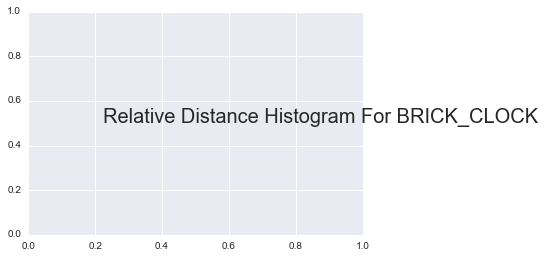

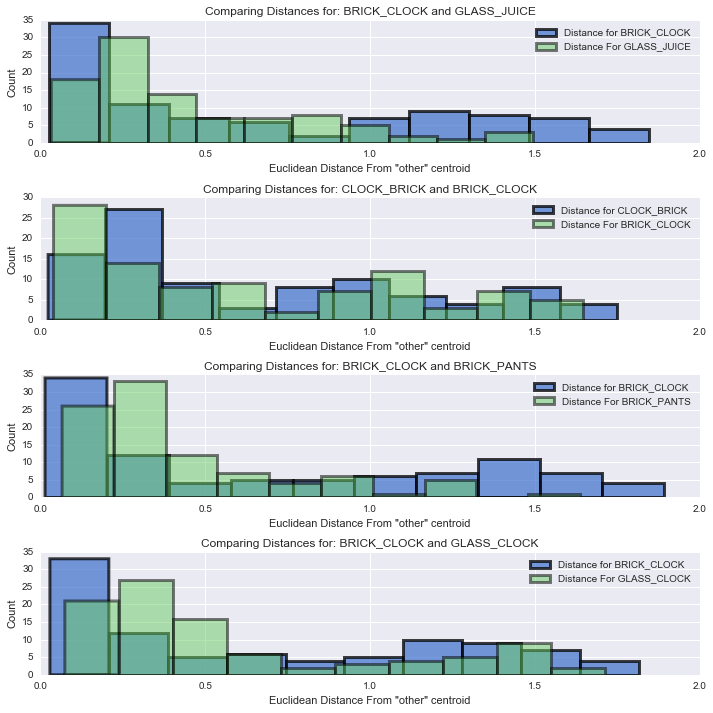

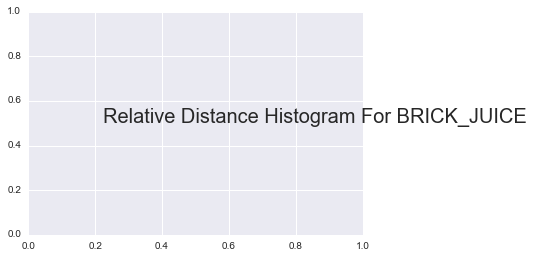

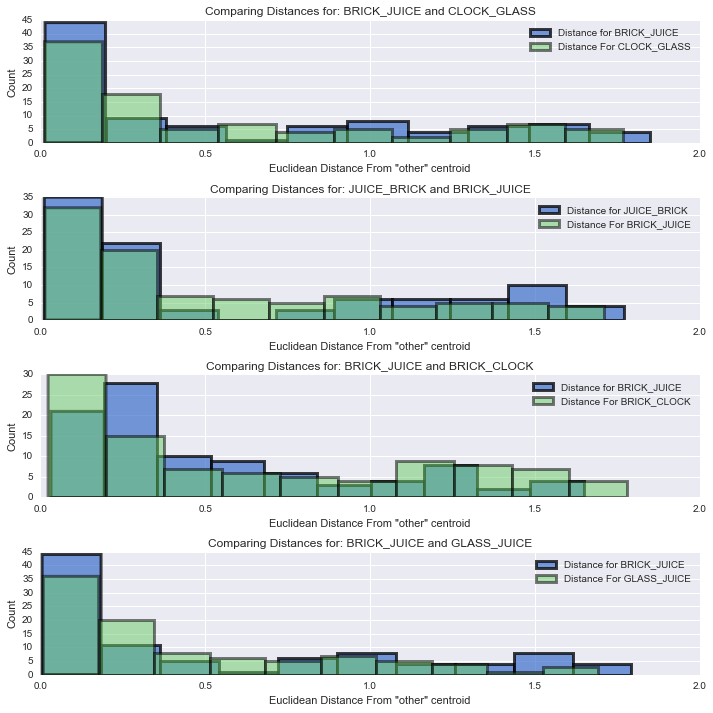

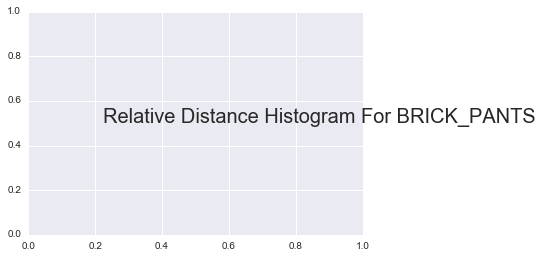

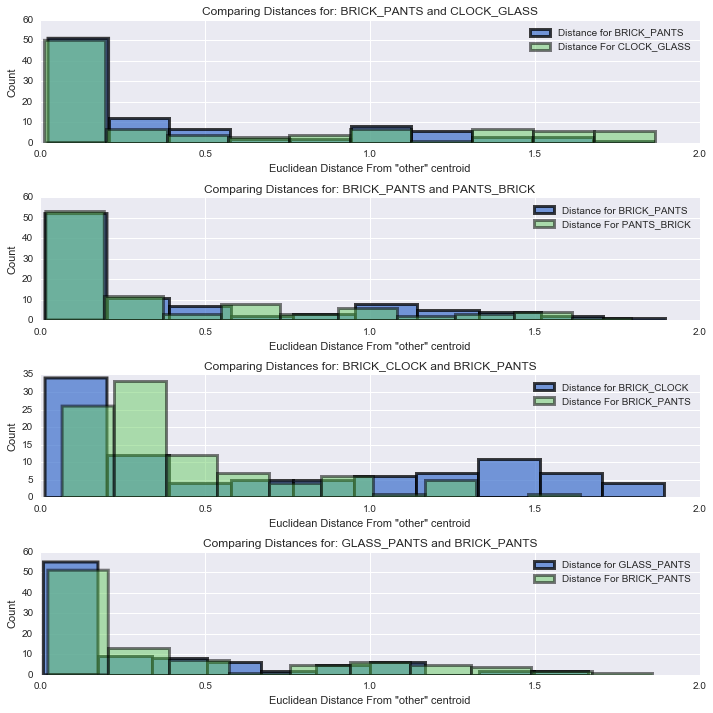

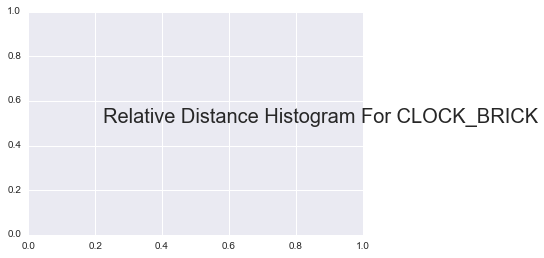

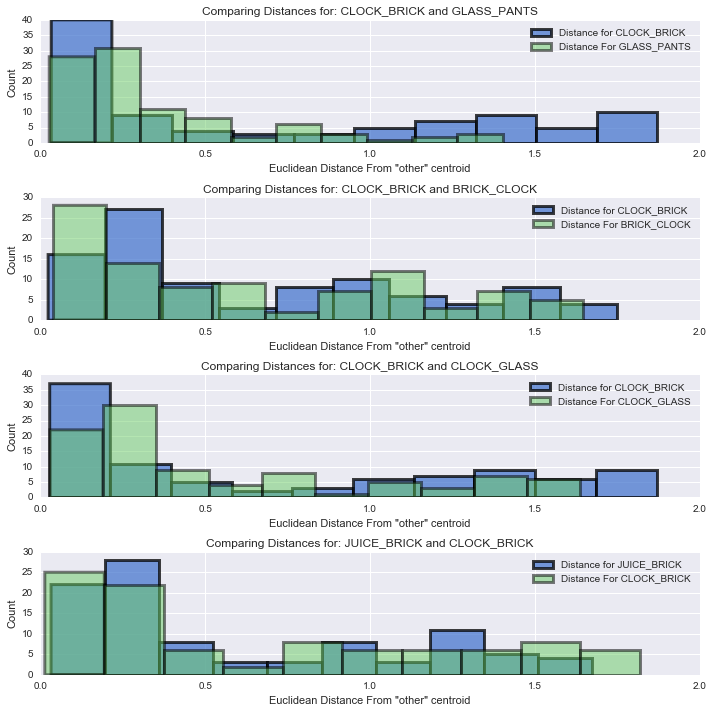

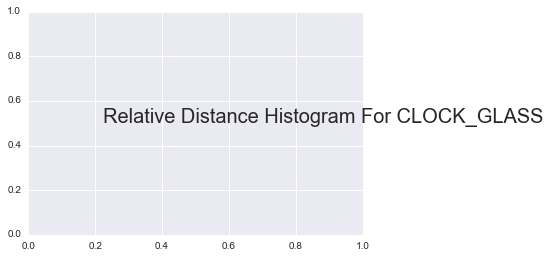

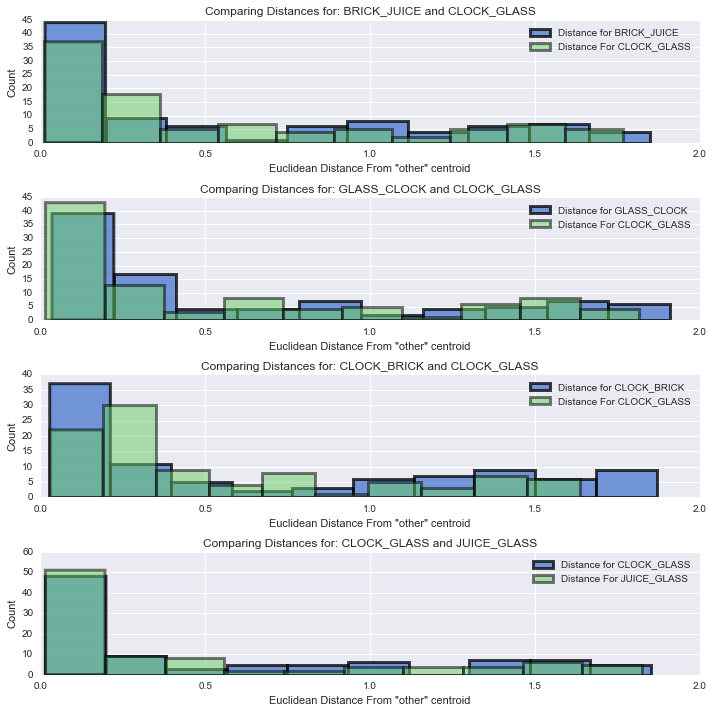

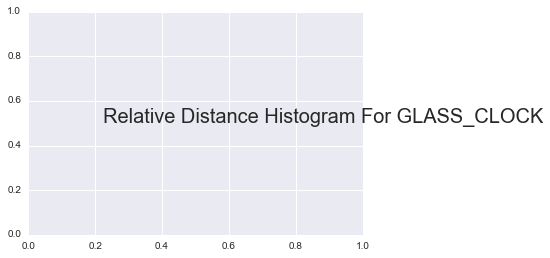

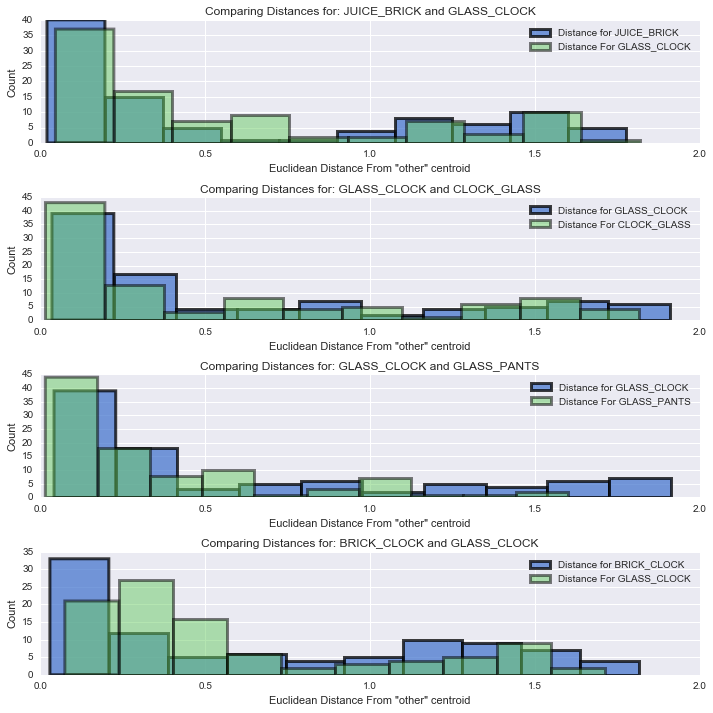

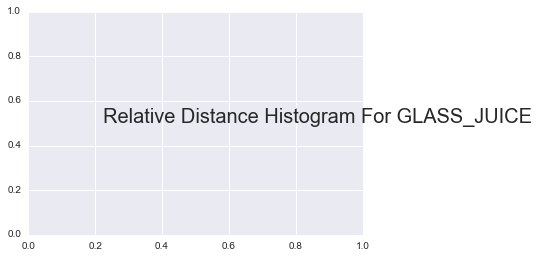

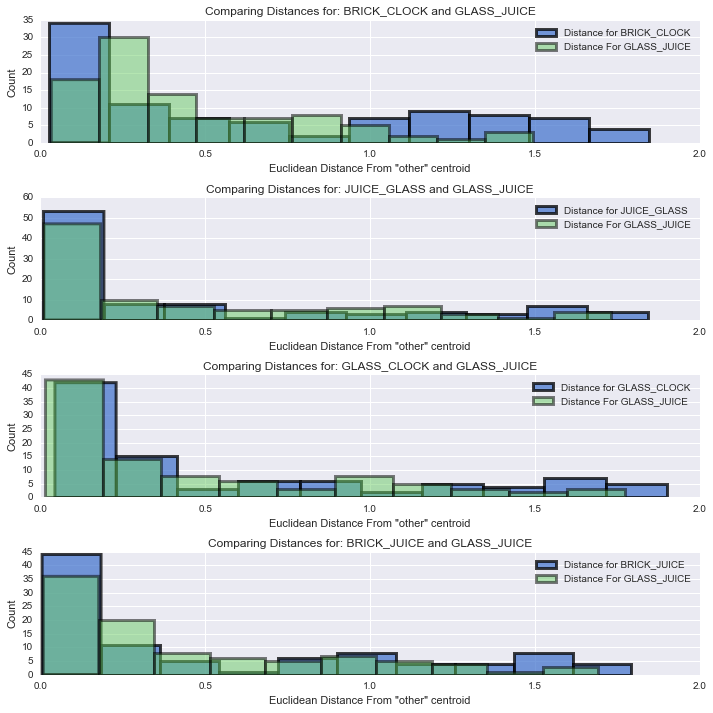

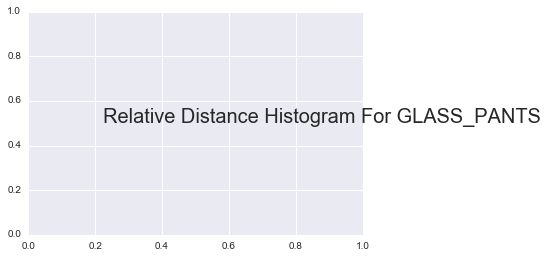

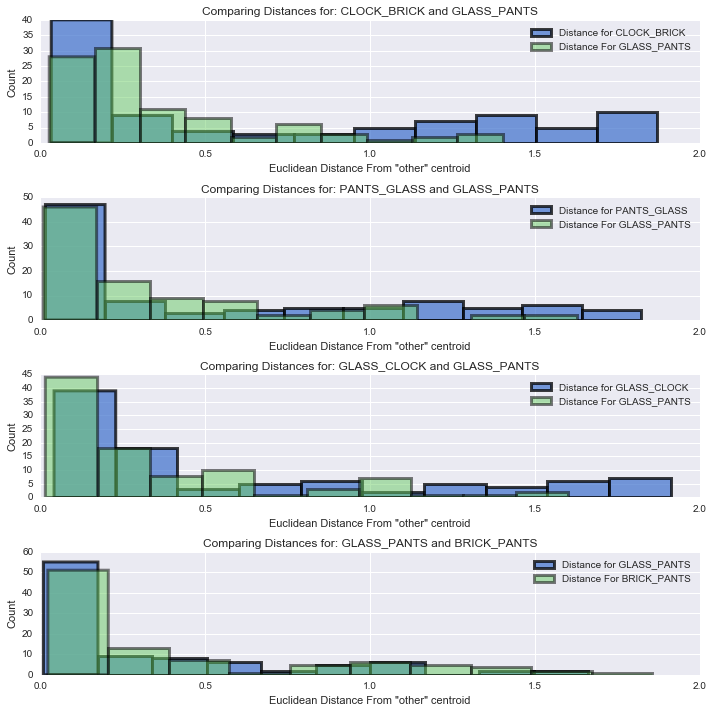

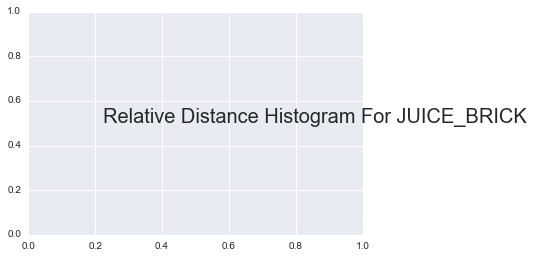

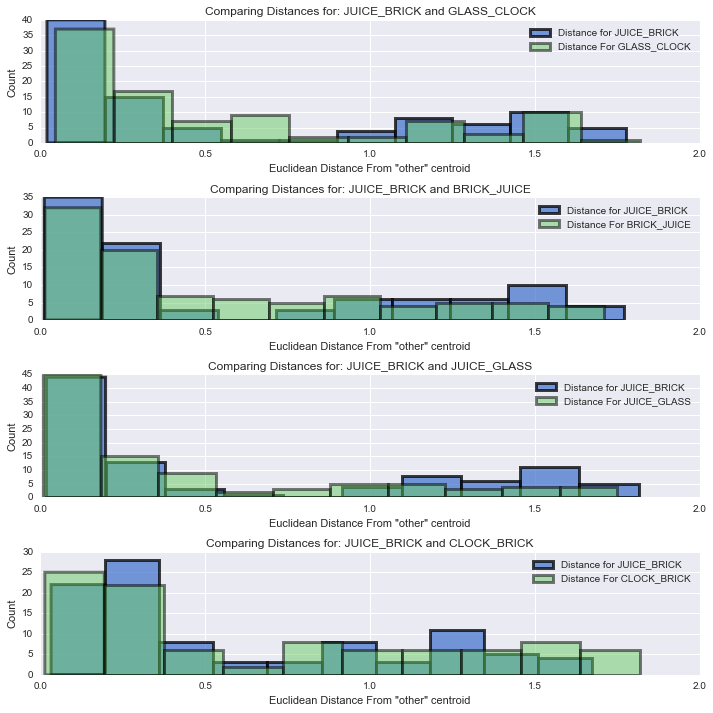

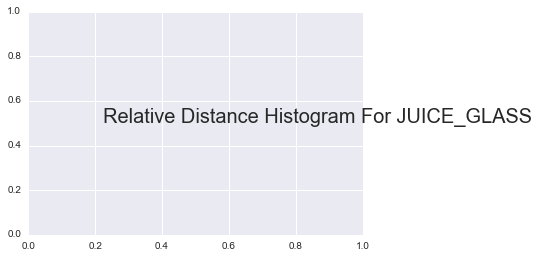

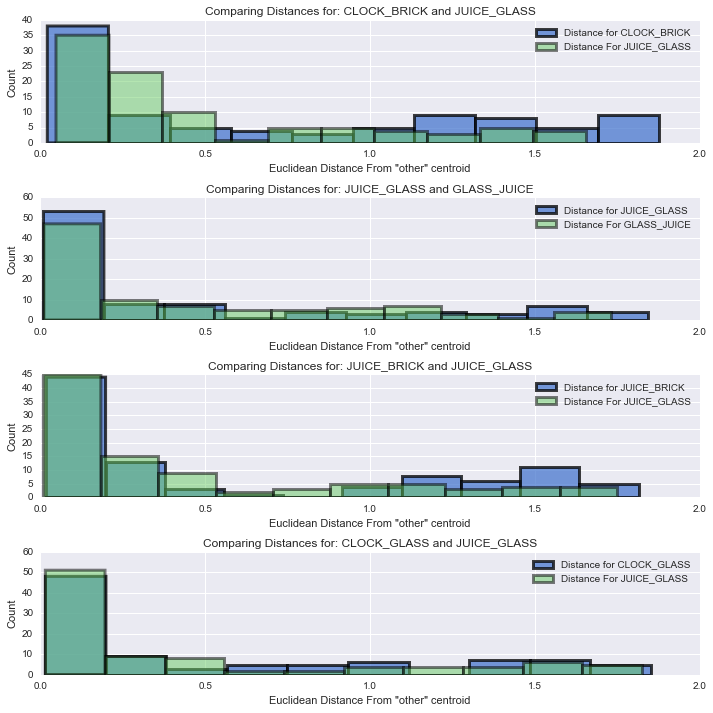

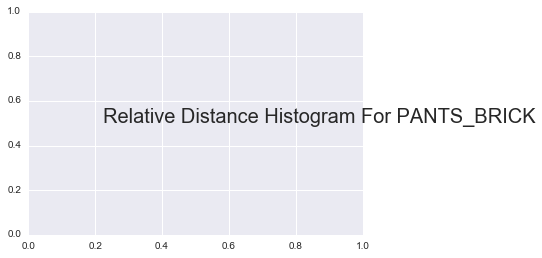

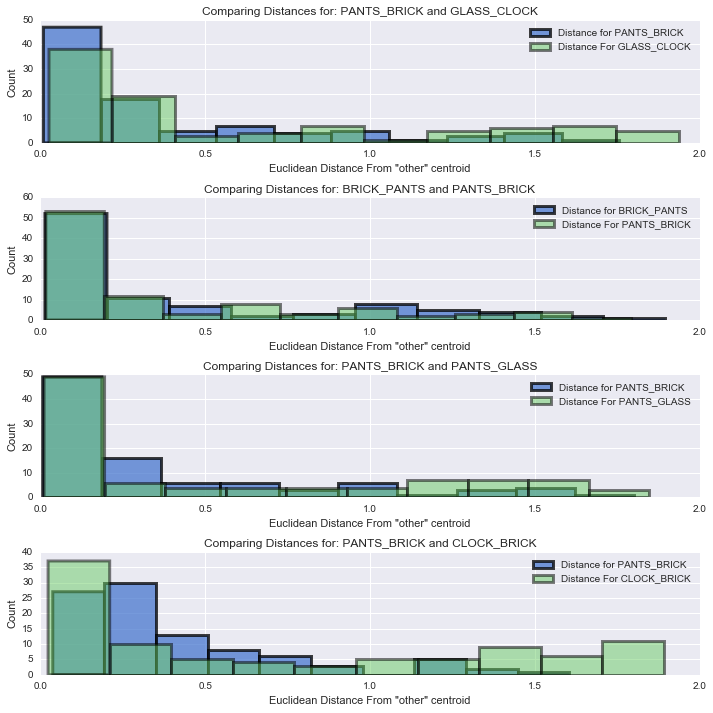

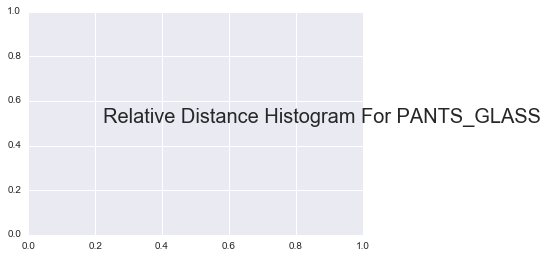

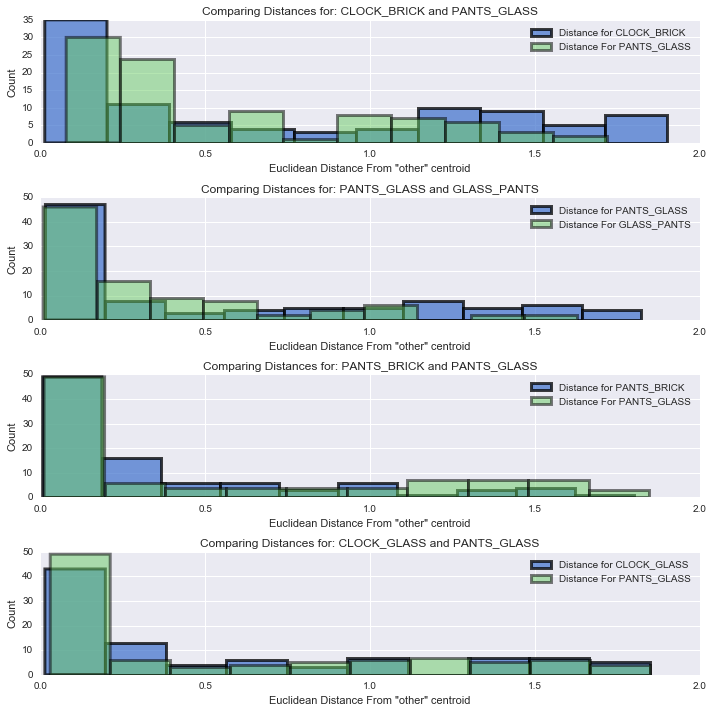

In [32]:
print len(groups)
i = 1
# loop through each unique word pairing
for word_pair in groups:
    group_pairings = []
    
    check_diff = [item for item in diff_words_groups if word_pair in item]
    check_reverse = [item for item in reverse_words_groups if word_pair in item]
    check_probe = [item for item in probe_words_groups if word_pair in item]
    check_target = [item for item in target_words_groups if word_pair in item]
    
    # check if there is a match in diff_words_groups, reverse_words, probe_words and target_words
    if len(check_diff) > 0:
        if len(check_reverse) > 0:
            if len(check_probe) > 0:
                if len(check_target) > 0:
                    # add group pairing for all 4 groups
                    group_pairings.append(check_diff[0])
                    group_pairings.append(check_reverse[0])
                    group_pairings.append(check_probe[0])
                    group_pairings.append(check_target[0])
    
    # initialize dictionary to hold histogram data for each word pairing
    group_pair_hist = {}
    
    
    fig=plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Relative Distance Histogram For %s'%(word_pair), fontsize=20)
    
    
    fig = plt.figure(figsize=(10,10))
    num_groups = len(group_pairings)
    ## Gotten the file names needed to analyze data
    for idx, group in enumerate(group_pairings):
        ######## Get list of files (.mat) we want to work with ########
        first_filedir = '../condensed_data/groups/' + group[0] + '/'
        second_filedir = '../condensed_data/groups/' + group[1] + '/'

        # get list of files for both word pairs
        first_files = []
        second_files = []

        files01 = os.listdir(first_filedir)
        files02 = os.listdir(second_filedir)
        for i in range(0, len(files01)):
            if files01[i].endswith('.mat'):
                first_files.append(files01[i])
            if files02[i].endswith('.mat'):
                second_files.append(files02[i])

#         chans_to_analyze = gridSearchChannels(anova_threshold, first_files, second_files)
        chans_to_analyze = str(np.arange(1,96,1))
    
        # 3. LOOP THROUGH EACH CHANNEL FOR A CERTAIN GROUP (e.g. brick_clock)
        ################## LOOPING THROUGH EACH CHANNEL ##################
        first_feature = []
        second_feature = []
        for f in range(0, len(first_files)):
            # make sure this is a channel we want
            chan_num = first_files[f].split('_')[0]

            if chan_num in chans_to_analyze:
                #################### Set up data from the channel's mat file ####################
                # Go through each .mat file
                first_mat_file = first_filedir + first_files[f]
                second_mat_file = second_filedir + second_files[f]

                data_first = scipy.io.loadmat(first_mat_file)
                data_first = data_first['data']
                data_second = scipy.io.loadmat(second_mat_file)
                data_second = data_second['data']

                ## 01: Grab probewords for each struct
                first_probeWord = data_first['probeWord'][0][0][0]
                second_probeWord = data_second['probeWord'][0][0][0]

                ## 02: Grab targetwords for each struct
                first_targetWord = data_first['targetWord'][0][0][0]
                second_targetWord = data_second['targetWord'][0][0][0]

                ## 03: get channel number
                first_chanNum = data_first['chanNum'][0][0][0][0]
                second_chanNum = data_second['chanNum'][0][0][0][0]

                ## 04: get channel string
                first_chanStr = data_first['chanStr'][0][0][0]
                second_chanStr = data_second['chanStr'][0][0][0]

                ## 05: get power matrix Z is a #events X #freq. bands X #time bins
                first_matrix = data_first['powerMatZ'][0][0]
                second_matrix = data_second['powerMatZ'][0][0]

                ## 06: get the time point for probeword on
                first_timeZero = data_first['timeZero'][0][0][0]
                second_timeZero = data_second['timeZero'][0][0][0]

                ## 07: get the time point of vocalization
                first_vocalization = data_first['vocalization'][0][0][0]
                second_vocalization = data_second['vocalization'][0][0][0]

                ########### FINISHED EXTRACTING DATA FROM STRUCTS ###################
                ### 01: create power matrix with only delta, theta and high gamma
                first_matrix = first_matrix[:, freq_bands,:]
                second_matrix = second_matrix[:, freq_bands,:]

                ### 02: get only the time point before vocalization
                first_mean = [] # initialize average across time vector
                second_mean = [] # initialize average across time vector
                # append the time points
                for i in range(0, len(first_vocalization)):
                    first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
                for i in range(0, len(second_vocalization)):
                    second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

                # append the averaged time and event vector = frequency band feature
                first_feature.append(np.mean(first_mean,axis=0))
                second_feature.append(np.mean(second_mean,axis=0))
        
        ### 03: after looping through all significant channels, create list of feature vectors from each channel
        first_feature = np.array(first_feature)
        second_feature = np.array(second_feature)

        print first_feature.shape
        print second_feature.shape

        # compute freqX1 centroid vector
        first_centroid = np.mean(first_feature,axis=0)
        second_centroid = np.mean(second_feature,axis=0)

        # compute list of distances from other centroid
        first_hist = [distances(x, second_centroid) for x in first_feature]
        second_hist = [distances(x, first_centroid) for x in second_feature]

        ## log transform
#         first_hist = np.log(first_hist)
#         second_hist = np.log(second_hist)

        ## 04: Plot Histogram of Distances
        plt.subplot(num_groups, 1, idx+1)
#         fig = plt.figure()
        first_label = 'Distance for ' + group[0]
        second_label = 'Distance For ' + group[1]
        plt.hist(first_hist, label=first_label, lw=3, alpha = 0.75)
        plt.hist(second_hist, label=second_label, lw=3, alpha = 0.5)
        plt.title('Comparing Distances for: ' + group[0] + ' and ' + group[1])
        plt.xlim([0, 2.0])
        plt.xlabel('Euclidean Distance From "other" centroid')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
    
    plt.tight_layout()
